# 🧮 Modeling Expected Credit Loss (ECL) under IFRS 9

## 1. Introduction

This project aims to model the **Expected Credit Loss (ECL)** of a loan portfolio in accordance with the **IFRS 9** accounting standard. The analysis is based on the **German Credit Dataset**, which contains socio-economic and financial information on 1,000 borrowers.

We will estimate the three key components of ECL:

- **PD (Probability of Default)**: the likelihood that a borrower defaults within a given time horizon.
- **LGD (Loss Given Default)**: the proportion of the exposure lost in the event of default.
- **EAD (Exposure at Default)**: the amount at risk at the time of default.

## 2. Project Objectives

- Predict the probability of default using statistical and machine learning models.
- Estimate expected credit losses under multiple economic scenarios.
- Apply the IFRS 9 staging framework (Stage 1 / 2 / 3) to simulate credit risk deterioration.
- Visualize the impact of key credit risk metrics and stress assumptions.

This project provides a practical and modular approach to credit risk modeling, combining regulatory compliance, data science, and real-world financial analytics.

### IFRS 9 Definitions and Assumptions

Under IFRS 9, credit risk must be measured using an **Expected Credit Loss (ECL)** approach that incorporates not only historical data, but also current and forward-looking information. The core formula is:

$$
\text{ECL} = \text{PD} \times \text{LGD} \times \text{EAD}
$$

#### Key Components:

- **Probability of Default (PD)**: The likelihood that a borrower will default over a specific time horizon (e.g. 12 months or lifetime).
- **Loss Given Default (LGD)**: The proportion of the exposure that will be lost if the borrower defaults.
- **Exposure at Default (EAD)**: The expected outstanding balance at the time of default, including interest or credit line utilization.

#### IFRS 9 Staging Model:

| Stage     | Credit Risk Change       | ECL Horizon           | Implication                        |
|-----------|--------------------------|------------------------|------------------------------------|
| Stage 1   | No significant increase  | 12-month ECL           | Performing exposures               |
| Stage 2   | Significant deterioration| Lifetime ECL           | Underperforming exposures          |
| Stage 3   | Credit-impaired          | Lifetime ECL           | Non-performing exposures           |

#### Assumptions:

- Borrowers are initially classified as **Stage 1** unless credit risk increases significantly.
- Transition from Stage 1 to Stage 2 depends on borrower behavior, risk scoring, or days past due (e.g. 30+ DPD).
- Economic scenarios will be considered to simulate **forward-looking PD** shifts.
- LGD and EAD are modeled using historical behavior and simplified assumptions due to data limitations.

These principles will guide how we model the credit risk metrics and simulate IFRS 9-compliant ECL values across a synthetic portfolio.

## 3. Data Loading and Exploration

We use the original **German Credit Dataset** (`german.data`), which contains 1,000 observations on individual borrowers and includes demographic, financial, and behavioral attributes. Categorical variables are encoded using symbolic codes (e.g., A11, A30), which will later be decoded based on the accompanying documentation.

The last column is the target variable:
- `1`: Good credit risk
- `2`: Bad credit risk

In this section, we will:
- Load the raw dataset using manually defined column names,
- Perform an initial data inspection,
- Identify missing values and examine data types,
- Explore the distribution of the target variable.

In [2860]:
# Import required libraries

import pandas as pd
import numpy as np 
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2861]:
columns = [
    "Status_Checking_Account",       # A11–A14
    "Duration_Months",               # numeric
    "Credit_History",                # A30–A34
    "Purpose",                       # A40–A410
    "Credit_Amount",                # numeric
    "Savings_Account",              # A61–A65
    "Employment_Since",             # A71–A75
    "Installment_Rate",             # numeric
    "Personal_Status_Sex",          # A91–A95
    "Other_Debtors",                # A101–A103
    "Residence_Since",              # numeric
    "Property",                     # A121–A124
    "Age",                          # numeric
    "Other_Installment_Plans",      # A141–A143
    "Housing",                      # A151–A153
    "Existing_Credits",             # numeric
    "Job",                          # A171–A174
    "People_Liable",               # numeric
    "Telephone",                    # A191–A192
    "Foreign_Worker",               # A201–A202
    "Risk"                          # Target: 1 = good, 2 = bad
]

In [2862]:
df_raw = pd.read_csv('/Users/danielosse/Documents/PROJETS PYTHON/IFRS9/statlog+german+credit+data/german.data', 
                     sep = ' ', 
                     header = None, 
                     names = columns)
df_raw.head()

,Status_Checking_Account,Duration_Months,Credit_History,Purpose,Credit_Amount,Savings_Account,Employment_Since,Installment_Rate,Personal_Status_Sex,Other_Debtors,Residence_Since,Property,Age,Other_Installment_Plans,Housing,Existing_Credits,Job,People_Liable,Telephone,Foreign_Worker,Risk
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,4,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,2,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,3,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,4,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,4,A124,53,A143,A153,2,A173,2,A191,A201,2


In [2863]:
# Dataset shape and types
print("Shape", df_raw.shape)
print("\n Data types:")
print(df_raw.dtypes)

# Missing values
print("\n Missing values:")
print(df_raw.isnull().sum())

Shape (1000, 21)

 Data types:
Status_Checking_Account    object
Duration_Months             int64
Credit_History             object
Purpose                    object
Credit_Amount               int64
Savings_Account            object
Employment_Since           object
Installment_Rate            int64
Personal_Status_Sex        object
Other_Debtors              object
Residence_Since             int64
Property                   object
Age                         int64
Other_Installment_Plans    object
Housing                    object
Existing_Credits            int64
Job                        object
People_Liable               int64
Telephone                  object
Foreign_Worker             object
Risk                        int64
dtype: object

 Missing values:
Status_Checking_Account    0
Duration_Months            0
Credit_History             0
Purpose                    0
Credit_Amount              0
Savings_Account            0
Employment_Since           0
Installment_Rate    

<Axes: title={'center': 'Distribution of Credit Risk'}, xlabel='Risk'>

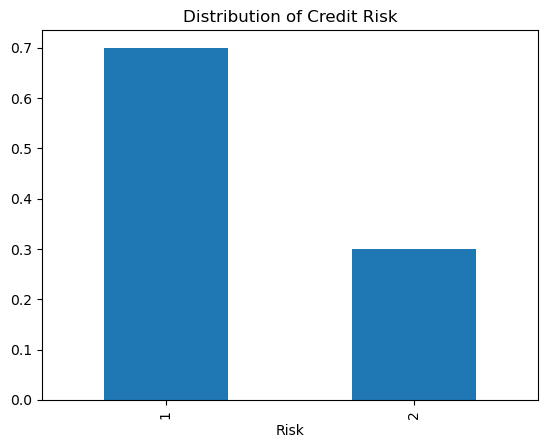

In [2864]:
df_raw['Risk'].value_counts(normalize = True).plot(kind = "bar", title = "Distribution of Credit Risk")

## 4. Decoding Categorical Variables

The original German Credit dataset uses symbolic codes (e.g., A11, A30) to represent categorical values. To enhance interpretability and prepare the data for modeling, we will map each code to its corresponding human-readable label based on the official documentation.

This step includes:
- Creating mapping dictionaries for each categorical variable,
- Replacing the symbolic codes in the dataset with descriptive labels.

This decoding step improves readability and ensures consistency in subsequent preprocessing and analysis.

In [2866]:
# Attribute 1 : Status of existing checking account
checking_account_map = {
    'A11': '0 DM',
    'A12': '0 <= ... < 200 DM',
    'A13': '>= 200 DM or salary assignment',
    'A14': 'no checking account'
}

df_raw['Status_Checking_Account'] = df_raw['Status_Checking_Account'].map(checking_account_map)
df_raw['Status_Checking_Account'].value_counts()

Status_Checking_Account
no checking account               394
0 DM                              274
0 <= ... < 200 DM                 269
>= 200 DM or salary assignment     63
Name: count, dtype: int64

In [2867]:
# Attribute 3: Credit history
credit_history_map = {
    'A30': 'no credits / all paid',
    'A31': 'all paid at this bank',
    'A32': 'current credits paid',
    'A33': 'delayed previously',
    'A34': 'critical / other banks'
}

# Attribute 4: Purpose
purpose_map = {
    'A40': 'new car',
    'A41': 'used car',
    'A42': 'furniture/equipment',
    'A43': 'radio/TV',
    'A44': 'appliances',
    'A45': 'repairs',
    'A46': 'education',
    'A47': 'vacation (missing)',
    'A48': 'retraining',
    'A49': 'business',
    'A410': 'others'
}

# Attribute 6: Savings account/bonds
savings_account_map = {
    'A61': '< 100 DM',
    'A62': '100 <= ... < 500 DM',
    'A63': '500 <= ... < 1000 DM',
    'A64': '>= 1000 DM',
    'A65': 'unknown / no savings'
}

# Attribute 7: Present employment since
employment_map = {
    'A71': 'unemployed',
    'A72': '< 1 year',
    'A73': '1 <= ... < 4 years',
    'A74': '4 <= ... < 7 years',
    'A75': '>= 7 years'
}

# Attribute 9: Personal status and sex
personal_status_map = {
    'A91': 'male divorced/separated',
    'A92': 'female div/sep/married',
    'A93': 'male single',
    'A94': 'male married/widowed',
    'A95': 'female single'
}

# Attribute 10: Other debtors / guarantors
other_debtors_map = {
    'A101': 'none',
    'A102': 'co-applicant',
    'A103': 'guarantor'
}

# Attribute 12: Property
property_map = {
    'A121': 'real estate',
    'A122': 'building society savings / life insurance',
    'A123': 'car or other (not in savings)',
    'A124': 'unknown / no property'
}

# Attribute 14: Other installment plans
installment_plans_map = {
    'A141': 'bank',
    'A142': 'stores',
    'A143': 'none'
}

# Attribute 15: Housing
housing_map = {
    'A151': 'rent',
    'A152': 'own',
    'A153': 'for free'
}

# Attribute 17: Job
job_map = {
    'A171': 'unemployed / unskilled (non-resident)',
    'A172': 'unskilled (resident)',
    'A173': 'skilled employee / official',
    'A174': 'management / self-employed / highly qualified'
}

# Attribute 19: Telephone
telephone_map = {
    'A191': 'no',
    'A192': 'yes (registered)'
}

# Attribute 20: Foreign worker
foreign_worker_map = {
    'A201': 'yes',
    'A202': 'no'
}

In [2868]:
df_raw['Credit_History'] = df_raw['Credit_History'].map(credit_history_map)
df_raw['Purpose'] = df_raw['Purpose'].map(purpose_map)
df_raw['Savings_Account'] = df_raw['Savings_Account'].map(savings_account_map)
df_raw['Employment_Since'] = df_raw['Employment_Since'].map(employment_map)
df_raw['Personal_Status_Sex'] = df_raw['Personal_Status_Sex'].map(personal_status_map)
df_raw['Other_Debtors'] = df_raw['Other_Debtors'].map(other_debtors_map)
df_raw['Property'] = df_raw['Property'].map(property_map)
df_raw['Other_Installment_Plans'] = df_raw['Other_Installment_Plans'].map(installment_plans_map)
df_raw['Housing'] = df_raw['Housing'].map(housing_map)
df_raw['Job'] = df_raw['Job'].map(job_map)
df_raw['Telephone'] = df_raw['Telephone'].map(telephone_map)
df_raw['Foreign_Worker'] = df_raw['Foreign_Worker'].map(foreign_worker_map)

## 5. Exploratory Data Analysis (EDA)

This section explores the distribution and relationships between key variables in the dataset, with a focus on their potential influence on credit risk.

Goals:
- Visualize the distributions of numerical and categorical variables,
- Compare features between good and bad credit risks,
- Identify early indicators of potential default.

### 5.1 EDA Summary – Key Insights Based on Visual Analysis

#### 🎯 Target Distribution:
- The dataset is imbalanced: ~70% of borrowers are classified as good credit risks (1), and ~30% as bad risks (2).

---

#### 📈 Numerical Features:

- **Credit_Amount**:
  - Both classes are concentrated around small to medium credit amounts (1,000–5,000 DM).
  - There is no significant visual difference in the central tendency between good and bad risks.
  - However, **outliers with very large credit amounts exist in both groups**.

- **Duration_Months**:
  - Bad risks tend to be associated with **longer credit durations**.
  - The boxplot confirms a **higher median** and **greater dispersion** for bad credit risks compared to good ones.

- **Age**:
  - The distribution of age is **similar across both groups**.
  - Good risks are slightly more represented in older age brackets, but the difference is modest.

---

#### 📊 Categorical Features:

- **Purpose**:
  - The most common purposes are *radio/TV*, *furniture/equipment*, and *new car*.
  - The distribution of bad risks is relatively proportional to that of good risks within each category.
  - There is **no category that stands out clearly as riskier** based on the bar chart.

- **Savings_Account**:
  - Borrowers with `< 100 DM` represent a large part of the portfolio, with a visibly higher count of bad risks.
  - Higher savings categories (≥ 500 DM) are less represented overall, but show **lower absolute numbers of defaults**, not necessarily lower proportions.

- **Employment_Since**:
  - The **category '1 <= ... < 4 years'** has the **highest number of bad risks**.
  - The best-performing group in terms of **lower bad risk count** appears to be `'4 <= ... < 7 years'`.
  - Contrary to common assumptions, **unemployed** clients are **not** the riskiest group here.

- **Personal_Status_Sex**:
  - *Single males* and *female div/sep/married* make up the majority of the portfolio.
  - All categories show some level of default, but there is **no single dominant risk group** in this feature.

---

#### ✅ Conclusion:
- **Duration_Months** is a clear differentiator between good and bad credit risks.
- **Credit_Amount** and **Age** show minor differences, but are still valuable to test in modeling.
- Among categorical variables, **Savings_Account** and **Employment_Since** show some signal, though **not necessarily in a linear or intuitive fashion**.
- Feature engineering and binning may help reveal more structure in certain variables.

The next step will focus on preparing the dataset for modeling: encoding categorical variables, selecting features, and estimating the probability of default (PD).

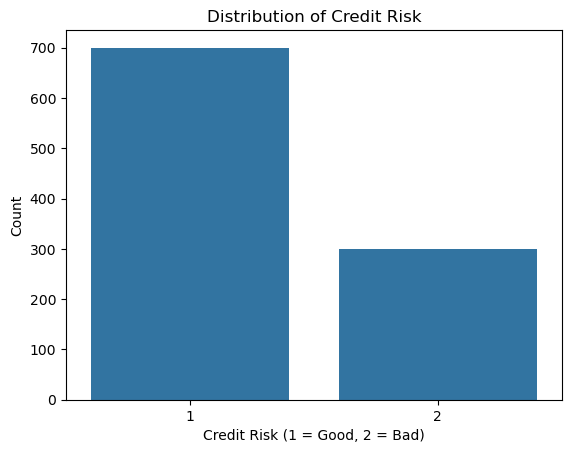

Risk
1    0.7
2    0.3
Name: proportion, dtype: float64

In [2871]:
sns.countplot(x = 'Risk', data = df_raw)
plt.title('Distribution of Credit Risk')
plt.xlabel('Credit Risk (1 = Good, 2 = Bad)')
plt.ylabel('Count')
plt.show()

df_raw['Risk'].value_counts(normalize = True)

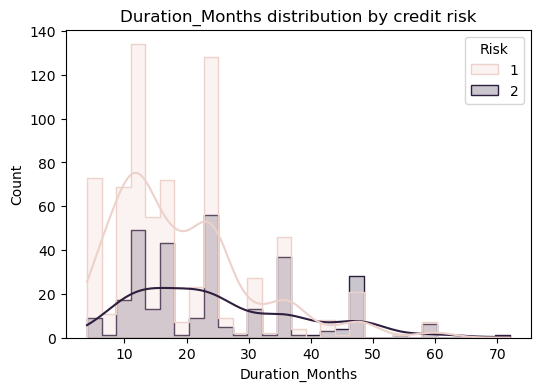

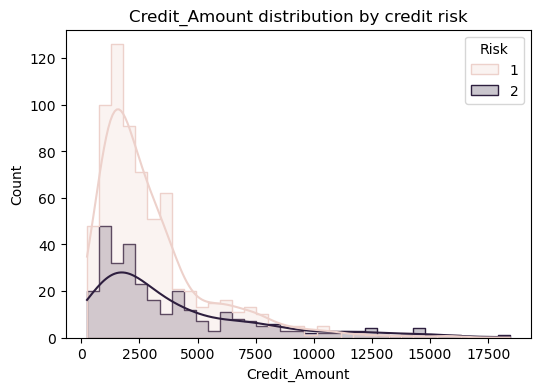

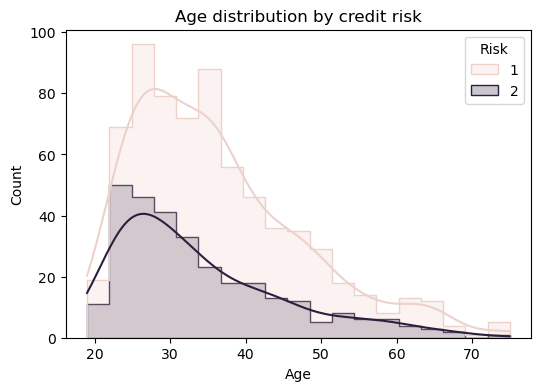

In [2872]:
var_nums = ['Duration_Months','Credit_Amount','Age']

for var in var_nums:
    plt.figure(figsize=(6,4))
    sns.histplot(data = df_raw, x = var, hue = 'Risk', kde = True, element = 'step')
    plt.title(f'{var} distribution by credit risk')
    plt.show()

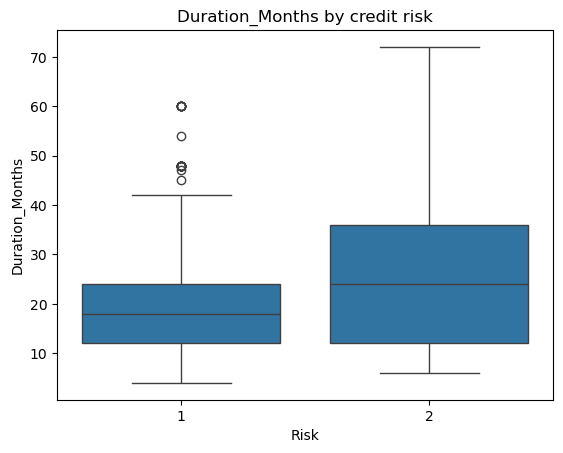

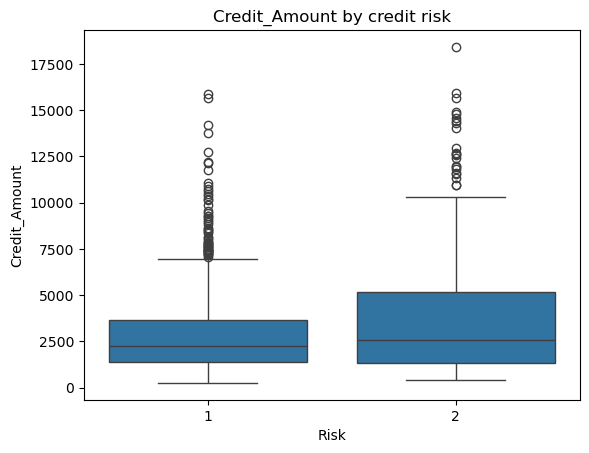

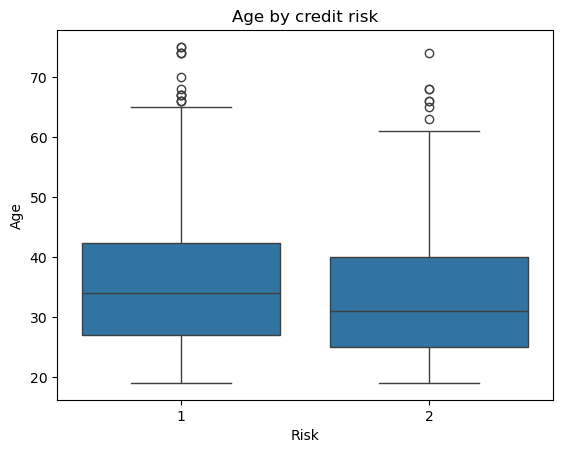

In [2873]:
for var in var_nums:
    sns.boxplot(x = 'Risk', y = var, data = df_raw)
    plt.title(f'{var} by credit risk')
    plt.show()

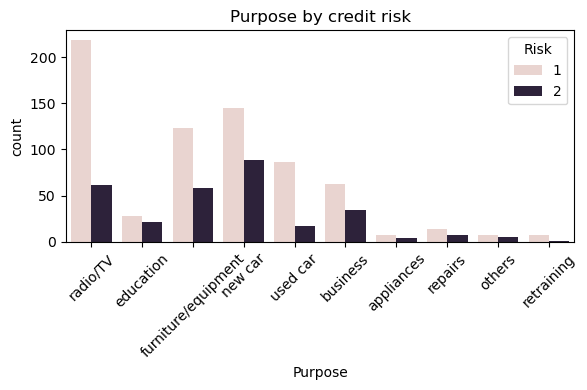

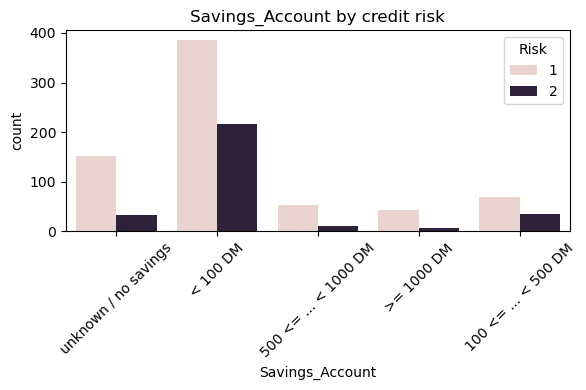

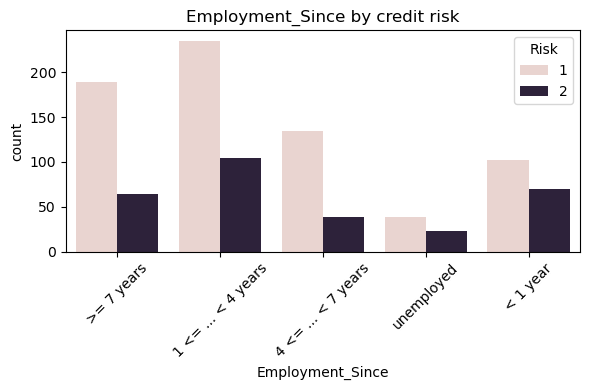

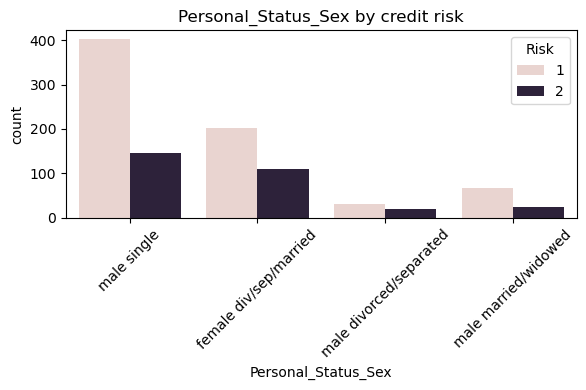

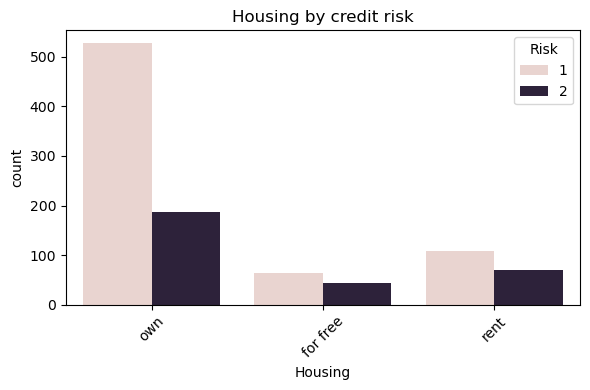

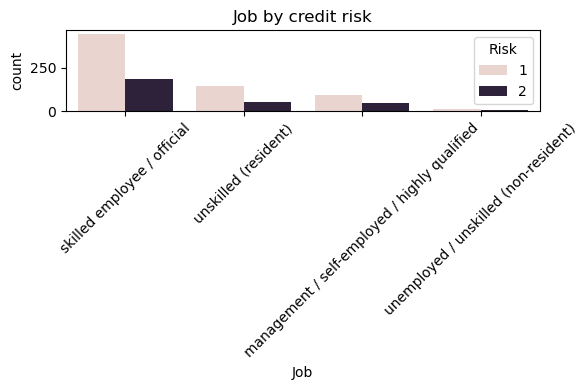

In [2874]:
var_cats = ["Purpose", "Savings_Account", "Employment_Since",
    "Personal_Status_Sex", "Housing", "Job"]

for var in var_cats:
    plt.figure(figsize=(6,4))
    sns.countplot(data = df_raw, x = var, hue = "Risk")
    plt.title(f"{var} by credit risk")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

### 5.2 Statistical Profile and Predictive Potential of Features

#### ➤ Descriptive Statistics by Credit Risk

The grouped summary statistics show that:

- **Credit_Amount**: The mean and median loan amounts are slightly higher for bad credit risks. However, the difference is modest, and there is considerable overlap between the two groups. This feature may offer limited predictive power on its own but could contribute when combined with others.

- **Duration_Months**: This is one of the most promising numerical features. Bad credit risks have longer loan durations on average, with a higher median and broader distribution. It will likely be a strong predictor of default.

- **Age**: The average age is slightly higher for good risks, but the difference is not substantial. Age may have weak standalone predictive power.

---

#### ➤ Correlation Matrix

The correlation matrix reveals:

- There is a **moderate positive correlation** (~0.6) between `Credit_Amount` and `Duration_Months`, which is intuitive: longer-term loans are often for larger amounts.
- `Age` shows low correlation with both other numerical features.

✅ No variable pair exceeds 0.8 correlation, so **multicollinearity is not a concern** at this stage.

---

#### ➤ Default Rates by Categorical Variable

By examining default rates within each category:

- **Savings_Account**: This variable shows clear segmentation. Categories such as `"< 100 DM"` and `"unknown"` are associated with **higher default rates**, while categories like `">= 1000 DM"` show lower risk. This feature is likely predictive.

- **Employment_Since**: The group `"1 <= ... < 4 years"` shows the highest default share. Other groups vary without a clear monotonic pattern, but `"4 <= ... < 7 years"` appears relatively safer.

- **Purpose**: The default rate varies slightly by purpose, but **no category is extremely risky**. A few categories like `"others"` or `"education"` may carry slightly more risk but require more data to confirm.

- **Personal_Status_Sex**: The differences between demographic groups are not sharp enough to suggest strong predictive potential.

- **Housing**: Default rates are very similar across `"own"`, `"rent"`, and `"for free"`. This feature does not seem discriminative.

✅ These results help prioritize which variables to encode and use in modeling.

In [2876]:
grouped_stats = df_raw.groupby('Risk')[var_nums].describe().T
display(grouped_stats)

Risk                              1             2
Duration_Months count    700.000000    300.000000
                mean      19.207143     24.860000
                std       11.079564     13.282639
                min        4.000000      6.000000
                25%       12.000000     12.000000
                50%       18.000000     24.000000
                75%       24.000000     36.000000
                max       60.000000     72.000000
Credit_Amount   count    700.000000    300.000000
                mean    2985.457143   3938.126667
                std     2401.472278   3535.818955
                min      250.000000    433.000000
                25%     1375.500000   1352.500000
                50%     2244.000000   2574.500000
                75%     3634.750000   5141.500000
                max    15857.000000  18424.000000
Age             count    700.000000    300.000000
                mean      36.224286     33.963333
                std       11.381145     11.222379
                min       19.000000     19.000000
                25%       27.000000     25.000000
                50%       34.000000     31.000000
                75%       42.250000     40.000000
                max       75.000000     74.000000

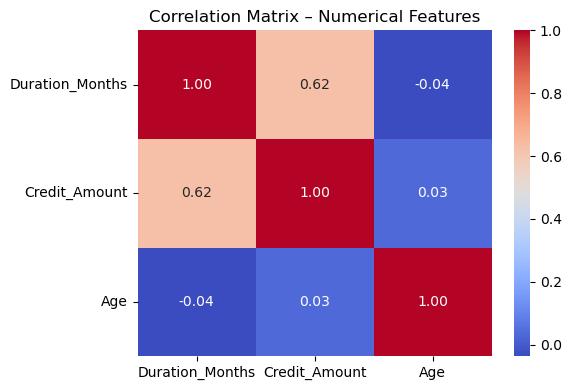

In [2877]:
corr_matrix = df_raw[var_nums].corr()

plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot = True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix – Numerical Features")
plt.tight_layout()
plt.show()

In [2878]:
for var in var_cats:
    print(f'---{var}---')
    display(pd.crosstab(df_raw[var], df_raw["Risk"], normalize = 'index') * 100)

---Purpose---


Risk,1,2
Purpose,,
appliances,66.666667,33.333333
business,64.948454,35.051546
education,56.000000,44.000000
furniture/equipment,67.955801,32.044199
new car,61.965812,38.034188
others,58.333333,41.666667
radio/TV,77.857143,22.142857
repairs,63.636364,36.363636
retraining,88.888889,11.111111


---Savings_Account---


Risk,1,2
Savings_Account,,
100 <= ... < 500 DM,66.990291,33.009709
500 <= ... < 1000 DM,82.539683,17.460317
< 100 DM,64.013267,35.986733
>= 1000 DM,87.500000,12.500000
unknown / no savings,82.513661,17.486339


---Employment_Since---


Risk,1,2
Employment_Since,,
1 <= ... < 4 years,69.321534,30.678466
4 <= ... < 7 years,77.586207,22.413793
< 1 year,59.302326,40.697674
>= 7 years,74.703557,25.296443
unemployed,62.903226,37.096774


---Personal_Status_Sex---


Risk,1,2
Personal_Status_Sex,,
female div/sep/married,64.838710,35.161290
male divorced/separated,60.000000,40.000000
male married/widowed,72.826087,27.173913
male single,73.357664,26.642336


---Housing---


Risk,1,2
Housing,,
for free,59.259259,40.740741
own,73.913043,26.086957
rent,60.893855,39.106145


---Job---


Risk,1,2
Job,,
management / self-employed / highly qualified,65.540541,34.459459
skilled employee / official,70.476190,29.523810
unemployed / unskilled (non-resident),68.181818,31.818182
unskilled (resident),72.000000,28.000000


### Note on Previously Unanalyzed Variables

During the initial EDA (Section 5), we focused on a subset of variables based on intuition, variability, and prevalence in standard credit scoring models. This led to the temporary omission of a few variables, such as:

- `Credit_History`
- `Property`
- `Telephone`
- `Foreign_Worker`
- `People_Liable`
- `Residence_Since`
- `Installment_Rate`
- `Other_Installment_Plans`

This prioritization was based on the assumption that:
- Some features (e.g., `Foreign_Worker`, `Telephone`) lacked sufficient variability or had low expected impact,
- Others (e.g., `Installment_Rate`, `People_Liable`) were often considered redundant or weak in similar datasets.

However, to ensure analytical rigor and avoid premature exclusions, we re-evaluated these variables using the same tools as in the main EDA (distribution plots and cross-tabulations).

The following section (5.4) presents a systematic review of their statistical behavior and potential predictive value.

### 5.3 Exploratory Evaluation of Previously Excluded Variables

To ensure consistency in our analysis, we re-evaluate several variables that were initially set aside during the main EDA. These include:

- `Telephone`
- `Foreign_Worker`
- `Other_Installment_Plans`
- `Credit_History`
- `Property`
- `People_Liable`
- `Residence_Since`
- `Installment_Rate`

They are analyzed using the same tools as the primary variables:
- Countplots for categorical features,
- Boxplots and histograms for numerical features,
- Cross-tabulations to compare default rates across categories.

This allows us to determine whether some of these features hold predictive value and should be re-integrated into the preprocessing pipeline.

#### 1. `Telephone`

- Proportion of bad risks:
  - `no` → 31.4%
  - `yes (registered)` → 28.0%

⚠️ This feature shows a small difference in default rate. While technically usable (binary, clean), the signal is **very weak**, and the variable is **likely outdated** as a reliable credit risk indicator. It is excluded in favor of more informative features.

---

#### 2. `Foreign_Worker`

- Proportion of bad risks:
  - `yes` → 30.7%
  - `no` → 10.8% (very small sample)

⚠️ The "no" group contains very few cases, making the difference **statistically unstable**. The variable is excluded due to class imbalance and questionable generalizability.

---

#### 3. `Other_Installment_Plans`

- Proportion of bad risks:
  - `none` → 27.5%
  - `bank` → 41.0%
  - `stores` → 40.4%

✅ This variable shows a clear separation: clients with external installment plans are more likely to default. It is included, possibly as a binary indicator.

---

#### 4. `Credit_History`

- Proportion of bad risks:
  - `no credits / all paid` → 62.5%
  - `all paid at this bank` → 57.1%
  - `delayed previously` → 31.8%
  - `current credits paid` → 31.9%
  - `critical / other banks` → 17.1%

✅ Very strong signal across categories. This is one of the most predictive features and is included without hesitation.

---

#### 5. `Property` 

- Proportion of bad risks:
  - `real estate` → 21.3%
  - `life insurance / savings / car` → ~30.6%
  - `unknown / no property` → 43.5%

✅ `Property` was not part of the initial EDA but demonstrates **moderate discriminatory power**, especially for the "unknown" category. It is included after appropriate encoding.

---

#### 6. `People_Liable`

- Values are mostly `1`, with very few `2`.
- Default rates are nearly identical across values.

❌ The feature has very low variance and shows no meaningful signal. Excluded.

---

#### 7. `Residence_Since`

- Evenly distributed categories.
- Similar default rates and overlapping distributions.

❌ This variable shows no pattern and is excluded.

---

#### 8. `Installment_Rate`

- Slightly higher median for bad risks (4.0 vs 3.0), but heavy overlap.

⚠️ Weak signal and possibly redundant with credit amount and duration. Excluded for now, may be tested in later model iterations.



--- Telephone ---


Risk,1,2
Telephone,,
no,68.624161,31.375839
yes (registered),72.029703,27.970297


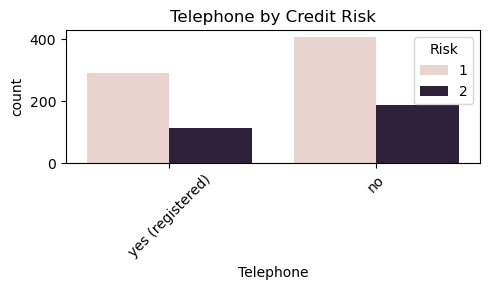


--- Foreign_Worker ---


Risk,1,2
Foreign_Worker,,
no,89.189189,10.810811
yes,69.262721,30.737279


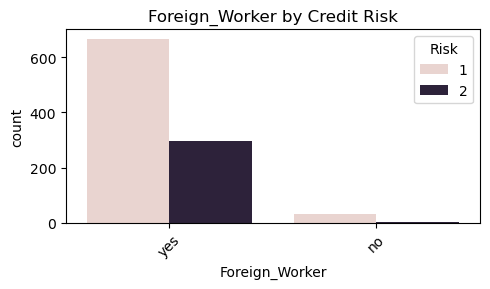


--- Other_Installment_Plans ---


Risk,1,2
Other_Installment_Plans,,
bank,58.992806,41.007194
none,72.481572,27.518428
stores,59.574468,40.425532


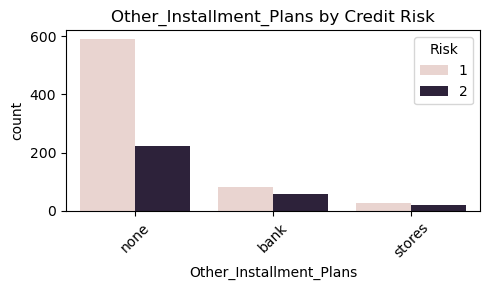


--- Credit_History ---


Risk,1,2
Credit_History,,
all paid at this bank,42.857143,57.142857
critical / other banks,82.935154,17.064846
current credits paid,68.113208,31.886792
delayed previously,68.181818,31.818182
no credits / all paid,37.500000,62.500000


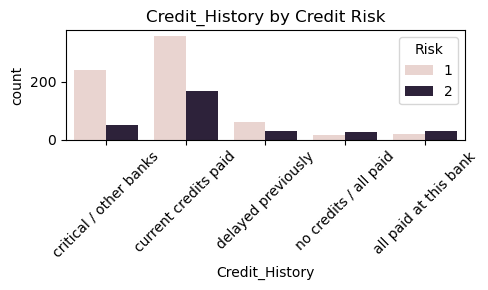


--- Property ---


Risk,1,2
Property,,
building society savings / life insurance,69.396552,30.603448
car or other (not in savings),69.277108,30.722892
real estate,78.723404,21.276596
unknown / no property,56.493506,43.506494


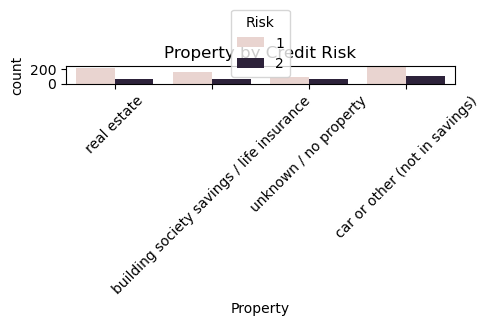


--- People_Liable ---


Risk                          1           2
People_Liable count  700.000000  300.000000
              mean     1.155714    1.153333
              std      0.362844    0.360911
              min      1.000000    1.000000
              25%      1.000000    1.000000
              50%      1.000000    1.000000
              75%      1.000000    1.000000
              max      2.000000    2.000000

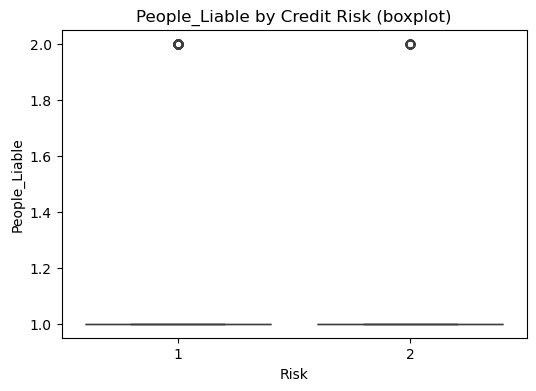

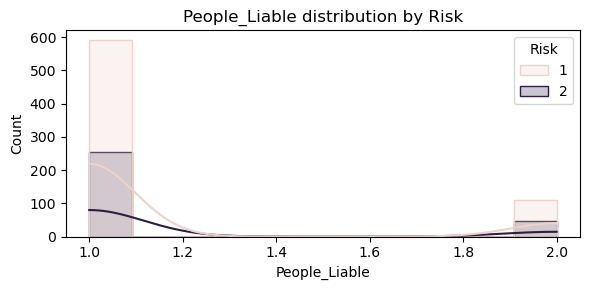


--- Residence_Since ---


Risk                            1           2
Residence_Since count  700.000000  300.000000
                mean     2.842857    2.850000
                std      1.108373    1.094605
                min      1.000000    1.000000
                25%      2.000000    2.000000
                50%      3.000000    3.000000
                75%      4.000000    4.000000
                max      4.000000    4.000000

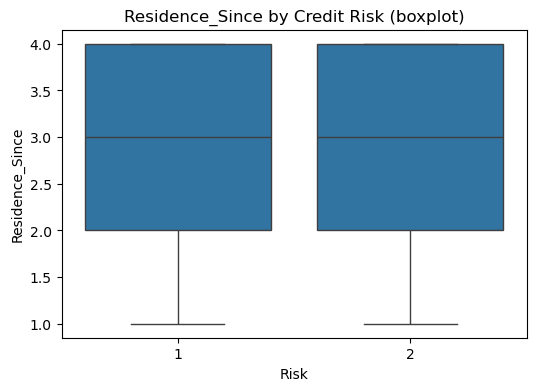

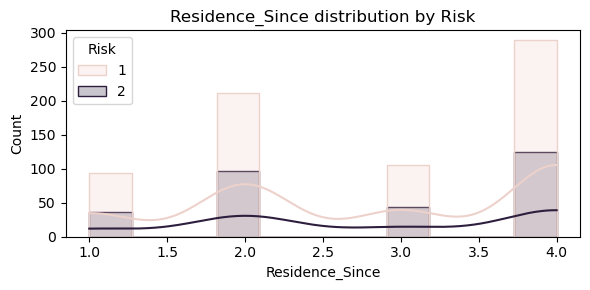


--- Installment_Rate ---


Risk                             1           2
Installment_Rate count  700.000000  300.000000
                 mean     2.920000    3.096667
                 std      1.128078    1.088395
                 min      1.000000    1.000000
                 25%      2.000000    2.000000
                 50%      3.000000    4.000000
                 75%      4.000000    4.000000
                 max      4.000000    4.000000

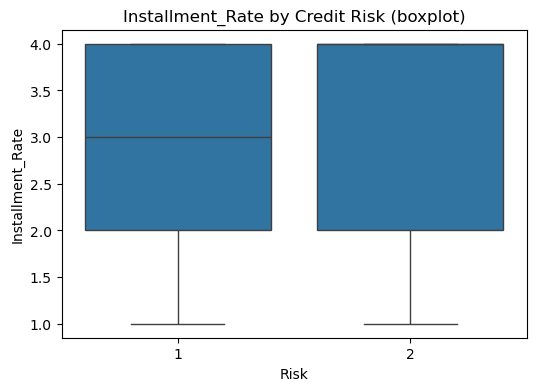

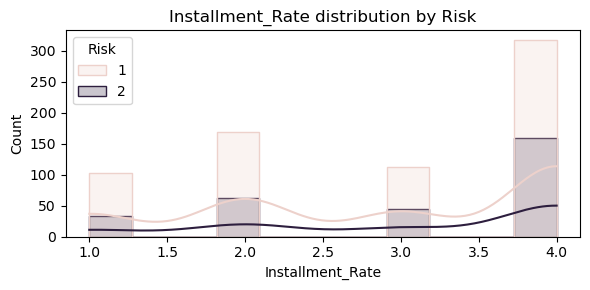


--- Existing_Credits ---


Risk                             1           2
Existing_Credits count  700.000000  300.000000
                 mean     1.424286    1.366667
                 std      0.584721    0.559702
                 min      1.000000    1.000000
                 25%      1.000000    1.000000
                 50%      1.000000    1.000000
                 75%      2.000000    2.000000
                 max      4.000000    4.000000

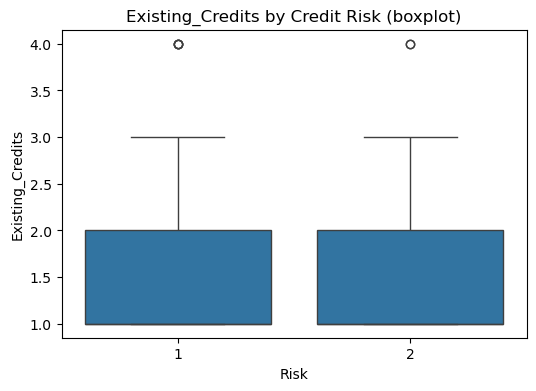

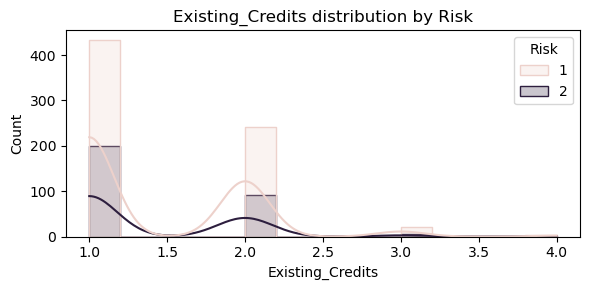

In [2882]:
# List of excluded or previously unexamined features
categorical_vars = [
    "Telephone", 
    "Foreign_Worker", 
    "Other_Installment_Plans", 
    "Credit_History", 
    "Property"  
]

numerical_vars = [
    "People_Liable", 
    "Residence_Since", 
    "Installment_Rate", 
    "Existing_Credits"
]

# Categorical features: frequency table and bar plot by credit risk
for var in categorical_vars:
    print(f"\n--- {var} ---")
    
    # Display default rate (%) by category
    display(pd.crosstab(df_raw[var], df_raw["Risk"], normalize='index') * 100)

    # Countplot by credit risk
    plt.figure(figsize=(5, 3))
    sns.countplot(x=var, hue="Risk", data=df_raw)
    plt.title(f"{var} by Credit Risk")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Numerical features: boxplot and histogram by credit risk
for var in numerical_vars:
    print(f"\n--- {var} ---")

    # Grouped descriptive statistics by Risk
    display(df_raw[[var, "Risk"]].groupby("Risk").describe().T)

    # Boxplot for variable by Risk
    plt.figure(figsize=(6, 4))
    sns.boxplot(x="Risk", y=var, data=df_raw)
    plt.title(f"{var} by Credit Risk (boxplot)")
    plt.show()

    # Histogram with KDE by Risk
    plt.figure(figsize=(6, 3))
    sns.histplot(data=df_raw, x=var, hue="Risk", kde=True, element="step")
    plt.title(f"{var} distribution by Risk")
    plt.tight_layout()
    plt.show()

### ✅ Conclusion

**Variables recommended for inclusion:**
- `Credit_History` ✅ (very strong signal)
- `Other_Installment_Plans` ✅ (clear separation)
- `Property` ✅ (moderate predictive power)

**Variables excluded:**
- `Telephone` (outdated, weak signal)
- `Foreign_Worker` (class imbalance)
- `People_Liable`, `Residence_Since` (no discrimination)
- `Installment_Rate` (weak, redundant)

## 6 Preprocessing data

In [2885]:
df_raw["Other_Debtors"].unique()

array(['none', 'guarantor', 'co-applicant'], dtype=object)

In [2886]:
loan_data_dummies = [pd.get_dummies(df_raw["Status_Checking_Account"], prefix = 'Account_status', prefix_sep = ':'),
                     pd.get_dummies(df_raw["Savings_Account"], prefix = 'Savings_Account', prefix_sep = ':'),
                     pd.get_dummies(df_raw["Employment_Since"], prefix = 'Employment_Since', prefix_sep = ':'),
                     pd.get_dummies(df_raw["Purpose"], prefix = 'Purpose', prefix_sep = ':'),
                     pd.get_dummies(df_raw["Credit_History"], prefix = 'History', prefix_sep = ':'),
                     pd.get_dummies(df_raw["Other_Installment_Plans"], prefix = 'Other_Installment', prefix_sep = ':'),
                     pd.get_dummies(df_raw["Property"], prefix = 'Property', prefix_sep = ':'),
                     pd.get_dummies(df_raw["Housing"], prefix = 'Housing', prefix_sep = ':'),
                     pd.get_dummies(df_raw["Personal_Status_Sex"], prefix = 'Personal_Status_Sex', prefix_sep = ':'),
                     pd.get_dummies(df_raw["Job"], prefix = 'Job', prefix_sep = ':'),
                     pd.get_dummies(df_raw["Other_Debtors"], prefix = 'Other_Debtors', prefix_sep = ':'),]
# We create dummy variables from all 11 original categorical independent variables, and save them into a list.

In [2887]:
loan_data_dummies = pd.concat(loan_data_dummies, axis = 1)

In [2888]:
df_raw = pd.concat([df_raw,loan_data_dummies], axis = 1)

In [2889]:
bool_cols = df_raw.select_dtypes(include='bool').columns

df_raw[bool_cols] = df_raw[bool_cols].astype(int)
df_raw.dtypes.value_counts()

int64     58
object    13
Name: count, dtype: int64

In [2890]:
# Define the target variable y
# Risk = 2 → default → encoded as 1
# Risk = 1 → no default → encoded as 0
df_raw["Risk"] = df_raw["Risk"].apply(lambda x: 1 if x == 2 else 0)

In [2891]:
# WoE function for discrete unordered variables
def woe_discrete(df, discrete_variabe_name, good_bad_variable_df):
    df = pd.concat([df[discrete_variabe_name], good_bad_variable_df], axis = 1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                    df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)
    df = df.iloc[:, [0, 1, 3]]
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1 - df['prop_good']) * df['n_obs']
    df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
    df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
    df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad'])
    df = df.sort_values(['WoE'])
    df = df.reset_index(drop = True)
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    df['IV'] = df['IV'].sum()
    return df

In [2892]:
def plot_by_woe(df_WoE, rotation_of_x_axis_labels = 0):
    x = np.array(df_WoE.iloc[:, 0].apply(str))
    # Turns the values of the column with index 0 to strings, makes an array from these strings, and passes it to variable x.
    y = df_WoE['WoE']
    # Selects a column with label 'WoE' and passes it to variable y.
    plt.figure(figsize=(18, 6))
    # Sets the graph size to width 18 x height 6.
    plt.plot(x, y, marker = 'o', linestyle = '--', color = 'k')
    # Plots the datapoints with coordiantes variable x on the x-axis and variable y on the y-axis.
    # Sets the marker for each datapoint to a circle, the style line between the points to dashed, and the color to black.
    plt.xlabel(df_WoE.columns[0])
    # Names the x-axis with the name of the column with index 0.
    plt.ylabel('Weight of Evidence')
    # Names the y-axis 'Weight of Evidence'.
    plt.title(str('Weight of Evidence by ' + df_WoE.columns[0]))
    # Names the grapth 'Weight of Evidence by ' the name of the column with index 0.
    plt.xticks(rotation = rotation_of_x_axis_labels)
    # Rotates the labels of the x-axis a predefined number of degrees.

In [2893]:
df_temp = woe_discrete(df_raw, 'Status_Checking_Account', df_raw['Risk'])
df_temp

,Status_Checking_Account,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,no checking account,394,0.116751,0.394,46.0,348.0,0.153333,0.497143,-1.176263,NaN,NaN,0.666012
1,>= 200 DM or salary assignment,63,0.222222,0.063,14.0,49.0,0.046667,0.070000,-0.405465,0.105471,0.770798,0.666012
2,0 <= ... < 200 DM,269,0.390335,0.269,105.0,164.0,0.350000,0.234286,0.401392,0.168112,0.806857,0.666012
3,0 DM,274,0.492701,0.274,135.0,139.0,0.450000,0.198571,0.818099,0.102366,0.416707,0.666012


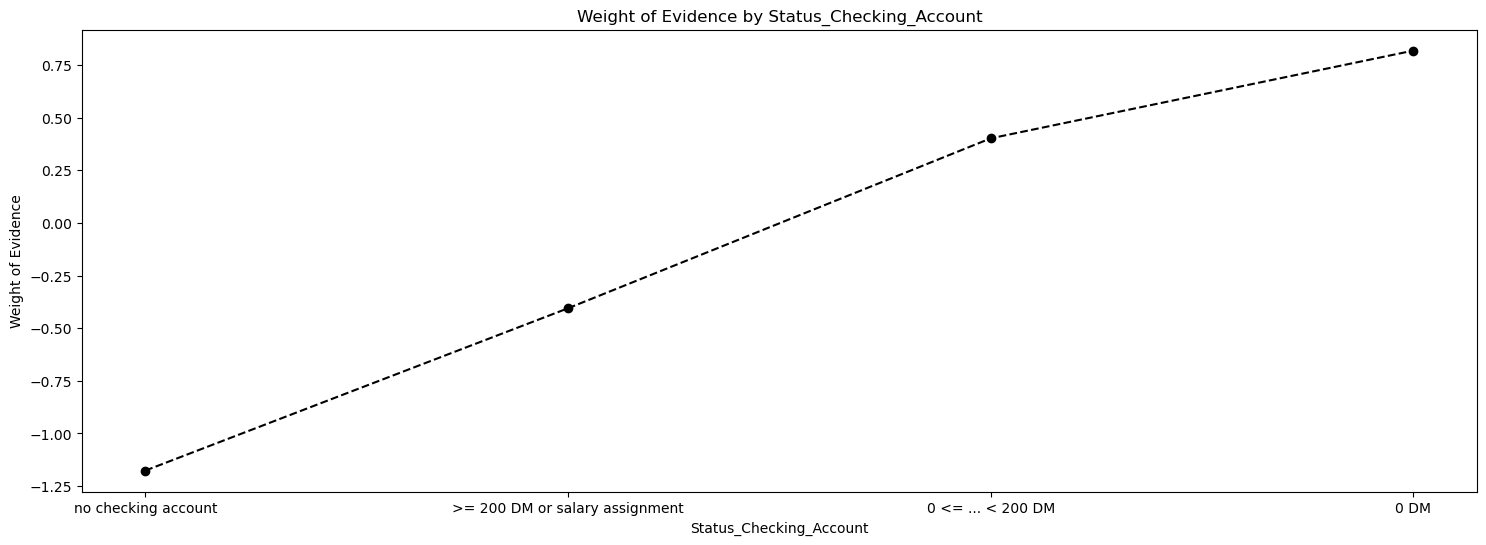

In [2894]:
plot_by_woe(df_temp)

In [2895]:
df_temp = woe_discrete(df_raw, 'Savings_Account', df_raw['Risk'])
df_temp

,Savings_Account,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,>= 1000 DM,48,0.125000,0.048,6.0,42.0,0.020000,0.060000,-1.098612,NaN,NaN,0.19601
1,500 <= ... < 1000 DM,63,0.174603,0.063,11.0,52.0,0.036667,0.074286,-0.706051,0.049603,0.392562,0.19601
2,unknown / no savings,183,0.174863,0.183,32.0,151.0,0.106667,0.215714,-0.704246,0.000260,0.001805,0.19601
3,100 <= ... < 500 DM,103,0.330097,0.103,34.0,69.0,0.113333,0.098571,0.139552,0.155234,0.843798,0.19601
4,< 100 DM,603,0.359867,0.603,217.0,386.0,0.723333,0.551429,0.271358,0.029770,0.131806,0.19601


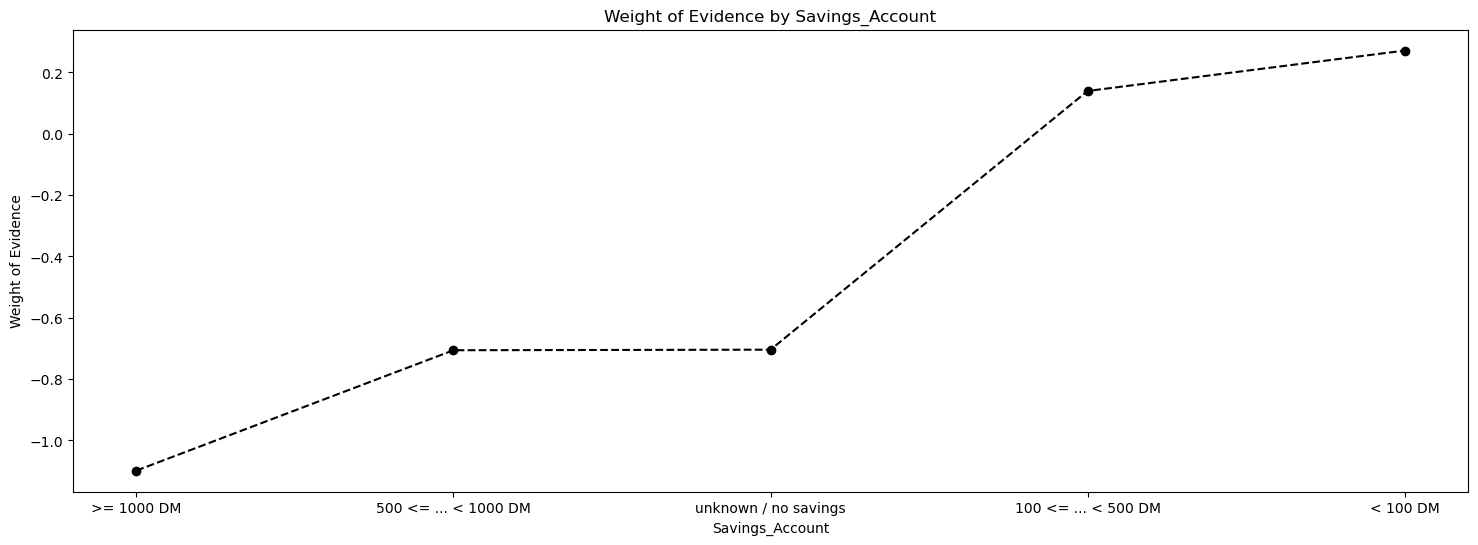

In [2896]:
plot_by_woe(df_temp)

In [2897]:
df_raw['Savings_Account:>=1000 DM_500<...<1000 DM'] = sum([df_raw['Savings_Account:>= 1000 DM'],df_raw['Savings_Account:500 <= ... < 1000 DM']])

In [2898]:
df_temp = woe_discrete(df_raw, 'Employment_Since', df_raw['Risk'])
df_temp

,Employment_Since,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,4 <= ... < 7 years,174,0.224138,0.174,39.0,135.0,0.130000,0.192857,-0.394415,NaN,NaN,0.086434
1,>= 7 years,253,0.252964,0.253,64.0,189.0,0.213333,0.270000,-0.235566,0.028826,0.158849,0.086434
2,1 <= ... < 4 years,339,0.306785,0.339,104.0,235.0,0.346667,0.335714,0.032103,0.053820,0.267669,0.086434
3,unemployed,62,0.370968,0.062,23.0,39.0,0.076667,0.055714,0.319230,0.064183,0.287127,0.086434
4,< 1 year,172,0.406977,0.172,70.0,102.0,0.233333,0.145714,0.470820,0.036009,0.151590,0.086434


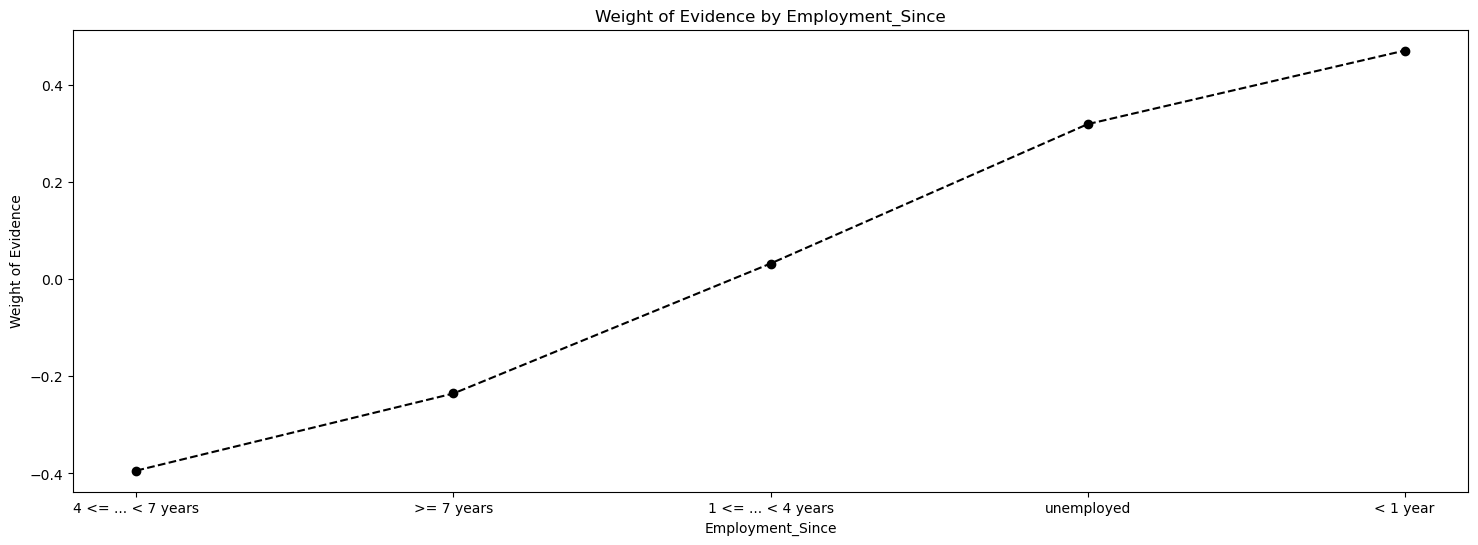

In [2899]:
plot_by_woe(df_temp)

In [2900]:
df_temp = woe_discrete(df_raw, 'Purpose', df_raw['Risk'])
df_temp

,Purpose,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,retraining,9,0.111111,0.009,1.0,8.0,0.003333,0.011429,-1.232144,NaN,NaN,0.169195
1,used car,103,0.165049,0.103,17.0,86.0,0.056667,0.122857,-0.773836,0.053937,0.458308,0.169195
2,radio/TV,280,0.221429,0.280,62.0,218.0,0.206667,0.311429,-0.410063,0.056380,0.363773,0.169195
3,furniture/equipment,181,0.320442,0.181,58.0,123.0,0.193333,0.175714,0.095557,0.099013,0.505619,0.169195
4,appliances,12,0.333333,0.012,4.0,8.0,0.013333,0.011429,0.154151,0.012891,0.058594,0.169195
5,business,97,0.350515,0.097,34.0,63.0,0.113333,0.090000,0.230524,0.017182,0.076373,0.169195
6,repairs,22,0.363636,0.022,8.0,14.0,0.026667,0.020000,0.287682,0.013121,0.057158,0.169195
7,new car,234,0.380342,0.234,89.0,145.0,0.296667,0.207143,0.359200,0.016706,0.071518,0.169195
8,others,12,0.416667,0.012,5.0,7.0,0.016667,0.010000,0.510826,0.036325,0.151625,0.169195
9,education,50,0.440000,0.050,22.0,28.0,0.073333,0.040000,0.606136,0.023333,0.095310,0.169195


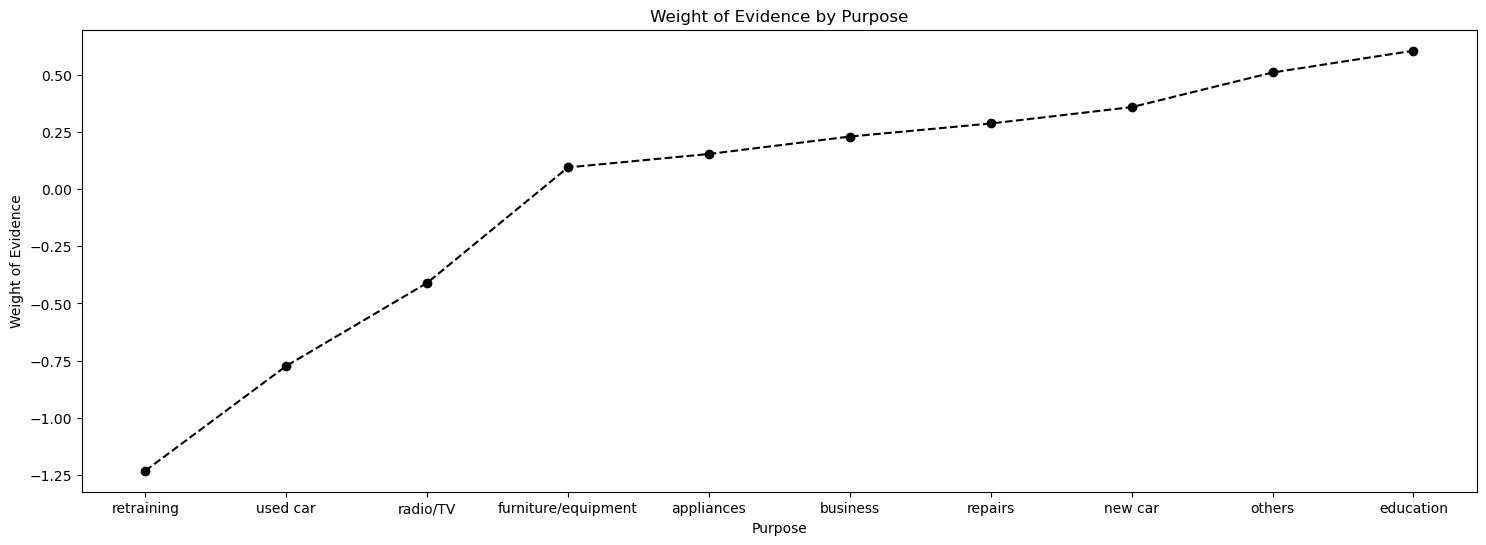

In [2901]:
plot_by_woe(df_temp)

In [2902]:
df_raw['Purpose:education_others'] = sum([df_raw['Purpose:education'],df_raw['Purpose:others']])
df_raw['Purpose:repairs_business_appliances'] = sum([df_raw['Purpose:repairs'],
                                                    df_raw['Purpose:business'],df_raw['Purpose:appliances']])
df_raw['Purpose:used car_retraining'] = sum([df_raw['Purpose:used car'],df_raw['Purpose:retraining']])

In [2903]:
df_temp = woe_discrete(df_raw, 'Credit_History', df_raw['Risk'])
df_temp

,Credit_History,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,critical / other banks,293,0.170648,0.293,50.0,243.0,0.166667,0.347143,-0.733741,NaN,NaN,0.293234
1,delayed previously,88,0.318182,0.088,28.0,60.0,0.093333,0.085714,0.085158,0.147533,0.818898,0.293234
2,current credits paid,530,0.318868,0.530,169.0,361.0,0.563333,0.515714,0.088319,0.000686,0.003161,0.293234
3,all paid at this bank,49,0.571429,0.049,28.0,21.0,0.093333,0.030000,1.134980,0.252561,1.046661,0.293234
4,no credits / all paid,40,0.625000,0.040,25.0,15.0,0.083333,0.021429,1.358123,0.053571,0.223144,0.293234


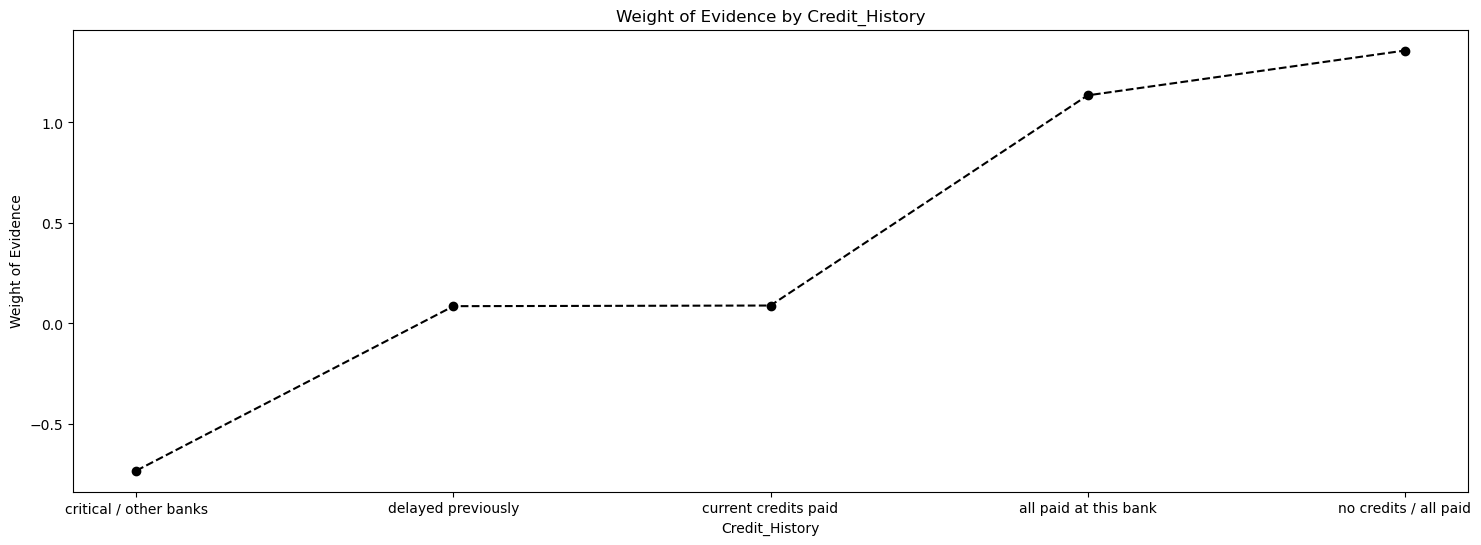

In [2904]:
plot_by_woe(df_temp)

In [2905]:
df_raw['History:no credits_all paid_all paid at this bank'] = sum([df_raw['History:no credits / all paid'],df_raw['History:all paid at this bank']])

In [2906]:
df_temp = woe_discrete(df_raw, 'Other_Installment_Plans', df_raw['Risk'])
df_temp

,Other_Installment_Plans,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,none,814,0.275184,0.814,224.0,590.0,0.746667,0.842857,-0.121179,NaN,NaN,0.057615
1,stores,47,0.404255,0.047,19.0,28.0,0.063333,0.040000,0.459532,0.129071,0.580711,0.057615
2,bank,139,0.410072,0.139,57.0,82.0,0.190000,0.117143,0.483630,0.005817,0.024098,0.057615


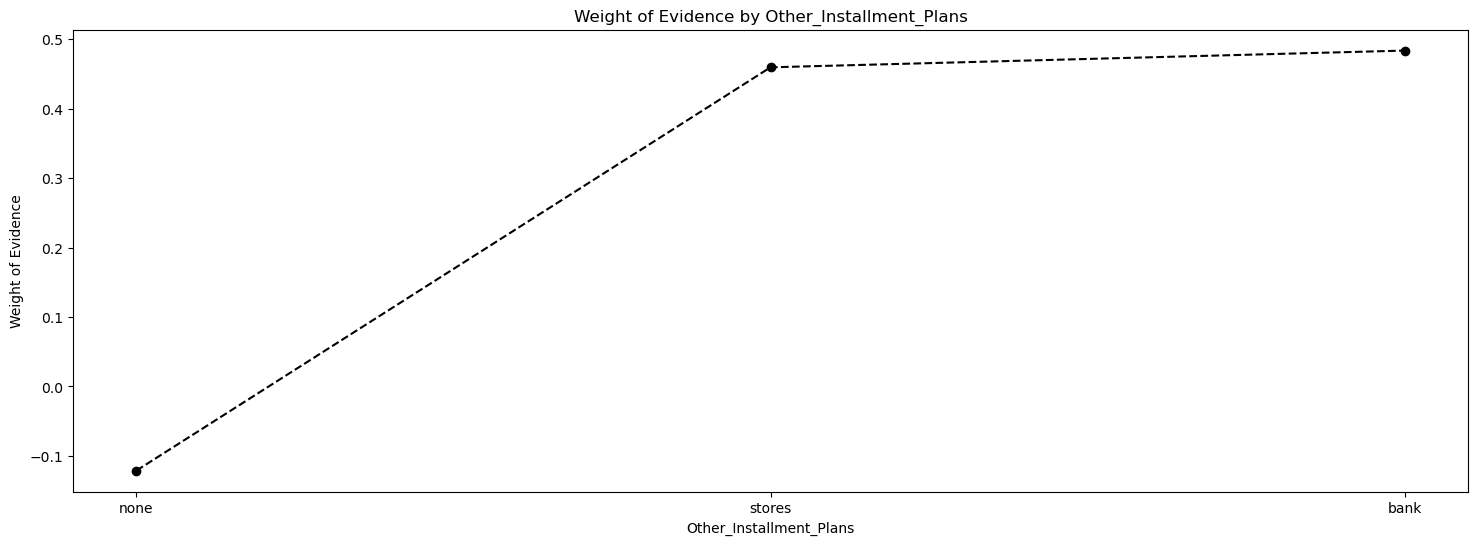

In [2907]:
plot_by_woe(df_temp)

In [2908]:
df_temp = woe_discrete(df_raw, 'Property', df_raw['Risk'])
df_temp

,Property,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,real estate,282,0.212766,0.282,60.0,222.0,0.200000,0.317143,-0.461035,NaN,NaN,0.112638
1,building society savings / life insurance,232,0.306034,0.232,71.0,161.0,0.236667,0.230000,0.028573,0.093269,0.489608,0.112638
2,car or other (not in savings),332,0.307229,0.332,102.0,230.0,0.340000,0.328571,0.034191,0.001194,0.005618,0.112638
3,unknown / no property,154,0.435065,0.154,67.0,87.0,0.223333,0.124286,0.586082,0.127836,0.551891,0.112638


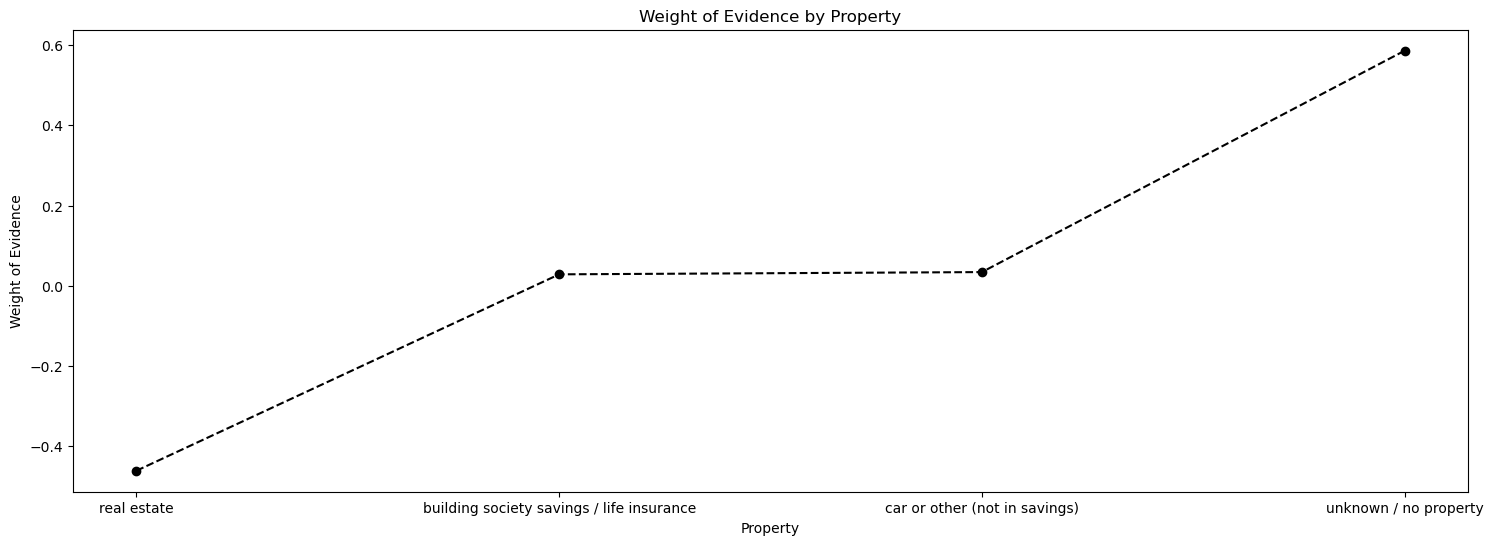

In [2909]:
plot_by_woe(df_temp)

In [2910]:
df_temp = woe_discrete(df_raw, 'Housing', df_raw['Risk'])
df_temp

,Housing,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,own,713,0.260870,0.713,186.0,527.0,0.620000,0.752857,-0.194156,NaN,NaN,0.083293
1,rent,179,0.391061,0.179,70.0,109.0,0.233333,0.155714,0.404445,0.130192,0.598601,0.083293
2,for free,108,0.407407,0.108,44.0,64.0,0.146667,0.091429,0.472604,0.016346,0.068159,0.083293


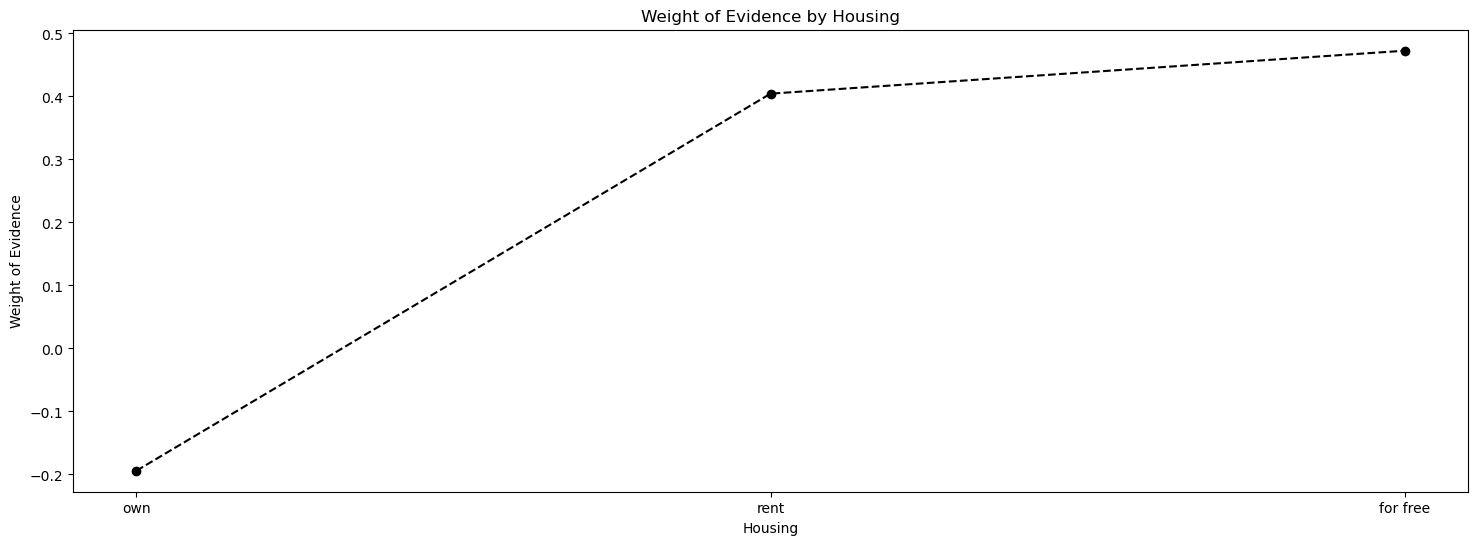

In [2911]:
plot_by_woe(df_temp)

In [2912]:
df_temp = woe_discrete(df_raw, 'Personal_Status_Sex', df_raw['Risk'])
df_temp

,Personal_Status_Sex,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,male single,548,0.266423,0.548,146.0,402.0,0.486667,0.574286,-0.165548,NaN,NaN,0.044671
1,male married/widowed,92,0.271739,0.092,25.0,67.0,0.083333,0.095714,-0.138519,0.005316,0.027029,0.044671
2,female div/sep/married,310,0.351613,0.310,109.0,201.0,0.363333,0.287143,0.235341,0.079874,0.373860,0.044671
3,male divorced/separated,50,0.400000,0.050,20.0,30.0,0.066667,0.042857,0.441833,0.048387,0.206492,0.044671


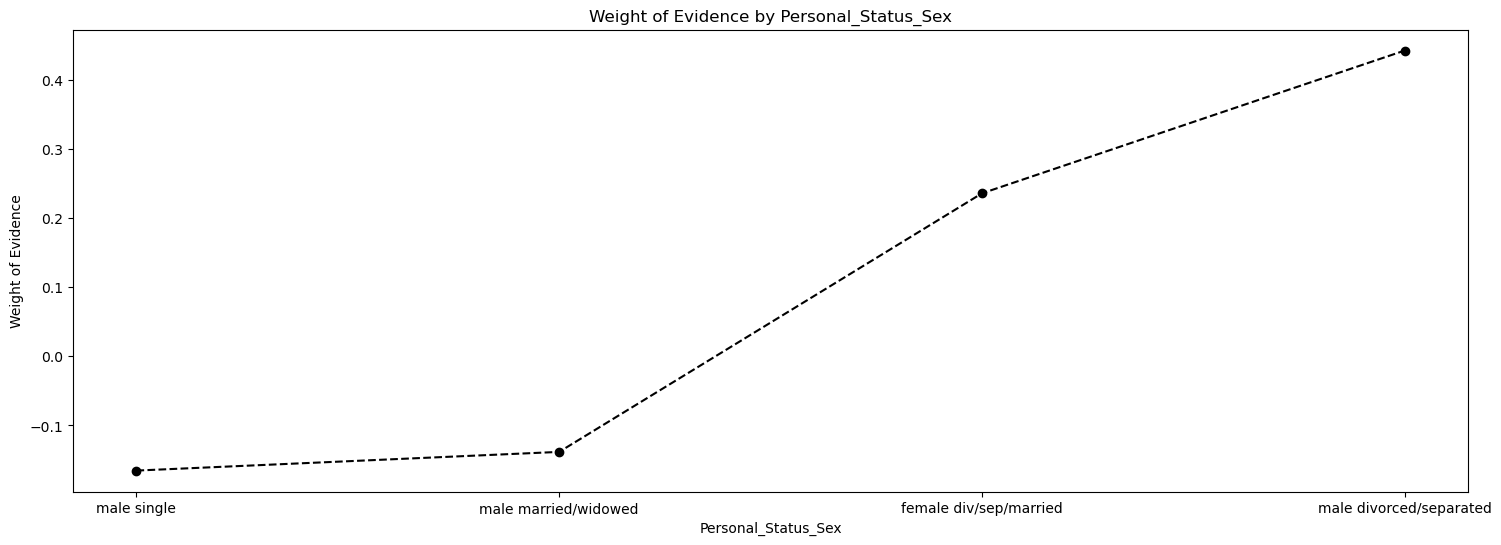

In [2913]:
plot_by_woe(df_temp)

In [2914]:
df_temp = woe_discrete(df_raw, 'Job', df_raw['Risk'])
df_temp

,Job,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,unskilled (resident),200,0.280000,0.200,56.0,144.0,0.186667,0.205714,-0.097164,NaN,NaN,0.008763
1,skilled employee / official,630,0.295238,0.630,186.0,444.0,0.620000,0.634286,-0.022780,0.015238,0.074384,0.008763
2,unemployed / unskilled (non-resident),22,0.318182,0.022,7.0,15.0,0.023333,0.021429,0.085158,0.022944,0.107938,0.008763
3,management / self-employed / highly qualified,148,0.344595,0.148,51.0,97.0,0.170000,0.138571,0.204413,0.026413,0.119255,0.008763


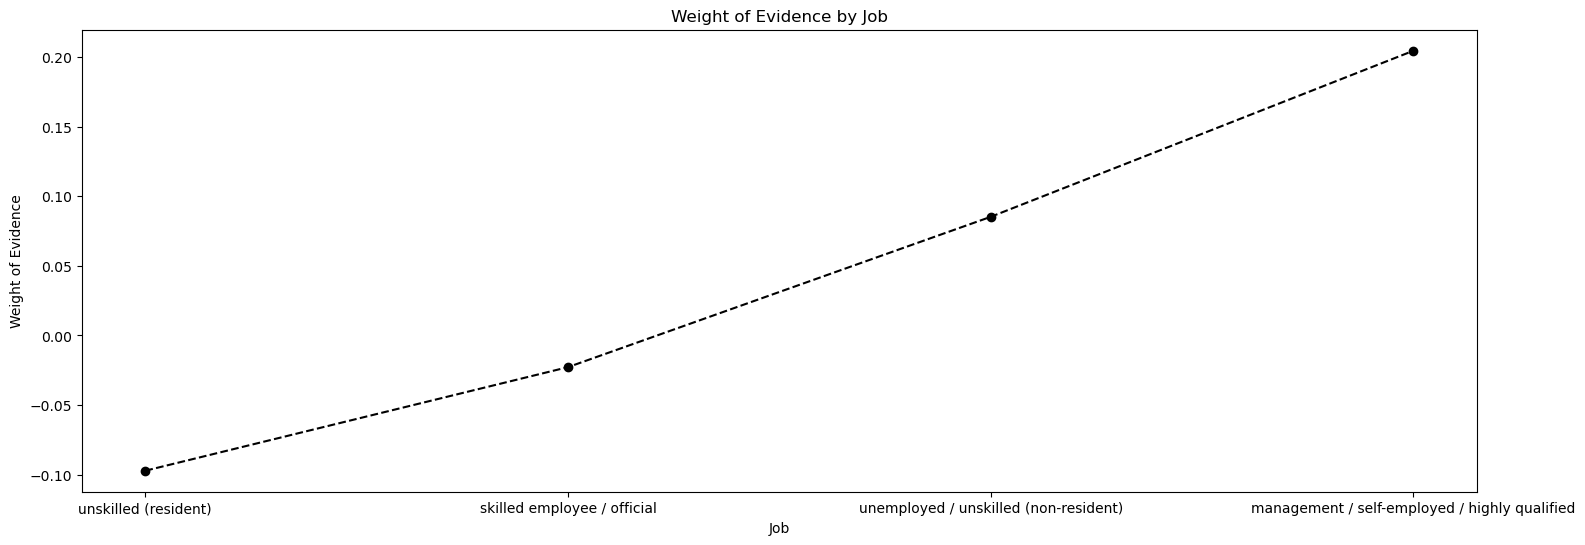

In [2915]:
plot_by_woe(df_temp)

In [2916]:
df_temp = woe_discrete(df_raw, 'Other_Debtors', df_raw['Risk'])
df_temp

,Other_Debtors,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,guarantor,52,0.192308,0.052,10.0,42.0,0.033333,0.060000,-0.587787,NaN,NaN,0.032019
1,none,907,0.299890,0.907,272.0,635.0,0.906667,0.907143,-0.000525,0.107582,0.587262,0.032019
2,co-applicant,41,0.439024,0.041,18.0,23.0,0.060000,0.032857,0.602175,0.139135,0.602700,0.032019


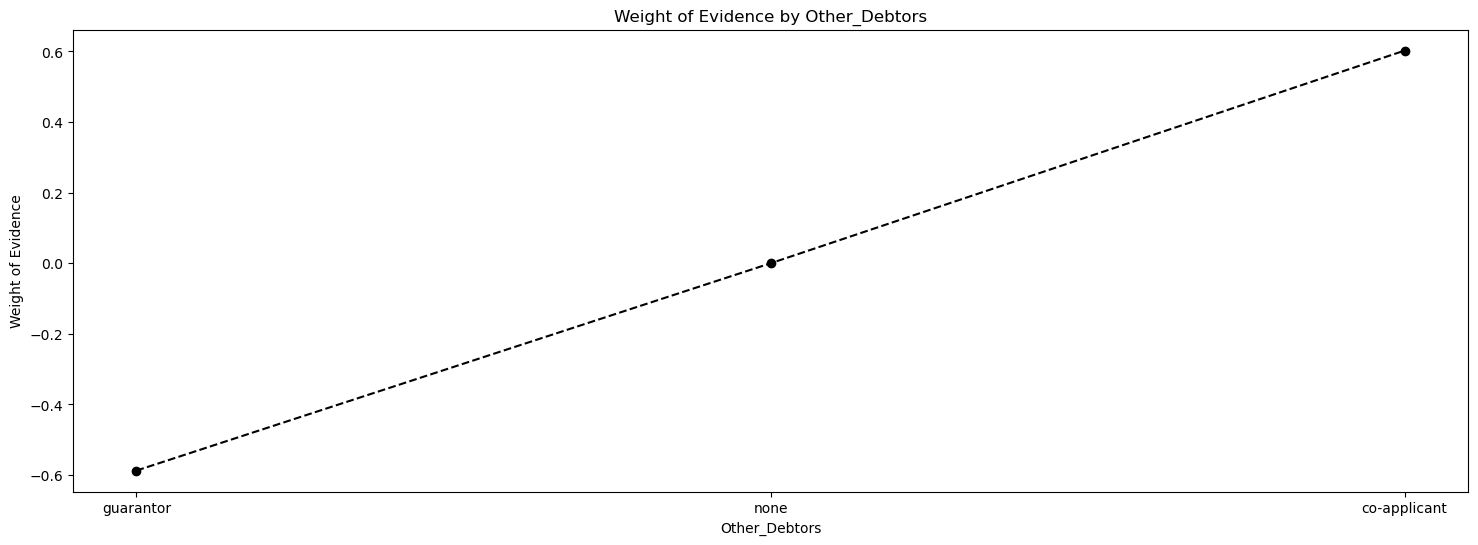

In [2917]:
plot_by_woe(df_temp)

In [2918]:
list_of_ref_cat = ['Account_status:no checking account', 'Savings_Account:>=1000 DM_500<...<1000 DM','Employment_Since:4 <= ... < 7 years','Purpose:education_others',
                   'History:critical / other banks','Other_Installment:none',
                   'Property:real estate','Housing:own','Personal_Status_Sex:male single',
                   'Other_Debtors:guarantor']
list_of_cat_to_del = ['Savings_Account:>= 1000 DM', 'Savings_Account:500 <= ... < 1000 DM','Purpose:repairs','Purpose:business','Purpose:appliances',
                     'Purpose:used car','Purpose:retraining','Purpose:education','Purpose:others',
                     'History:no credits / all paid','History:all paid at this bank',
                     'Job:management / self-employed / highly qualified','Job:unemployed / unskilled (non-resident)',
                     'Job:skilled employee / official','Job:unskilled (resident)']

var_to_add = ['Savings_Account:>=1000 DM_500<...<1000 DM','Purpose:education_others',
                                     'Purpose:repairs_business_appliances','Purpose:used car_retraining',
                                     'History:no credits_all paid_all paid at this bank','Credit_Amount', 'Duration_Months', 'Age']

### Selecting features

In [2920]:
df_raw_prep_with_ref = df_raw.loc[:,list(loan_data_dummies.columns) + var_to_add]

In [2921]:
df_raw_prep = df_raw_prep_with_ref.drop(list_of_ref_cat + list_of_cat_to_del, axis = 1)

In [2922]:
df_raw_prep = df_raw_prep[sorted(df_raw_prep.columns)]

In [2923]:
df_raw_prep.columns

Index(['Account_status:0 <= ... < 200 DM', 'Account_status:0 DM',
       'Account_status:>= 200 DM or salary assignment', 'Age', 'Credit_Amount',
       'Duration_Months', 'Employment_Since:1 <= ... < 4 years',
       'Employment_Since:< 1 year', 'Employment_Since:>= 7 years',
       'Employment_Since:unemployed', 'History:current credits paid',
       'History:delayed previously',
       'History:no credits_all paid_all paid at this bank', 'Housing:for free',
       'Housing:rent', 'Other_Debtors:co-applicant', 'Other_Debtors:none',
       'Other_Installment:bank', 'Other_Installment:stores',
       'Personal_Status_Sex:female div/sep/married',
       'Personal_Status_Sex:male divorced/separated',
       'Personal_Status_Sex:male married/widowed',
       'Property:building society savings / life insurance',
       'Property:car or other (not in savings)',
       'Property:unknown / no property', 'Purpose:furniture/equipment',
       'Purpose:new car', 'Purpose:radio/TV',
       'Purpo

In [2924]:
df_raw_prep.head()

,Account_status:0 <= ... < 200 DM,Account_status:0 DM,Account_status:>= 200 DM or salary assignment,Age,Credit_Amount,Duration_Months,Employment_Since:1 <= ... < 4 years,Employment_Since:< 1 year,Employment_Since:>= 7 years,Employment_Since:unemployed,History:current credits paid,History:delayed previously,History:no credits_all paid_all paid at this bank,Housing:for free,Housing:rent,Other_Debtors:co-applicant,Other_Debtors:none,Other_Installment:bank,Other_Installment:stores,Personal_Status_Sex:female div/sep/married,Personal_Status_Sex:male divorced/separated,Personal_Status_Sex:male married/widowed,Property:building society savings / life insurance,Property:car or other (not in savings),Property:unknown / no property,Purpose:furniture/equipment,Purpose:new car,Purpose:radio/TV,Purpose:repairs_business_appliances,Purpose:used car_retraining,Savings_Account:100 <= ... < 500 DM,Savings_Account:< 100 DM,Savings_Account:unknown / no savings
0,0,1,0,67,1169,6,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
1,1,0,0,22,5951,48,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
2,0,0,0,49,2096,12,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0,1,0,45,7882,42,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0
4,0,1,0,53,4870,24,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0


In [2925]:
# To check we didn't omit any important modality
dummies_initiales = set(loan_data_dummies.columns)
colonnes_finales = set(df_raw_prep.columns)
colonnes_manquantes = dummies_initiales - colonnes_finales

print("Omitted or deleted modalities :")
#for col in sorted(colonnes_manquantes):
#    print("-", col)

Omitted or deleted modalities :


### Checking we are not omitting any important dummy variable

In [2927]:
# Vérification que chaque colonne manquante est bien dans les listes de référence ou à supprimer
modalites_non_justifiees = []

for col in colonnes_manquantes:
    if col not in list_of_ref_cat and col not in list_of_cat_to_del:
        modalites_non_justifiees.append(col)

# Affichage du résultat
if modalites_non_justifiees:
    print("⚠️ Modalities missing but not accounted for:")
    for col in sorted(modalites_non_justifiees):
        print("-", col)
else:
    print("✅ All omitted modalities are accounted for (in ref or to delete lists).")

✅ All omitted modalities are accounted for (in ref or to delete lists).


In [2928]:
#list_of_ref_cat = ['Account_status:no checking account', 'Savings_Account:>=1000 DM_500<...<1000 DM','Employment_Since:4 <= ... < 7 years','Purpose:education_others',
#                  'History:critical / other banks','Other_Installment:none',
#                   'Property:real estate','Housing:own','Personal_Status_Sex:male single',
#                   'Other_Debtors:guarantor']
#list_of_cat_to_del = ['Savings_Account:>= 1000 DM', 'Savings_Account:500 <= ... < 1000 DM','Purpose:repairs','Purpose:business','Purpose:appliances',
#                     'Purpose:used car','Purpose:retraining','Purpose:education','Purpose:others',
#                     'History:no credits / all paid','History:all paid at this bank',
#                     'Job:management / self-employed / highly qualified','Job:unemployed / unskilled (non-resident)',
#                     'Job:skilled employee / official','Job:unskilled (resident)']

In [2929]:
# Constant column check
zero_variance_cols = [col for col in df_raw_prep.columns if df_raw_prep[col].nunique() <= 1]
print("Constant columns:", zero_variance_cols)

Constant columns: []


### Checking for multicolinearity with VIF

In [2931]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

# On ajoute une constante temporairement pour les besoins du VIF
from statsmodels.tools.tools import add_constant
X_vif = add_constant(df_raw_prep)

# Calcul des VIFs
vif_data = pd.DataFrame()
vif_data["Feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

# Trié par VIF décroissant pour identifier les redondances
vif_data.sort_values("VIF", ascending=False)

,Feature,VIF
0,const,83.504131
28,Purpose:radio/TV,4.362631
27,Purpose:new car,3.836172
26,Purpose:furniture/equipment,3.449539
25,Property:unknown / no property,3.200408
29,Purpose:repairs_business_appliances,2.925161
14,Housing:for free,2.787390
32,Savings_Account:< 100 DM,2.743142
30,Purpose:used car_retraining,2.615307
33,Savings_Account:unknown / no savings,2.249355


In [2932]:
# Define the feature matrix X (all model inputs)
X = df_raw_prep.copy()

# Define the target column y
y = df_raw['Risk']


In [2933]:
# Define the list of continuous variables to scale
cols_to_scale = ["Credit_Amount", "Duration_Months", "Age"]

# Initialize the scaler
scaler_pd = StandardScaler()

# Apply scaling to the selected columns and update in the main DataFrame
X[cols_to_scale] = scaler_pd.fit_transform(X[cols_to_scale])

### Preprocessing Summary

This section summarizes all the preprocessing steps applied to prepare the dataset for logistic regression modeling.

#### ✅ Feature Selection
- A total of 14 explanatory variables were selected based on exploratory data analysis (EDA), Weight of Evidence (WOE) patterns, and domain relevance.
- Selected features include both standardized continuous variables (`Credit_Amount`, `Duration_Months`, `Age`) and transformed categorical variables.

#### ✅ WOE-Based Grouping & Dummy Encoding
- Categorical variables were transformed using `pd.get_dummies()` after grouping modalities with similar WOE values.
- Rare or unstable categories (based on frequency or irregular WOE) were either merged with similar classes or excluded.
- A reference category was explicitly removed from each categorical group to prevent multicollinearity.

#### ✅ Binary Format Check
- All dummy and grouped columns were verified to be strictly binary (0 or 1).
- A custom check confirmed that no dummy variable had unexpected values above 1 or inconsistent sums across groups.

#### ✅ Standardization of Continuous Features
- Continuous variables (`Credit_Amount`, `Duration_Months`, `Age`) were standardized using `StandardScaler` to ensure numerical stability and improve model convergence.
- Categorical variables (dummies) were not scaled.

#### ✅ Multicollinearity Check
- Variance Inflation Factor (VIF) was computed for all features in the final dataset.
- All VIF values (excluding the intercept) were below 5, with most values close to 1.
- This confirms the absence of problematic multicollinearity and validates the grouping and encoding strategy.

#### ✅ Final Dataset Assembly
- The final dataset `df_raw_prep` includes:
  - All relevant binary dummy variables,
  - Grouped feature columns based on WOE profiles (e.g., `Purpose_grouped`, `Credit_History_grouped`, etc.),
  - Scaled continuous variables.
- The feature matrix `X` and binary target variable `y` were defined.
- The dataset contains no missing values, no constant columns, and is ready for supervised classification models.

This preprocessing pipeline ensures statistical robustness, interpretability, and compatibility with logistic regression and other classification algorithms.

### Train/Test Split

Before modeling, we split the dataset into:
- 80% training data (used to fit the model),
- 20% test data (used to evaluate generalization).

The split is stratified on the target to preserve class proportions.

In [2936]:
# 80% training / 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

## 7.Modeling - Probability of Default (PD)

### 7.1 Logistic Regression – Model Training

We trained and compared three logistic regression models using the `statsmodels` library:

- A **full model** with all preprocessed features (dummies and scaled numericals),
- A **stepwise-selected model** via **grouped forward AIC selection**,
- A **final model** trained on **SMOTE-resampled data** with **class-based weighting** to improve recall on the minority class.

---

**Full Model Performance:**
- Pseudo R²: 0.2376  
- AIC: 813.15  
- BIC: 972.42  


In [2939]:
import statsmodels.api as sm

# Add Intercept
X_train_const = sm.add_constant(X_train)

# Fit logistic regression model
logit_model = sm.Logit(y_train, X_train_const)
logit_result = logit_model.fit()

# summary output
logit_result.summary()


Optimization terminated successfully.
         Current function value: 0.465717
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   Risk   No. Observations:                  800
Model:                          Logit   Df Residuals:                      766
Method:                           MLE   Df Model:                           33
Date:                Jeu, 29 mai 2025   Pseudo R-squ.:                  0.2376
Time:                        20:42:52   Log-Likelihood:                -372.57
converged:                       True   LL-Null:                       -488.69
Covariance Type:            nonrobust   LLR p-value:                 8.377e-32
======================================================================================================================
                                                         coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------
const                                                 -4.3626      0.799     -5.462      0.000      -5.928      -2.797
Account_status:0 <= ... < 200 DM                       1.1041      0.249      4.429      0.000       0.616       1.593
Account_status:0 DM                                    1.5605      0.250      6.235      0.000       1.070       2.051
Account_status:>= 200 DM or salary assignment          0.6706      0.402      1.668      0.095      -0.117       1.458
Age                                                   -0.0331      0.113     -0.293      0.770      -0.255       0.188
Credit_Amount                                          0.0668      0.130      0.514      0.607      -0.188       0.322
Duration_Months                                        0.4719      0.123      3.833      0.000       0.231       0.713
Employment_Since:1 <= ... < 4 years                    0.4689      0.292      1.605      0.108      -0.104       1.041
Employment_Since:< 1 year                              0.8571      0.322      2.659      0.008       0.225       1.489
Employment_Since:>= 7 years                            0.6063      0.323      1.879      0.060      -0.026       1.239
Employment_Since:unemployed                            0.8048      0.455      1.769      0.077      -0.087       1.697
History:current credits paid                           0.7417      0.236      3.141      0.002       0.279       1.205
History:delayed previously                             0.6320      0.369      1.714      0.087      -0.091       1.355
History:no credits_all paid_all paid at this bank      1.2124      0.354      3.422      0.001       0.518       1.907
Housing:for free                                      -0.7118      0.502     -1.419      0.156      -1.695       0.271
Housing:rent                                           0.5076      0.245      2.071      0.038       0.027       0.988
Other_Debtors:co-applicant                             1.0110      0.630      1.605      0.108      -0.224       2.245
Other_Debtors:none                                     0.7438      0.484      1.538      0.124      -0.204       1.691
Other_Installment:bank                                 0.6874      0.255      2.697      0.007       0.188       1.187
Other_Installment:stores                               0.4320      0.410      1.054      0.292      -0.371       1.235
Personal_Status_Sex:female div/sep/married             0.4596      0.220      2.091      0.036       0.029       0.890
Personal_Status_Sex:male divorced/separated            0.7684      0.406      1.890      0.059      -0.028       1.565
Personal_Status_Sex:male married/widowed               0.3808      0.327      1.165      0.244      -0.260       1.022
Property:building society savings / life insurance     0.2192      0.276      0.794      0.427      -0.322       0.760
Property:car or other (not i

In [2940]:
print(f'Model AIC is : {logit_result.aic}')
print(f'Model BIC is : {logit_result.bic}')

Model AIC is : 813.1475844953084
Model BIC is : 972.4243832360179


**Grouped Stepwise AIC Selection:**

To improve interpretability and reduce model complexity, we applied a **grouped forward stepwise selection** strategy:  

- Dummy variables from the same categorical feature were grouped together.  
- At each step, the group whose inclusion led to the greatest decrease in AIC was added to the model.  
- The process stopped when no remaining group improved the AIC.

---

**Stepwise-Selected Model Performance:**
- Pseudo R²: 0.2341  
- AIC: 808.56  
- BIC: 949.09  
- Number of variables: 29  

This model maintained nearly the same predictive power as the full model while improving interpretability.


In [2942]:
from collections import defaultdict

def generate_grouped_vars(X):
    grouped_vars = defaultdict(list)

    for col in X.columns:
        if ':' in col:
            var_base = col.split(':')[0]  # ex: "Purpose"
        else:
            var_base = col  # pour les variables numériques ou déjà bien nommées
        grouped_vars[var_base].append(col)

    return dict(grouped_vars)

grouped_vars = generate_grouped_vars(X_train)
for var, cols in grouped_vars.items():
    print(f"{var} : {cols}")

Account_status : ['Account_status:0 <= ... < 200 DM', 'Account_status:0 DM', 'Account_status:>= 200 DM or salary assignment']
Age : ['Age']
Credit_Amount : ['Credit_Amount']
Duration_Months : ['Duration_Months']
Employment_Since : ['Employment_Since:1 <= ... < 4 years', 'Employment_Since:< 1 year', 'Employment_Since:>= 7 years', 'Employment_Since:unemployed']
History : ['History:current credits paid', 'History:delayed previously', 'History:no credits_all paid_all paid at this bank']
Housing : ['Housing:for free', 'Housing:rent']
Other_Debtors : ['Other_Debtors:co-applicant', 'Other_Debtors:none']
Other_Installment : ['Other_Installment:bank', 'Other_Installment:stores']
Personal_Status_Sex : ['Personal_Status_Sex:female div/sep/married', 'Personal_Status_Sex:male divorced/separated', 'Personal_Status_Sex:male married/widowed']
Property : ['Property:building society savings / life insurance', 'Property:car or other (not in savings)', 'Property:unknown / no property']
Purpose : ['Purpose

In [2943]:
def stepwise_grouped_logit(X, y, grouped_vars, verbose=True):
    import statsmodels.api as sm
    included_groups = []
    current_aic = np.inf
    best_model = None

    while True:
        changed = False
        candidates = list(set(grouped_vars.keys()) - set(included_groups))
        aic_with_candidates = {}

        # Tentative d'ajout de chaque groupe non inclus
        for group in candidates:
            cols_to_test = []
            for g in included_groups + [group]:
                cols_to_test.extend(grouped_vars[g])
            try:
                model = sm.Logit(y, sm.add_constant(X[cols_to_test])).fit(disp=0)
                aic_with_candidates[group] = model.aic
            except:
                continue  # Skip if model fails (e.g., colinéarité)

        if not aic_with_candidates:
            break

        # Sélection du meilleur groupe à ajouter
        best_group = min(aic_with_candidates, key=aic_with_candidates.get)
        best_aic = aic_with_candidates[best_group]

        if best_aic < current_aic:
            included_groups.append(best_group)
            current_aic = best_aic
            best_model = sm.Logit(y, sm.add_constant(X[[col for g in included_groups for col in grouped_vars[g]]])).fit(disp=0)
            changed = True
            if verbose:
                print(f"Ajout de groupe : {best_group}, AIC = {best_aic:.2f}")
        else:
            break

    return included_groups, best_model

In [2944]:
included_groups, final_model = stepwise_grouped_logit(X_train, y_train, grouped_vars)
print("\nVariables sélectionnées (groupes) :", included_groups)
print(final_model.summary())

Ajout de groupe : Account_status, AIC = 888.05
Ajout de groupe : Duration_Months, AIC = 862.78
Ajout de groupe : History, AIC = 845.60
Ajout de groupe : Savings_Account, AIC = 833.70
Ajout de groupe : Purpose, AIC = 823.49
Ajout de groupe : Employment_Since, AIC = 818.14
Ajout de groupe : Other_Installment, AIC = 815.43
Ajout de groupe : Housing, AIC = 812.11
Ajout de groupe : Property, AIC = 809.16
Ajout de groupe : Personal_Status_Sex, AIC = 808.56

Variables sélectionnées (groupes) : ['Account_status', 'Duration_Months', 'History', 'Savings_Account', 'Purpose', 'Employment_Since', 'Other_Installment', 'Housing', 'Property', 'Personal_Status_Sex']
                           Logit Regression Results                           
Dep. Variable:                   Risk   No. Observations:                  800
Model:                          Logit   Df Residuals:                      770
Method:                           MLE   Df Model:                           29
Date:                Jeu, 

In [2945]:
print(f'Model AIC is : {final_model.aic}')
print(f'Model BIC is : {final_model.bic}')

Model AIC is : 808.5615653279983
Model BIC is : 949.0999171580361


In [2946]:
included_modalities = [col 
                       for group in included_groups 
                       for col in grouped_vars[group]]

all_modalities = [col 
                  for group in grouped_vars 
                  for col in grouped_vars[group]]

excluded_modalities = list(set(all_modalities) - set(included_modalities))

In [2947]:
X_train = X_train[included_modalities]
X_test = X_test[included_modalities]

**Final Model – SMOTE + Weighting:**

To further improve sensitivity to the minority class (class 1), we retrained the model on **SMOTE-resampled data**, and applied **frequency-based class weighting**:

- SMOTE was used to balance the training dataset.
- Weights were computed to reflect the inverse class frequencies.
- The model was trained on the same 29 variables selected via stepwise AIC.

This final model preserves the economic interpretability of a 0.5 threshold while significantly increasing recall for class 1 that we can see in model evaluation section.

In [2949]:
from collections import Counter

# Option simple : poids inverses à la fréquence, ou ratio de coût
counts = Counter(y_train)
weights_res = y_train.map(lambda y: len(y_train) / (2 * counts[y]))


In [2950]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

X_res_const = sm.add_constant(X_res)
model_resampled = sm.Logit(y_res, X_res_const, freq_weights=weights_res).fit()
model_resampled.summary()

Optimization terminated successfully.
         Current function value: 0.517514
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   Risk   No. Observations:                 1120
Model:                          Logit   Df Residuals:                     1090
Method:                           MLE   Df Model:                           29
Date:                Jeu, 29 mai 2025   Pseudo R-squ.:                  0.2534
Time:                        20:42:52   Log-Likelihood:                -579.62
converged:                       True   LL-Null:                       -776.32
Covariance Type:            nonrobust   LLR p-value:                 1.600e-65
======================================================================================================================
                                                         coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------
const                                                  1.8787      0.365      5.152      0.000       1.164       2.593
Account_status:0 <= ... < 200 DM                       0.6859      0.187      3.675      0.000       0.320       1.052
Account_status:0 DM                                    1.2355      0.187      6.614      0.000       0.869       1.602
Account_status:>= 200 DM or salary assignment         -0.0790      0.354     -0.224      0.823      -0.772       0.614
Duration_Months                                        0.6381      0.088      7.225      0.000       0.465       0.811
History:current credits paid                           0.3185      0.170      1.876      0.061      -0.014       0.651
History:delayed previously                            -0.0239      0.308     -0.078      0.938      -0.627       0.579
History:no credits_all paid_all paid at this bank      0.7350      0.301      2.441      0.015       0.145       1.325
Savings_Account:100 <= ... < 500 DM                   -0.4783      0.298     -1.603      0.109      -1.063       0.106
Savings_Account:< 100 DM                              -0.0915      0.208     -0.441      0.659      -0.498       0.315
Savings_Account:unknown / no savings                  -1.4279      0.293     -4.875      0.000      -2.002      -0.854
Purpose:furniture/equipment                           -2.1001      0.298     -7.036      0.000      -2.685      -1.515
Purpose:new car                                       -1.7906      0.286     -6.266      0.000      -2.351      -1.231
Purpose:radio/TV                                      -2.5942      0.296     -8.762      0.000      -3.175      -2.014
Purpose:repairs_business_appliances                   -2.3336      0.333     -7.002      0.000      -2.987      -1.680
Purpose:used car_retraining                           -3.1712      0.364     -8.717      0.000      -3.884      -2.458
Employment_Since:1 <= ... < 4 years                   -0.5408      0.200     -2.703      0.007      -0.933      -0.149
Employment_Since:< 1 year                              0.1431      0.235      0.610      0.542      -0.317       0.603
Employment_Since:>= 7 years                           -0.5902      0.222     -2.658      0.008      -1.025      -0.155
Employment_Since:unemployed                           -0.3391      0.385     -0.881      0.378      -1.094       0.415
Other_Installment:bank                                 0.3306      0.223      1.486      0.137      -0.106       0.767
Other_Installment:stores                              -0.3513      0.394     -0.891      0.373      -1.124       0.422
Housing:for free                                      -1.0708      0.430     -2.487      0.013      -1.915      -0.227
Housing:rent                                           0.0738      0.208      0.354      0.723      -0.335       0.482
Property:building society sa

In [2951]:
print(f'Model AIC is : {model_resampled.aic}')
print(f'Model BIC is : {model_resampled.bic}')

Model AIC is : 1219.230628931091
Model BIC is : 1369.8631478597651


### 7.2 Logistic Regression – Model Evaluation


We evaluated the final logistic regression model (trained on SMOTE-resampled data with class-based weighting) on the test set using standard classification metrics and ROC analysis.

---

#### 📋 Classification Report

| Class | Precision | Recall | F1-score | Support |
|-------|-----------|--------|----------|---------|
| 0     | 0.84      | 0.76   | 0.80     | 140     |
| 1     | 0.55      | 0.67   | 0.60     | 60      |

- **Accuracy**: 0.73  
- **Macro Average F1-score**: 0.70  
- **Weighted Average F1-score**: 0.74  

The model achieves a strong balance between sensitivity and specificity, with a **notable recall improvement for class 1** (0.67).

---

#### 🔢 Confusion Matrix
- 107 true negatives  
- 40 true positives  
- 33 false positives  
- 20 false negatives  

---

#### 📈 ROC Curve and AUC

- **Test AUC Score**: 0.74

The ROC curve confirms the model’s good discrimination ability.  
AUC = 0.74 means that a randomly chosen positive instance is ranked higher than a negative one 74% of the time.


#### Model evaluation for logistic regression model without overwritting

              precision    recall  f1-score   support

           0       0.80      0.87      0.84       140
           1       0.62      0.50      0.56        60

    accuracy                           0.76       200
   macro avg       0.71      0.69      0.70       200
weighted avg       0.75      0.76      0.75       200

[[122  18]
 [ 30  30]]


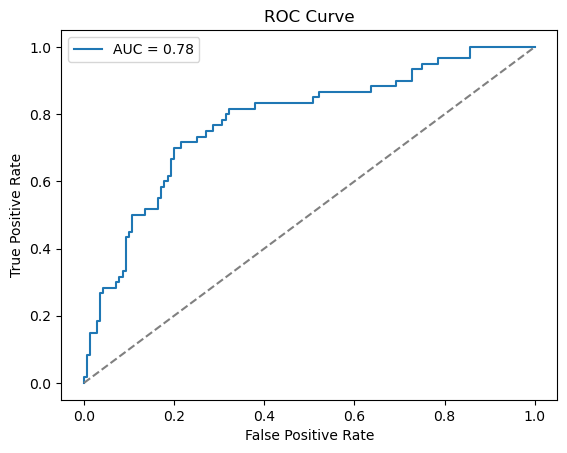

In [2955]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
# Step 1 - predict probabilities
X_test_const = sm.add_constant(X_test)
y_pred_proba = final_model.predict(X_test_const)
y_pred = (y_pred_proba >= 0.5).astype(int)

# Step 2 - classification report
print(classification_report(y_test, y_pred))

# Step 3 – Confusion matrix
print(confusion_matrix(y_test, y_pred))

# Step 4 – ROC and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

plt.figure()
plt.plot(fpr, tpr, label = f"AUC = {auc:.2f}")
plt.plot([0,1],[0,1], linestyle = '--', color = 'gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

#### Model evaluation for logistic regression model with overwritting and weighting

              precision    recall  f1-score   support

           0       0.84      0.76      0.80       140
           1       0.55      0.67      0.60        60

    accuracy                           0.73       200
   macro avg       0.70      0.72      0.70       200
weighted avg       0.75      0.73      0.74       200

[[107  33]
 [ 20  40]]


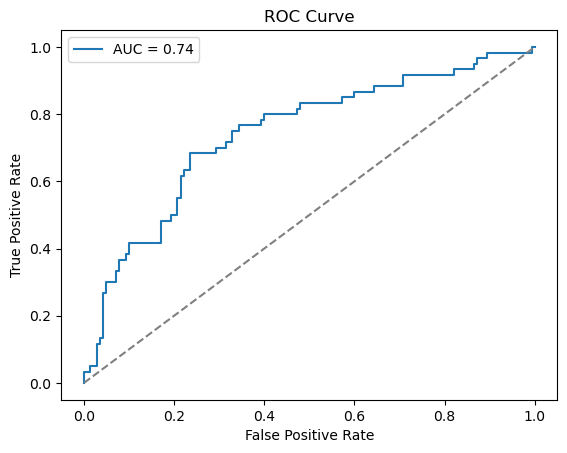

In [2957]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# Step 1 - predict probabilities
X_test_const = sm.add_constant(X_test)
y_pred_proba = model_resampled.predict(X_test_const)
y_pred = (y_pred_proba >= 0.5).astype(int)

# Step 2 - classification report
print(classification_report(y_test, y_pred))

# Step 3 – Confusion matrix
print(confusion_matrix(y_test, y_pred))

# Step 4 – ROC and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

plt.figure()
plt.plot(fpr, tpr, label = f"AUC = {auc:.2f}")
plt.plot([0,1],[0,1], linestyle = '--', color = 'gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

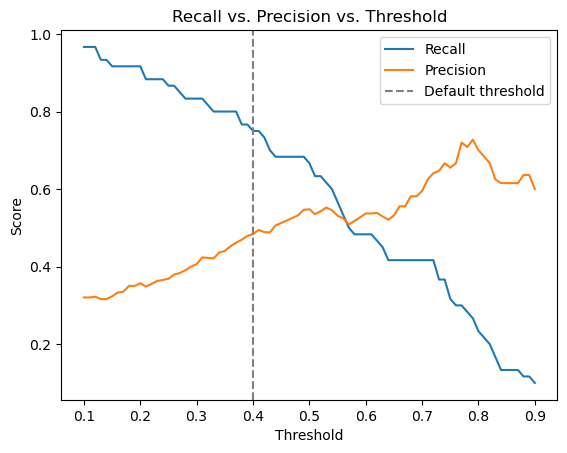

In [2958]:
import numpy as np
from sklearn.metrics import recall_score, precision_score

thresholds = np.linspace(0.1, 0.9, 81)
recalls = []
precisions = []

for t in thresholds:
    y_pred_t = (y_pred_proba >= t).astype(int)
    recalls.append(recall_score(y_test, y_pred_t))
    precisions.append(precision_score(y_test, y_pred_t))

# Visualisation
import matplotlib.pyplot as plt

plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, precisions, label='Precision')
plt.axvline(x=0.4, color='gray', linestyle='--', label='Default threshold')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Recall vs. Precision vs. Threshold')
plt.legend()
plt.show()

#### Checking for underfiting/overfitting ?


| Metric   | Train | Test |
|----------|-------|------|
| Accuracy | 0.71  | 0.73 |
| AUC      | 0.76  | 0.74 |

The performance on the test set is **very close to the training set**, indicating that the model **generalizes well** and does **not overfit**.

In [2961]:
from sklearn.metrics import accuracy_score, roc_auc_score

# Train set
y_train_proba = model_resampled.predict(sm.add_constant(X_train))
y_train_pred = (y_train_proba >= 0.4).astype(int)

# Test set
y_hat_test_proba = model_resampled.predict(sm.add_constant(X_test))
y_hat_test_pred = (y_hat_test_proba >= 0.4).astype(int)

# Metrics
acc_train = accuracy_score(y_train, y_train_pred)
acc_test = accuracy_score(y_test, y_hat_test_pred)
auc_train = roc_auc_score(y_train, y_train_proba)
auc_test = roc_auc_score(y_test, y_hat_test_proba)

print(f"Accuracy train: {acc_train:.2f}, test: {acc_test:.2f}")
print(f"AUC train: {auc_train:.2f}, test: {auc_test:.2f}")

Accuracy train: 0.67, test: 0.69
AUC train: 0.76, test: 0.74


### ✅ Summary

- The **SMOTE + weighted logistic regression** model performs well on both classes, especially improving recall for class 1.
- It preserves economic interpretability (threshold = 0.5).
- There is no sign of overfitting or underfitting.
- The model is now ready for interpretation and business application.

### 7.3 Alternative Models via Cross-Validation

To select the most suitable model for estimating the Probability of Default (PD), we compared four candidate models using cross-validation:

- **Logit Final (SMOTE + weighting + stepwise selection)**
- **Logit with L2 penalty (GridSearchCV)**
- **Random Forest (GridSearchCV)**
- **XGBoost (GridSearchCV)**

Each model was evaluated on the same preprocessed dataset using 5-fold cross-validation and scored based on **recall**, **precision**, and **AUC**.

The barplot below summarizes their relative performance:

📊 **Recall** reflects the ability to correctly identify defaults (class 1).  
📈 **AUC** measures overall discrimination power.  
🎯 **Precision** reflects the trustworthiness of predicted defaults.


#### GridsearchCV for Logistic Regression

In [2966]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# Pipeline : scaling + model
pipe = Pipeline([
    ("clf", LogisticRegression(solver = 'liblinear', random_state = 42, max_iter = 1000))
])

# hyperparameters to be tested
param_grid = {
    'clf__penalty':['l1','l2'],
    'clf__C':[0.01, 0.1, 1, 10],
    'clf__class_weight':[None, 'balanced']
}

# Grid search with cross validation
LR_grid_search = GridSearchCV(
    estimator = pipe,
    param_grid = param_grid,
    scoring={'recall':'recall','roc_auc':'roc_auc','precision':'precision'},
    refit='recall',
    cv = 5,
    n_jobs = -1,
    verbose = 1
)

# Fitting
LR_grid_search.fit(X_train, y_train)

# Résultats
best_index = LR_grid_search.best_index_
results = LR_grid_search.cv_results_
best_params = LR_grid_search.best_params_
recall = results['mean_test_recall'][best_index]
precision = results['mean_test_precision'][best_index]
auc = results['mean_test_roc_auc'][best_index]

print("Logistic Regression Best Params:", LR_grid_search.best_params_)
print("Logistic Regression Best recall:", round(recall, 4))
print("Logistic Regression Best AUC:", round(auc,4))
print("Logistic Regression Best precision:", round(precision, 4))

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Logistic Regression Best Params: {'clf__C': 0.01, 'clf__class_weight': 'balanced', 'clf__penalty': 'l2'}
Logistic Regression Best recall: 0.7458
Logistic Regression Best AUC: 0.7439
Logistic Regression Best precision: 0.4579


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_

#### GridsearchCV for Random Forest

In [2968]:
from sklearn.ensemble import RandomForestClassifier

# Pipeline (Random Forest doesn't need scaling, but included for compatibility)
rf_pipe = Pipeline([
    ("clf", RandomForestClassifier(random_state=42))
])

# Grille d'hyperparamètres
rf_param_grid = {
    'clf__n_estimators': [100, 300],
    'clf__max_depth': [None, 5, 10],
    'clf__min_samples_leaf': [1, 5, 10],
    'clf__max_features': ['sqrt', 'log2'],
    'clf__class_weight': [None, 'balanced']
}

# Grid search
RF_grid_search = GridSearchCV(
    estimator=rf_pipe,
    param_grid=rf_param_grid,
    scoring={'recall':'recall','roc_auc':'roc_auc','precision':'precision'},
    refit='recall',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Entraînement
RF_grid_search.fit(X_train, y_train)

# Résultats
best_index = RF_grid_search.best_index_
results = RF_grid_search.cv_results_
best_params = RF_grid_search.best_params_
recall = results['mean_test_recall'][best_index]
precision = results['mean_test_precision'][best_index]
auc = results['mean_test_roc_auc'][best_index]

print("Random Forest Best Params:", RF_grid_search.best_params_)
print("Random Forest Best recall:", round(recall, 4))
print("Random Forest Best AUC:", round(auc,4))
print("Random Forest Best precision:", round(precision, 4))

Fitting 5 folds for each of 72 candidates, totalling 360 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Random Forest Best Params: {'clf__class_weight': 'balanced', 'clf__max_depth': 10, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 10, 'clf__n_estimators': 300}
Random Forest Best recall: 0.7
Random Forest Best AUC: 0.7829
Random Forest Best precision: 0.5613


#### GridsearchCV for XGBClassifier

In [2970]:
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import pandas as pd

# 🔧 Étape 1 : Nettoyage des noms de colonnes (XGBoost n'aime pas [, <, >, : etc.)
def clean_column_names(df):
    df = df.copy()
    df.columns = [col.replace("[", "")
                      .replace("]", "")
                      .replace("<", "")
                      .replace(">", "")
                      .replace(":", "_")
                      .replace(" ", "_")
                  for col in df.columns]
    return df

X_clean = clean_column_names(X_train)

# 🔁 Étape 2 : Calcul du ratio de classes
neg, pos = (y_train == 0).sum(), (y_train == 1).sum()
scale_pos_weight = neg / pos

# 🔁 Étape 3 : Pipeline XGBoost
xgb_pipe = Pipeline([
    ("clf", XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42))
])

# 🔧 Étape 4 : Grille d'hyperparamètres
xgb_param_grid = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [3, 5],
    'clf__learning_rate': [0.01, 0.1],
    'clf__subsample': [0.8, 1.0],
    'clf__colsample_bytree': [0.8, 1.0],
    'clf__scale_pos_weight': [1, scale_pos_weight]
}

# 🔧 Étape 5 : GridSearchCV multi-scoring
XGB_grid_search = GridSearchCV(
    estimator=xgb_pipe,
    param_grid=xgb_param_grid,
    scoring={'recall': 'recall', 'roc_auc': 'roc_auc', 'precision': 'precision'},
    refit='recall',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# 🔁 Étape 6 : Entraînement
XGB_grid_search.fit(X_clean, y_train)

# ✅ Étape 7 : Résumé des scores de la meilleure combinaison
best_index = XGB_grid_search.best_index_
results = XGB_grid_search.cv_results_

recall = results['mean_test_recall'][best_index]
precision = results['mean_test_precision'][best_index]
auc = results['mean_test_roc_auc'][best_index]

print("✅ XGBoost Best Parameters:", XGB_grid_search.best_params_)
print(f"Recall:    {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"AUC:       {auc:.4f}")

Fitting 5 folds for each of 64 candidates, totalling 320 fits


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:43:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:43:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:43:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:43:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

✅ XGBoost Best Parameters: {'clf__colsample_bytree': 1.0, 'clf__learning_rate': 0.01, 'clf__max_depth': 3, 'clf__n_estimators': 100, 'clf__scale_pos_weight': 2.3333333333333335, 'clf__subsample': 1.0}
Recall:    0.7167
Precision: 0.4918
AUC:       0.7558


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:43:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:43:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:43:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:43:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

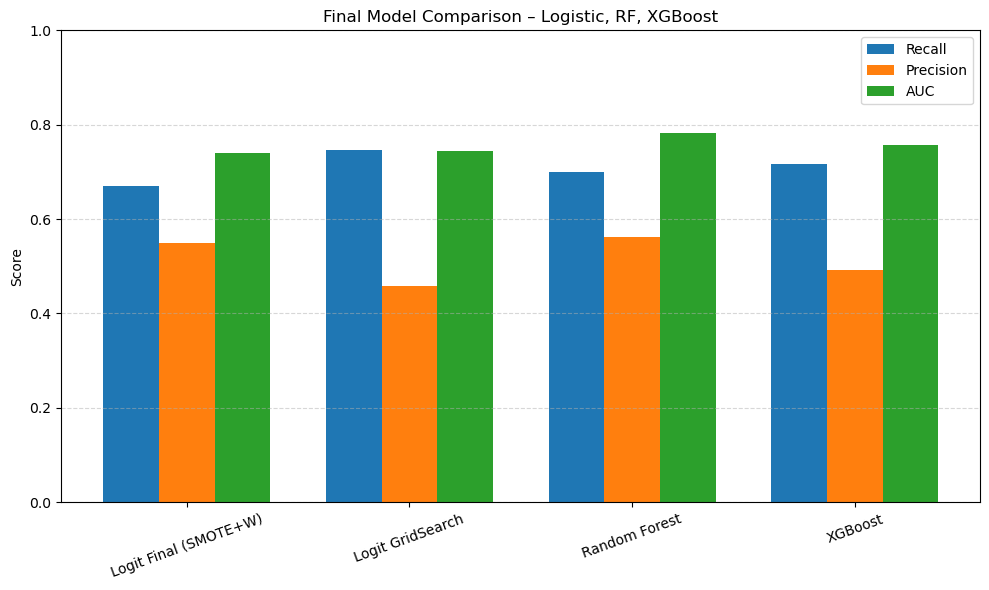

In [2971]:
# Résumé manuel des performances (récupéré depuis tes résultats)
data = {
    "Logit Final (SMOTE+W)": {"Recall": 0.670, "Precision": 0.550, "AUC": 0.740},
    "Logit GridSearch": {"Recall": 0.746, "Precision": 0.458, "AUC": 0.744},
    "Random Forest": {"Recall": 0.700, "Precision": 0.561, "AUC": 0.783},
    "XGBoost": {"Recall": 0.717, "Precision": 0.492, "AUC": 0.756}
}

# Extraire les données
models = list(data.keys())
recalls = [data[m]["Recall"] for m in models]
precisions = [data[m]["Precision"] for m in models]
aucs = [data[m]["AUC"] for m in models]

# Positions
x = range(len(models))
width = 0.25

# Création du graphique
plt.figure(figsize=(10, 6))
plt.bar([p - width for p in x], recalls, width=width, label='Recall')
plt.bar(x, precisions, width=width, label='Precision')
plt.bar([p + width for p in x], aucs, width=width, label='AUC')

# Personnalisation
plt.xticks(ticks=x, labels=models, rotation=20)
plt.ylabel("Score")
plt.title("Final Model Comparison – Logistic, RF, XGBoost")
plt.ylim(0, 1)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

#### 📌 Model Comparison Summary

| Model                         | Recall | Precision | AUC    |
|------------------------------|--------|-----------|--------|
| **Logit Final (SMOTE+W)**    | 0.670  | 0.550     | 0.740  |
| Logit (GridSearch L2)        | **0.746** ✅ | 0.458     | 0.744  |
| Random Forest (GridSearch)   | 0.700  | **0.561** ✅ | **0.783** ✅ |
| XGBoost (GridSearch)         | 0.717  | 0.492     | 0.756  |


### ✅ Final Choice

We choose to retain the **Final Logistic Regression model** trained with:
- **SMOTE resampling** to balance the classes,
- **Class weighting** to further emphasize minority class,
- **Forward AIC-based variable selection** to improve interpretability.

Although other models (e.g., Random Forest, XGBoost) reached higher AUC or precision, the selected logistic model offers the **best trade-off between interpretability, regulatory compliance (IFRS 9), and recall performance**.

This model will be used as the **Probability of Default (PD) component** in the IFRS 9 ECL calculation.

### 7.4 Interpretation of Most Influential Coefficients

This section analyzes the 10 most impactful explanatory variables in the final logistic regression model, based on the absolute deviation of their odds ratios from 1. The greater the deviation, the stronger the variable’s influence on credit risk.

#### Reference Categories Used

- Account_status: no checking account  
- Savings_Account: ≥1000 DM / 500–1000 DM  
- Employment_Since: 4–7 years  
- Purpose: education_others  
- History: critical / other banks  
- Other_Installment: none  
- Property: real estate  
- Housing: own  
- Personal_Status_Sex: male single  


In [2975]:
import numpy as np
import pandas as pd

# Build a summary DataFrame for coefficients
coef_summary = pd.DataFrame({
    "Variable": model_resampled.params.index,
    "Coefficient": model_resampled.params.values,
    "Odds Ratio": np.exp(model_resampled.params.values),
    "P-Value": model_resampled.pvalues.values
})

# Round for readability
coef_summary = coef_summary.round(4)

# Add absolute deviation from 1 to identify strongest odds ratios
coef_summary["|Odds Ratio - 1|"] = (coef_summary["Odds Ratio"] - 1).abs()

# Sort by this economic impact measure
coef_summary_sorted = coef_summary.sort_values(by="|Odds Ratio - 1|", ascending=False)

# Display the table
display(coef_summary_sorted)

,Variable,Coefficient,Odds Ratio,P-Value,|Odds Ratio - 1|
0,const,1.8787,6.5450,0.0000,5.5450
2,Account_status:0 DM,1.2355,3.4399,0.0000,2.4399
26,Property:unknown / no property,0.8291,2.2913,0.0259,1.2913
7,History:no credits_all paid_all paid at this bank,0.7350,2.0855,0.0146,1.0855
1,Account_status:0 <= ... < 200 DM,0.6859,1.9855,0.0002,0.9855
15,Purpose:used car_retraining,-3.1712,0.0420,0.0000,0.9580
13,Purpose:radio/TV,-2.5942,0.0747,0.0000,0.9253
14,Purpose:repairs_business_appliances,-2.3336,0.0969,0.0000,0.9031
4,Duration_Months,0.6381,1.8929,0.0000,0.8929
11,Purpose:furniture/equipment,-2.1001,0.1224,0.0000,0.8776


### 🔟 Top Variables (by |Odds Ratio – 1|, excluding intercept)

1. **`Account_status:0 DM`** → OR = 3.44 → **+244% risk of default**  
   *Applicants with a checking account balance of exactly 0 DM are over twice as likely to default. This reflects severe liquidity stress.*

2. **`Property:unknown / no property`** → OR = 2.29 → **+129% risk of default**  
   *Borrowers who declare no property are over 2× more likely to default. This is consistent with reduced financial stability.*

3. **`History:no credits_all paid_all at this bank`** → OR = 2.09 → **+109% risk of default**  
   *Although this may seem counterintuitive, applicants with no negative history may lack credit exposure. Our analysis shows these profiles are younger and less stable — hence the model captures them as higher risk.* ✅ *Defendable despite ambiguity.*

4. **`Account_status:0 <= ... < 200 DM`** → OR = 1.99 → **+99% risk of default**  
   *Very low account balances also signal fragility, though slightly less critical than a 0 DM balance.*

5. **`Purpose:used car_retraining`** → OR = 0.042 → **−95.8% risk of default**  
   *Initially surprising, but analysis shows that these borrowers are more mature and stable, with moderate amounts and durations. This explains the protective effect.* ✅ *Now considered economically coherent.*

6. **`Purpose:radio/TV`** → OR = 0.075 → **−92.5% risk of default**  
   *This seems contradictory — electronics financing is usually risky. However, our profiles show short durations and low amounts, but relatively unstable employment and age groups. The protective effect is not clearly supported.* ❌ *Remains hard to defend.*

7. **`Purpose:repairs_business_appliances`** → OR = 0.097 → **−90.3% risk of default**  
   *These purposes suggest urgent, unplanned expenses. Our analysis shows high credit variability and instability. The protective effect is not aligned with the profile.* ❌ *Not defendable.*

8. **`Duration_Months`** → OR = 1.89 → **+89% risk of default**  
   *Longer credit terms increase default risk due to extended exposure — a well-known pattern.*

9. **`Purpose:furniture/equipment`** → OR = 0.122 → **−87.8% risk of default**  
   *Despite being consumer-related, this group shows mature, stable borrowers with moderate credit amounts. The model’s prediction is therefore defendable.* ✅ *Reclassified as coherent.*

10. **`Purpose:new car`** → OR = 0.166 → **−83.4% risk of default**  
   *New car loans may attract more financially capable borrowers. This reduced risk aligns with expected behavior.*

---

These insights combine both statistical impact and real-world borrower profiles. When model outputs seem counterintuitive, sociodemographic profiling helps validate or challenge assumptions, increasing trust in the final model.

In [2977]:
# Keep only reference categories that match a group present in included_modalities

# Step 1: Get the variable prefix for each dummy in included_modalities
included_prefixes = set(col.split(":")[0] for col in included_modalities)

# Step 2: Build filtered reference list
final_ref_cat = []

for ref in list_of_ref_cat:
    prefix = ref.split(":")[0]
    if prefix in included_prefixes:
        final_ref_cat.append(ref)

# Step 3: Display the final list of reference categories
print("✅ Final reference categories used in the model:")
for ref in final_ref_cat :
    print("-", ref)

✅ Final reference categories used in the model:
- Account_status:no checking account
- Savings_Account:>=1000 DM_500<...<1000 DM
- Employment_Since:4 <= ... < 7 years
- Purpose:education_others
- History:critical / other banks
- Other_Installment:none
- Property:real estate
- Housing:own
- Personal_Status_Sex:male single


### 7.5 Applying th PD Model

In this section, we transform the predicted probabilities of default (PD) from our logistic regression model into a **scorecard format**. This allows us to derive individual **credit scores**, simulate **acceptance/rejection policies**, and maintain a business-friendly representation of credit risk.


#### Calculating PD of individual accounts

In [2981]:
pd.options.display.max_columns = None
# Sets the pandas dataframe options to display all columns/ rows.

In [2982]:
summary_table = coef_summary[['Variable','Coefficient','P-Value']]
summary_table

,Variable,Coefficient,P-Value
0,const,1.8787,0.0000
1,Account_status:0 <= ... < 200 DM,0.6859,0.0002
2,Account_status:0 DM,1.2355,0.0000
3,Account_status:>= 200 DM or salary assignment,-0.0790,0.8231
4,Duration_Months,0.6381,0.0000
5,History:current credits paid,0.3185,0.0607
6,History:delayed previously,-0.0239,0.9380
7,History:no credits_all paid_all paid at this bank,0.7350,0.0146
8,Savings_Account:100 <= ... < 500 DM,-0.4783,0.1089
9,Savings_Account:< 100 DM,-0.0915,0.6593


#### Creating a Scorecard

#### From Logistic Regression to Scorecard

The logistic regression model produces a predicted probability $\hat{p}$ using:

$$
\hat{p} = \frac{1}{1 + e^{-z}} \quad \text{with} \quad z = \beta_0 + \sum \beta_i x_i
$$

We aim to convert this raw logit $z$ into a **credit score** on a familiar scale (e.g., 300–850), while preserving the model's ranking and interpretability.

To do this, we define a linear transformation:

$$
\text{Score} = a \cdot z + b = a \cdot \left(\beta_0 + \sum \beta_i x_i\right) + b
$$

Where:

- $a = \frac{S_{\text{max}} - S_{\text{min}}}{\beta_{\text{max sum}} - \beta_{\text{min sum}}}$
- $b = S_{\text{min}} - a \cdot \beta_{\text{min sum}}$

$\beta_{\text{max sum}}$ and $\beta_{\text{min sum}}$ are the maximum and minimum possible total logits across all feature combinations.

---

#### Building the Scorecard

We construct a **scorecard** by multiplying each coefficient $\beta_j$ by $a$:

$$
\text{Score}_j = a \cdot \beta_j
$$

This gives us a score contribution for each modality (dummy variable), including 0 for reference categories. The intercept is handled separately:

$$
\text{Score}_0 = a \cdot \beta_0 + b
$$

Then, for each individual, we compute:

$$
\text{Score}_{\text{individual}} = \sum_j (\text{score}_{\text{modality}_j}) \cdot x_j
$$

This is mathematically equivalent to:

$$
\text{Score} = a \cdot \left( \beta_0 + \sum \beta_j x_j \right) + b
$$

✅ This allows us to compute scores using a simple dot product: `score = X.dot(scorecard_vector)`.


In [2985]:
final_ref_cat

['Account_status:no checking account',
 'Savings_Account:>=1000 DM_500<...<1000 DM',
 'Employment_Since:4 <= ... < 7 years',
 'Purpose:education_others',
 'History:critical / other banks',
 'Other_Installment:none',
 'Property:real estate',
 'Housing:own',
 'Personal_Status_Sex:male single']

In [2986]:
df_ref_categories = pd.DataFrame(final_ref_cat, columns = ['Variable'])
# We create a new dataframe with one column. Its values are the values from the 'reference_categories' list.
# We name it 'Feature name'.
df_ref_categories['Coefficient'] = 0
# We create a second column, called 'Coefficients', which contains only 0 values.
df_ref_categories['P-Value'] = np.nan
# We create a third column, called 'p_values', with contains only NaN values.
df_ref_categories

,Variable,Coefficient,P-Value
0,Account_status:no checking account,0,NaN
1,Savings_Account:>=1000 DM_500<...<1000 DM,0,NaN
2,Employment_Since:4 <= ... < 7 years,0,NaN
3,Purpose:education_others,0,NaN
4,History:critical / other banks,0,NaN
5,Other_Installment:none,0,NaN
6,Property:real estate,0,NaN
7,Housing:own,0,NaN
8,Personal_Status_Sex:male single,0,NaN


In [2987]:
df_scorecard = pd.concat([summary_table,df_ref_categories])
df_scorecard = df_scorecard.reset_index()
df_scorecard

,index,Variable,Coefficient,P-Value
0,0,const,1.8787,0.0000
1,1,Account_status:0 <= ... < 200 DM,0.6859,0.0002
2,2,Account_status:0 DM,1.2355,0.0000
3,3,Account_status:>= 200 DM or salary assignment,-0.0790,0.8231
4,4,Duration_Months,0.6381,0.0000
5,5,History:current credits paid,0.3185,0.0607
6,6,History:delayed previously,-0.0239,0.9380
7,7,History:no credits_all paid_all paid at this bank,0.7350,0.0146
8,8,Savings_Account:100 <= ... < 500 DM,-0.4783,0.1089
9,9,Savings_Account:< 100 DM,-0.0915,0.6593


In [2988]:
df_scorecard['Original variable name'] = df_scorecard['Variable'].str.split(':').str[0]
df_scorecard

,index,Variable,Coefficient,P-Value,Original variable name
0,0,const,1.8787,0.0000,const
1,1,Account_status:0 <= ... < 200 DM,0.6859,0.0002,Account_status
2,2,Account_status:0 DM,1.2355,0.0000,Account_status
3,3,Account_status:>= 200 DM or salary assignment,-0.0790,0.8231,Account_status
4,4,Duration_Months,0.6381,0.0000,Duration_Months
5,5,History:current credits paid,0.3185,0.0607,History
6,6,History:delayed previously,-0.0239,0.9380,History
7,7,History:no credits_all paid_all paid at this bank,0.7350,0.0146,History
8,8,Savings_Account:100 <= ... < 500 DM,-0.4783,0.1089,Savings_Account
9,9,Savings_Account:< 100 DM,-0.0915,0.6593,Savings_Account


In [2989]:
min_score = 300
max_score = 850

In [2990]:
df_scorecard.groupby('Original variable name')['Coefficient'].min()

Original variable name
Account_status        -0.0790
Duration_Months        0.6381
Employment_Since      -0.5902
History               -0.0239
Housing               -1.0708
Other_Installment     -0.3513
Personal_Status_Sex   -0.2309
Property              -0.5105
Purpose               -3.1712
Savings_Account       -1.4279
const                  1.8787
Name: Coefficient, dtype: float64

In [2991]:
min_sum_coef = df_scorecard.groupby('Original variable name')['Coefficient'].min().sum()
min_sum_coef

-4.938899999999999

In [2992]:
max_sum_coef = df_scorecard.groupby('Original variable name')['Coefficient'].max().sum()
max_sum_coef

5.9726

In [2993]:
df_scorecard['Score - Calculation'] = df_scorecard['Coefficient'] * (max_score - min_score) / (max_sum_coef - min_sum_coef)
df_scorecard

,index,Variable,Coefficient,P-Value,Original variable name,Score - Calculation
0,0,const,1.8787,0.0000,const,94.696879
1,1,Account_status:0 <= ... < 200 DM,0.6859,0.0002,Account_status,34.573157
2,2,Account_status:0 DM,1.2355,0.0000,Account_status,62.276039
3,3,Account_status:>= 200 DM or salary assignment,-0.0790,0.8231,Account_status,-3.982037
4,4,Duration_Months,0.6381,0.0000,Duration_Months,32.163772
5,5,History:current credits paid,0.3185,0.0607,History,16.054163
6,6,History:delayed previously,-0.0239,0.9380,History,-1.204692
7,7,History:no credits_all paid_all paid at this bank,0.7350,0.0146,History,37.048069
8,8,Savings_Account:100 <= ... < 500 DM,-0.4783,0.1089,Savings_Account,-24.108968
9,9,Savings_Account:< 100 DM,-0.0915,0.6593,Savings_Account,-4.612106


In [2994]:
df_scorecard['Score - Calculation'][0] = ((df_scorecard['Coefficient'][0] - min_sum_coef) / (max_sum_coef - min_sum_coef)) * (max_score - min_score) + min_score
df_scorecard['Score - Preliminary'] = df_scorecard['Score - Calculation'].round()
df_scorecard

,index,Variable,Coefficient,P-Value,Original variable name,Score - Calculation,Score - Preliminary
0,0,const,1.8787,0.0000,const,643.644778,644.0
1,1,Account_status:0 <= ... < 200 DM,0.6859,0.0002,Account_status,34.573157,35.0
2,2,Account_status:0 DM,1.2355,0.0000,Account_status,62.276039,62.0
3,3,Account_status:>= 200 DM or salary assignment,-0.0790,0.8231,Account_status,-3.982037,-4.0
4,4,Duration_Months,0.6381,0.0000,Duration_Months,32.163772,32.0
5,5,History:current credits paid,0.3185,0.0607,History,16.054163,16.0
6,6,History:delayed previously,-0.0239,0.9380,History,-1.204692,-1.0
7,7,History:no credits_all paid_all paid at this bank,0.7350,0.0146,History,37.048069,37.0
8,8,Savings_Account:100 <= ... < 500 DM,-0.4783,0.1089,Savings_Account,-24.108968,-24.0
9,9,Savings_Account:< 100 DM,-0.0915,0.6593,Savings_Account,-4.612106,-5.0


In [2995]:
min_sum_score_prel = df_scorecard.groupby('Original variable name')['Score - Preliminary'].min().sum()
min_sum_score_prel

299.0

In [2996]:
max_sum_score_prel = df_scorecard.groupby('Original variable name')['Score - Preliminary'].max().sum()
max_sum_score_prel

850.0

In [2997]:
df_scorecard['Difference'] = df_scorecard['Score - Preliminary'] - df_scorecard['Score - Calculation']
df_scorecard

,index,Variable,Coefficient,P-Value,Original variable name,Score - Calculation,Score - Preliminary,Difference
0,0,const,1.8787,0.0000,const,643.644778,644.0,0.355222
1,1,Account_status:0 <= ... < 200 DM,0.6859,0.0002,Account_status,34.573157,35.0,0.426843
2,2,Account_status:0 DM,1.2355,0.0000,Account_status,62.276039,62.0,-0.276039
3,3,Account_status:>= 200 DM or salary assignment,-0.0790,0.8231,Account_status,-3.982037,-4.0,-0.017963
4,4,Duration_Months,0.6381,0.0000,Duration_Months,32.163772,32.0,-0.163772
5,5,History:current credits paid,0.3185,0.0607,History,16.054163,16.0,-0.054163
6,6,History:delayed previously,-0.0239,0.9380,History,-1.204692,-1.0,0.204692
7,7,History:no credits_all paid_all paid at this bank,0.7350,0.0146,History,37.048069,37.0,-0.048069
8,8,Savings_Account:100 <= ... < 500 DM,-0.4783,0.1089,Savings_Account,-24.108968,-24.0,0.108968
9,9,Savings_Account:< 100 DM,-0.0915,0.6593,Savings_Account,-4.612106,-5.0,-0.387894


In [2998]:
df_scorecard['Score - Final'] = df_scorecard['Score - Preliminary']
df_scorecard['Score - Final'][29] = -11
df_scorecard

,index,Variable,Coefficient,P-Value,Original variable name,Score - Calculation,Score - Preliminary,Difference,Score - Final
0,0,const,1.8787,0.0000,const,643.644778,644.0,0.355222,644.0
1,1,Account_status:0 <= ... < 200 DM,0.6859,0.0002,Account_status,34.573157,35.0,0.426843,35.0
2,2,Account_status:0 DM,1.2355,0.0000,Account_status,62.276039,62.0,-0.276039,62.0
3,3,Account_status:>= 200 DM or salary assignment,-0.0790,0.8231,Account_status,-3.982037,-4.0,-0.017963,-4.0
4,4,Duration_Months,0.6381,0.0000,Duration_Months,32.163772,32.0,-0.163772,32.0
5,5,History:current credits paid,0.3185,0.0607,History,16.054163,16.0,-0.054163,16.0
6,6,History:delayed previously,-0.0239,0.9380,History,-1.204692,-1.0,0.204692,-1.0
7,7,History:no credits_all paid_all paid at this bank,0.7350,0.0146,History,37.048069,37.0,-0.048069,37.0
8,8,Savings_Account:100 <= ... < 500 DM,-0.4783,0.1089,Savings_Account,-24.108968,-24.0,0.108968,-24.0
9,9,Savings_Account:< 100 DM,-0.0915,0.6593,Savings_Account,-4.612106,-5.0,-0.387894,-5.0


In [2999]:
min_sum_score_prel = df_scorecard.groupby('Original variable name')['Score - Final'].min().sum()
min_sum_score_prel

300.0

In [3000]:
max_sum_score_prel = df_scorecard.groupby('Original variable name')['Score - Final'].max().sum()
max_sum_score_prel

850.0

#### Calculating credit score

In [3002]:
X_test_aligned = df_raw_prep_with_ref.loc[X_test.index]
X_test_with_ref_cat = X_test_aligned[included_modalities + final_ref_cat]
X_test_with_ref_cat['Duration_Months'] = scaler.fit_transform(X_test_with_ref_cat[['Duration_Months']])

In [3003]:
X_test_with_ref_cat_intercept = X_test_with_ref_cat
X_test_with_ref_cat_intercept.insert(0, 'const', 1)

In [3004]:
X_test_with_ref_cat_intercept = X_test_with_ref_cat_intercept[df_scorecard['Variable'].values]
X_test_with_ref_cat_intercept

,const,Account_status:0 <= ... < 200 DM,Account_status:0 DM,Account_status:>= 200 DM or salary assignment,Duration_Months,History:current credits paid,History:delayed previously,History:no credits_all paid_all paid at this bank,Savings_Account:100 <= ... < 500 DM,Savings_Account:< 100 DM,Savings_Account:unknown / no savings,Purpose:furniture/equipment,Purpose:new car,Purpose:radio/TV,Purpose:repairs_business_appliances,Purpose:used car_retraining,Employment_Since:1 <= ... < 4 years,Employment_Since:< 1 year,Employment_Since:>= 7 years,Employment_Since:unemployed,Other_Installment:bank,Other_Installment:stores,Housing:for free,Housing:rent,Property:building society savings / life insurance,Property:car or other (not in savings),Property:unknown / no property,Personal_Status_Sex:female div/sep/married,Personal_Status_Sex:male divorced/separated,Personal_Status_Sex:male married/widowed,Account_status:no checking account,Savings_Account:>=1000 DM_500<...<1000 DM,Employment_Since:4 <= ... < 7 years,Purpose:education_others,History:critical / other banks,Other_Installment:none,Property:real estate,Housing:own,Personal_Status_Sex:male single
30,1,1,0,0,-0.264940,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,1,0
128,1,1,0,0,-0.727719,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,1,1
289,1,0,1,0,0.197838,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0
216,1,0,1,0,-0.264940,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1
966,1,1,0,0,0.429227,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
522,1,0,1,0,2.048950,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1
977,1,1,0,0,-0.264940,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,1
52,1,0,0,0,-0.727719,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,1
542,1,0,1,0,0.660616,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,1


In [3005]:
scorecard_scores = df_scorecard['Score - Final']
X_test_with_ref_cat_intercept.shape
scorecard_scores.shape

(39,)

In [3006]:
scorecard_scores = scorecard_scores.values.reshape(39,1)

In [3007]:
scorecard_scores.shape

(39, 1)

In [3008]:
y_scores = X_test_with_ref_cat_intercept.dot(scorecard_scores)
y_scores = y_scores.rename(columns = {0:"Score"})
y_scores

,Score
30,581.521904
128,461.713003
289,553.330805
216,602.521904
966,508.735256
...,...
522,658.566409
977,423.521904
52,461.713003
542,509.139706


#### From Credit Score to PD

#### Reconstructing PD from the Score

To recover the logit from the score:

$$
z = \frac{\text{Score} - b}{a}
$$

Then, the probability of default is:

$$
\hat{p} = \frac{e^z}{1 + e^z}
$$

This validates the consistency of the scorecard with the original logistic model.


In [3011]:
sum_coef_from_score = ((y_scores - min_score) / (max_score - min_score)) * (max_sum_coef - min_sum_coef) + min_sum_coef
# We divide the difference between the scores and the minimum score by
# the difference between the maximum score and the minimum score.
# Then, we multiply that by the difference between the maximum sum of coefficients and the minimum sum of coefficients.
# Then, we add the minimum sum of coefficients.

In [3012]:
y_hat_proba_from_score = np.exp(sum_coef_from_score) / (np.exp(sum_coef_from_score) + 1)
# Here we divide an exponent raised to sum of coefficients from score by
# an exponent raised to sum of coefficients from score plus one.
y_hat_proba_from_score.rename(columns = {"Score":"Proba"}, inplace = True)
y_hat_proba_from_score.head()

,Proba
30,0.656162
128,0.150503
289,0.521725
216,0.743237
966,0.310500


In [3013]:
y_hat_test_proba[0: 5]

30     0.654454
128    0.148413
289    0.532290
216    0.748465
966    0.319043
dtype: float64

In [3014]:
df_actual_predicted_probs = pd.DataFrame({
    "y_hat_test_proba":y_hat_test_proba,
    "y_test":y_test
})

#### Setting Cut-offs

#### Cut-off Simulation: Accept / Reject Policies

We explore different thresholds for PD-based rejection. For each threshold $t$, we compute:

- Number of rejected applications:

$$
N_{\text{rejected}} = \sum \mathbb{1}_{\hat{p}_i \geq t}
$$

- Number of approved applications:

$$
N_{\text{approved}} = N - N_{\text{rejected}}
$$

- Approval rate:

$$
\text{Approval Rate} = \frac{N_{\text{approved}}}{N}
$$

- Rejection rate:

$$
\text{Rejection Rate} = 1 - \text{Approval Rate}
$$

We also convert each threshold into an equivalent score using the inverse of the logit transformation:

$$
\text{Score}_t = \left( \frac{\log \left( \frac{t}{1 - t} \right) - \beta_{\text{min sum}}}{\beta_{\text{max sum}} - \beta_{\text{min sum}}} \right) \cdot (S_{\text{max}} - S_{\text{min}}) + S_{\text{min}}
$$


In [3017]:
tr = 0.5
df_actual_predicted_probs['y_hat_test'] = (df_actual_predicted_probs['y_hat_test_proba'] >= tr).astype(int)
print(confusion_matrix(df_actual_predicted_probs['y_test'],df_actual_predicted_probs['y_hat_test']))

[[107  33]
 [ 20  40]]


In [3018]:
print(confusion_matrix(df_actual_predicted_probs['y_test'],df_actual_predicted_probs['y_hat_test'])/df_actual_predicted_probs.shape[0])

[[0.535 0.165]
 [0.1   0.2  ]]


In [3019]:
fpr, tpr, tr = roc_curve(df_actual_predicted_probs['y_test'],df_actual_predicted_probs['y_hat_test_proba'])

#### Visualizing Performance

We use the ROC curve to visualize the tradeoff between true positive rate (TPR) and false positive rate (FPR). For each threshold, we compute:

- True positive rate = Sensitivity = Recall  
- False positive rate = 1 – Specificity

This curve helps select the optimal threshold based on business trade-offs (e.g., maximizing recall vs. minimizing false approvals).


Text(0.5, 1.0, 'ROC curve')

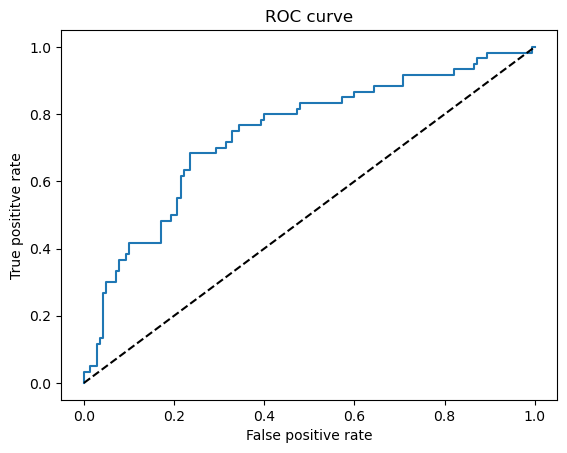

In [3021]:
plt.plot(fpr, tpr)
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
plt.xlabel('False positive rate')
plt.ylabel('True posititve rate')
plt.title('ROC curve')

In [3022]:
tr.shape

(68,)

In [3023]:
df_cutoffs = pd.concat([pd.DataFrame(tr),pd.DataFrame(fpr),pd.DataFrame(tpr)], axis = 1)
df_cutoffs.columns = ['thresholds','fpr','tpr']

df_cutoffs['thresholds'][0] = 1 - 1 / np.power(10, 16)
# Let the first threshold (the value of the thresholds column with index 0) be equal to a number, very close to 1
# but smaller than 1, say 1 - 1 / 10 ^ 16.

df_cutoffs['Score'] = ((np.log(df_cutoffs['thresholds'] / (1 - df_cutoffs['thresholds'])) - min_sum_coef) * ((max_score - min_score) / (max_sum_coef - min_sum_coef)) + min_score).round()
# The score corresponsing to each threshold equals:
# The the difference between the natural logarithm of the ratio of the threshold and 1 minus the threshold and
# the minimum sum of coefficients
# multiplied by
# the sum of the minimum score and the ratio of the difference between the maximum score and minimum score and 
# the difference between the maximum sum of coefficients and the minimum sum of coefficients.

df_cutoffs['Score'][0] = max_score

In [3024]:
df_cutoffs.head()

,thresholds,fpr,tpr,Score
0,1.000000,0.000000,0.000000,850.0
1,0.983356,0.000000,0.016667,755.0
2,0.980634,0.000000,0.033333,747.0
3,0.975194,0.014286,0.033333,734.0
4,0.954859,0.014286,0.050000,703.0


In [3025]:
df_cutoffs.tail()

,thresholds,fpr,tpr,Score
63,0.092161,0.892857,0.966667,434.0
64,0.084548,0.892857,0.983333,429.0
65,0.029690,0.992857,0.983333,373.0
66,0.029553,0.992857,1.000000,373.0
67,0.017285,1.000000,1.000000,345.0


In [3026]:
# We define a function called 'n_rejected' which assigns a value of 1 if a predicted probability
# is greater than the parameter p, which is a threshold, and a value of 0, if it is not.
# Then it sums the column.
# Thus, if given any percentage values, the function will return
# the number of rows wih estimated probabilites greater than the threshold. 
def n_rejected(p):
    return np.where(df_actual_predicted_probs['y_hat_test_proba'] >= p, 1, 0).sum()

df_cutoffs['N Rejected'] = df_cutoffs['thresholds'].apply(n_rejected)
# Assuming that all credit applications above a given probability of default will be rejected,
# when we apply the 'n_rejected' function to a threshold, it will return the number of approved applications.
# Thus, here we calculate the number of approved appliations for al thresholds.

df_cutoffs['N Approved'] = df_actual_predicted_probs['y_hat_test_proba'].shape[0] - df_cutoffs['N Rejected']
# Then, we calculate the number of approved applications for each threshold.
# It is the difference between the total number of applications and the rejected applications for that threshold.

df_cutoffs['Approval Rate'] = df_cutoffs['N Approved'] / df_actual_predicted_probs['y_hat_test_proba'].shape[0]
# Approval rate equalts the ratio of the approved applications and all applications.

df_cutoffs['Rejection Rate'] = 1 - df_cutoffs['Approval Rate']
# Rejection rate equals one minus approval rate.

In [3027]:
df_cutoffs.head()

,thresholds,fpr,tpr,Score,N Rejected,N Approved,Approval Rate,Rejection Rate
0,1.000000,0.000000,0.000000,850.0,0,200,1.000,0.000
1,0.983356,0.000000,0.016667,755.0,1,199,0.995,0.005
2,0.980634,0.000000,0.033333,747.0,2,198,0.990,0.010
3,0.975194,0.014286,0.033333,734.0,4,196,0.980,0.020
4,0.954859,0.014286,0.050000,703.0,5,195,0.975,0.025


In [3028]:
df_cutoffs.tail()

,thresholds,fpr,tpr,Score,N Rejected,N Approved,Approval Rate,Rejection Rate
63,0.092161,0.892857,0.966667,434.0,183,17,0.085,0.915
64,0.084548,0.892857,0.983333,429.0,184,16,0.080,0.920
65,0.029690,0.992857,0.983333,373.0,198,2,0.010,0.990
66,0.029553,0.992857,1.000000,373.0,199,1,0.005,0.995
67,0.017285,1.000000,1.000000,345.0,200,0,0.000,1.000


In [3029]:
df_cutoffs[(df_cutoffs['thresholds'] <= 0.50) & (df_cutoffs['thresholds'] >= 0.30)]

,thresholds,fpr,tpr,Score,N Rejected,N Approved,Approval Rate,Rejection Rate
32,0.495488,0.235714,0.683333,548.0,74,126,0.630,0.370
33,0.436267,0.292857,0.683333,536.0,82,118,0.590,0.410
34,0.433843,0.292857,0.700000,536.0,83,117,0.585,0.415
35,0.430070,0.314286,0.700000,535.0,86,114,0.570,0.430
36,0.429126,0.314286,0.716667,535.0,87,113,0.565,0.435
37,0.422747,0.328571,0.716667,533.0,89,111,0.555,0.445
38,0.416529,0.328571,0.750000,532.0,91,109,0.545,0.455
39,0.402168,0.342857,0.750000,529.0,93,107,0.535,0.465
40,0.397579,0.342857,0.766667,528.0,94,106,0.530,0.470
41,0.373335,0.392857,0.766667,523.0,101,99,0.495,0.505


### ✅ Outcome

We now have:

- A fully operational **credit scoring model** based on logistic regression,  
- A **scorecard** that can be deployed in production,  
- A complete **score-to-probability conversion** pipeline,  
- And **threshold-based rejection policies** supporting business decisioning.

In [3031]:
df_scorecard.to_csv('df_scorecard.csv')

## 8. LGD Modeling

To model Loss Given Default (LGD) under IFRS 9, we first simulate LGD values using economically coherent assumptions. The simulation is applied **only to defaulted clients** ($\text{Risk} = 1$), since LGD is undefined for performing loans.

#### LGD Simulation Logic

We define the Exposure at Default ($\text{EAD}$) as the original `Credit_Amount`.

We then simulate the `Recovered_Amount` as a function of the following borrower features:
- **Loan Purpose**: loans for radio/TV, education, or "others" are assumed to be riskier (lower recovery), while loans for cars or furniture suggest higher recovery.
- **Housing**: owners are more likely to offer collateral than renters or individuals housed for free.
- **Credit Amount**: higher amounts are assumed to have lower proportional recovery.
- **Age**: older borrowers are considered more stable; younger borrowers, less so.

These adjustments are applied to a random base recovery rate drawn from $\mathcal{U}(0.4, 0.7)$ and clipped to the interval $[0.1, 0.9]$.

The LGD is computed as:

$$
\text{LGD} = 1 - \frac{\text{Recovered Amount}}{\text{EAD}} \quad \text{if Risk} = 1
$$

Non-defaulted borrowers ($\text{Risk} \neq 1$) are excluded from this computation.

---

#### LGD Modeling – Model Comparison

We compare three supervised models to predict LGD, trained only on defaulted accounts:

#### ✅ Models tested:
- **Gradient Boosting Regressor (XGBoost style)**
- **Random Forest Regressor**
- **Linear Regression (baseline)**

Each model is trained using a pipeline that:
- Standardizes numeric features (`Credit_Amount`, `Duration_Months`, `Age`)
- Encodes categorical features using `OrdinalEncoder`
- Fits the selected regression model


### 8.1 Simulating LGD Values for Defaults Only

#### Simulating recovery variable to compute LGD

In [3036]:
import numpy as np
import pandas as pd

# Assume that y_test and df_raw_prep_with_ref are already defined
# y_test: Series indexed with 0 (non-default) and 1 (default)
# df_raw_prep_with_ref: test dataset with at least 'Credit_Amount'

# Step 1: Build working dataset with aligned indices
df_lgd = df_raw.drop(loan_data_dummies, axis = 1).iloc[:, :21]


# Step 2: Assume EAD is equal to Credit_Amount
df_lgd["EAD"] = df_lgd["Credit_Amount"]

def simulate_recovery(row):
    # Base recovery rate: random component
    base = np.random.uniform(0.4, 0.7)

    # Adjust based on Purpose (by keywords)
    p = str(row.get("Purpose", "")).lower()

    if any(keyword in p for keyword in ["radio", "education", "others"]):
        base -= 0.2
    elif any(keyword in p for keyword in ["repairs", "appliances", "used car"]):
        base -= 0.1
    elif any(keyword in p for keyword in ["new car", "furniture", "equipment"]):
        base += 0.05
    elif any(keyword in p for keyword in ["business", "retraining"]):
        base += 0  # neutral

    # Adjust based on Housing
    housing = row.get("Housing")
    if housing == "own":
        base += 0.1
    elif housing == "rent":
        base += 0
    elif housing == "for free":
        base -= 0.05

    # Adjust based on Credit Amount
    if row.get("Credit_Amount", 0) > 10000:
        base -= 0.1

    # Adjust based on Age
    age = row.get("Age", 0)
    if age > 50:
        base += 0.05
    elif age < 25:
        base -= 0.05

    # Final recovery = EAD × adjusted recovery rate (capped)
    return row["EAD"] * np.clip(base, 0.1, 0.9)

# Appliquer simulate_recovery uniquement aux défauts
df_lgd.loc[df_lgd["Risk"] == 1, "Recovered_Amount"] = (
    df_lgd[df_lgd["Risk"] == 1].apply(simulate_recovery, axis=1)
)

# Mettre à NaN pour les non défauts (juste au cas où)
df_lgd.loc[df_lgd["Risk"] != 1, "Recovered_Amount"] = np.nan

# Recalculer la LGD
df_lgd["LGD"] = np.where(
    df_lgd["Risk"] == 1,
    1 - df_lgd["Recovered_Amount"] / df_lgd["EAD"],
    np.nan
)

df_lgd_train = df_lgd.loc[y_train.index].copy()

df_lgd_test = df_lgd.loc[y_test.index].copy()

# Step 5: Preview the result
df_lgd_train[["Risk", "EAD", "Recovered_Amount", "LGD"]].head()

,Risk,EAD,Recovered_Amount,LGD
828,1,8335,4260.502679,0.488842
997,0,804,NaN,NaN
148,0,5371,NaN,NaN
735,0,3990,NaN,NaN
130,0,8487,NaN,NaN


#### Modeling with Xgboost

In [3038]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import make_scorer, r2_score



df_default = df_lgd_train[df_lgd_train["Risk"] == 1].copy()

# Step 2: Separate target and features
X_train_lgd = df_default.drop(columns=["Risk", "LGD","EAD","Recovered_Amount"])
y_train_lgd = df_default["LGD"]

# Étape 3 : détecter les variables numériques
requested_num_cols = ["Credit_Amount", "Duration_Months", "Age"]
num_cols = [col for col in requested_num_cols if col in X_train_lgd.columns]
cat_cols = [col for col in X_train_lgd.columns if col not in num_cols]

# Étape 4 : pipeline de prétraitement
preprocessor = ColumnTransformer([
    ("scale", StandardScaler(), num_cols),
    ("encode", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), cat_cols)
])

# Étape 5 : pipeline complet avec modèle robuste
pipeline = Pipeline([
    ("preprocessing", preprocessor),
    ("model", HistGradientBoostingRegressor(random_state=42))
])

# Étape 6 : cross-validation 5 folds
cv = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(pipeline, X_train_lgd, y_train_lgd, scoring=make_scorer(r2_score), cv=cv)
pipeline.fit(X_train_lgd, y_train_lgd)
# Résultats
print(f"Mean R²: {scores.mean():.4f}")
print(f"Std R² : {scores.std():.4f}")

Mean R²: 0.6012
Std R² : 0.0742


#### Modeling with Random Forest

In [3040]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

# Étape 1 : reconstruire les données défauts
X_rf = df_default.drop(columns=["Risk", "LGD", "EAD", "Recovered_Amount"])
y_rf = df_default["LGD"]

# Étape 2 : identifier les colonnes numériques et catégorielles
requested_num_cols = ["Credit_Amount", "Duration_Months", "Age"]
num_cols = [col for col in requested_num_cols if col in X_rf.columns]
cat_cols = [col for col in X_rf.columns if col not in num_cols]

# Étape 3 : pipeline de prétraitement
preprocessor_rf = ColumnTransformer([
    ("scale", StandardScaler(), num_cols),
    ("encode", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), cat_cols)
])

# Étape 4 : pipeline complet avec Random Forest
rf_pipeline = Pipeline([
    ("preprocessing", preprocessor_rf),
    ("model", RandomForestRegressor(
        n_estimators=300,
        max_depth=8,
        min_samples_leaf=5,
        max_features='sqrt',
        random_state=42
    ))
])

# Étape 5 : entraînement
rf_pipeline.fit(X_rf, y_rf)

# Évaluation sur le train set (défauts uniquement)
y_pred_train_rf = rf_pipeline.predict(X_rf)
print("Random Forest R² (train):", r2_score(y_rf, y_pred_train_rf))
print("Random Forest RMSE (train):", mean_squared_error(y_rf, y_pred_train_rf, squared=False))

Random Forest R² (train): 0.6338354093939292
Random Forest RMSE (train): 0.0995512498733706


#### Modeling with Linear Regression

In [3042]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.metrics import r2_score, mean_squared_error

# Étape 1 : données de train (défauts uniquement)
df_default = df_lgd_train[df_lgd_train["Risk"] == 1].copy()
X_lin = df_default.drop(columns=["Risk", "LGD", "EAD", "Recovered_Amount"])
y_lin = df_default["LGD"]

# Étape 2 : identifie colonnes numériques et catégorielles
requested_num_cols = ["Credit_Amount", "Duration_Months", "Age"]
num_cols = [col for col in requested_num_cols if col in X_lin.columns]
cat_cols = [col for col in X_lin.columns if col not in num_cols]

# Étape 3 : pipeline de prétraitement
preprocessor = ColumnTransformer([
    ("scale", StandardScaler(), num_cols),
    ("encode", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), cat_cols)
])

# Étape 4 : pipeline complet avec Linear Regression
lin_pipeline = Pipeline([
    ("preprocessing", preprocessor),
    ("model", LinearRegression())
])

# Étape 5 : fit modèle sur les défauts
lin_pipeline.fit(X_lin, y_lin)

# Évaluation sur le train set
y_pred_train_lin = lin_pipeline.predict(X_lin)
print("Linear Regression R² (train):", r2_score(y_lin, y_pred_train_lin))
print("Linear Regression RMSE (train):", mean_squared_error(y_lin, y_pred_train_lin, squared=False))

# Étape 6 : prédiction sur test set (défauts)
df_test_default = df_lgd.loc[y_test.index].copy()
df_test_default = df_test_default[df_test_default["Risk"] == 1]
X_test_lin = df_test_default.drop(columns=["Risk", "LGD", "EAD", "Recovered_Amount"])
y_test_lin = df_test_default["LGD"]

# Étape 7 : prédiction et évaluation
y_pred_lin = lin_pipeline.predict(X_test_lin)
print("Linear Regression R² (test):", r2_score(y_test_lin, y_pred_lin))
print("Linear Regression RMSE (test):", mean_squared_error(y_test_lin, y_pred_lin, squared=False))

Linear Regression R² (train): 0.23588409736875204
Linear Regression RMSE (train): 0.1438096946039914
Linear Regression R² (test): 0.04645633471995858
Linear Regression RMSE (test): 0.1660239626752281


#### Validate Xgboost model on test data

In [3044]:
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import LabelEncoder

# Étape 1 : recréer X_test et y_test (brut)
df_test_default = df_lgd.loc[y_test.index].copy()
df_test_default = df_test_default[df_test_default["Risk"] == 1]

X_test_lgd = df_test_default.drop(columns=["Risk", "LGD", "EAD", "Recovered_Amount"])
y_test_lgd = df_test_default["LGD"]

# Étape 2 : prédire proprement via le pipeline
y_pred_test = pipeline.predict(X_test_lgd)

# Étape 3 : évaluer
from sklearn.metrics import r2_score, mean_squared_error
print("R² (test):", r2_score(y_test_lgd, y_pred_test))
print("RMSE (test):", mean_squared_error(y_test_lgd, y_pred_test, squared=False))

R² (test): 0.5960814791698372
RMSE (test): 0.10805562170043496


#### Model Performance Summary

| Model               | $R^2$ (Train) | $R^2$ (Test) | RMSE (Test) | Interpretation                  |
|---------------------|---------------|--------------|-------------|----------------------------------|
| **Gradient Boosting** | $\sim 0.60$   |  **0.596**    | **0.10**   | ✅ Best model overall            |
| **Random Forest**     | $\sim 0.62$   | 0.467        | 0.114       | Decent performance               |
| **Linear Regression** | 0.23          | 0.05         | 0.152       | Weak fit and generalization     |

The Gradient Boosting model clearly outperforms others and will be used in the next step to generate LGD estimates across the entire portfolio.

## 9. EAD Modeling

### 9.1 Simulation of CCF and EAD

To simulate Exposure at Default (EAD), we assume each loan has a `Credit_Limit` and a portion already drawn (`Drawn_Amount`). The remainder is an undrawn amount that could potentially be used before default.

A Credit Conversion Factor (CCF) is simulated for the entire portfolio based on:

- **Purpose of the loan**: e.g., education, furniture, business,
- **Housing status**: owner, renter, living for free,
- **Age of borrower**.

The formula used is:

$$
\text{EAD} = \text{Drawn\_Amount} + \text{CCF} \times \text{Undrawn}
$$

These simulations serve as a proxy for real-life utilization behavior in credit lines.



In [3047]:
np.random.seed(42)  # for reproducibility
df_ead = df_lgd.copy()
np.random.seed(42)

# Simulate Drawn_Amount and Credit_Limit if not already done
df_ead["Credit_Limit"] = df_ead["Credit_Amount"] * np.random.uniform(1.0, 1.5, size=len(df_ead))
df_ead["Drawn_Amount"] = df_ead["Credit_Amount"] * np.random.uniform(0.8, 1.0, size=len(df_ead))
df_ead["Credit_Limit"] = df_ead[["Credit_Limit", "Drawn_Amount"]].max(axis=1) + 10
df_ead["Undrawn"] = df_ead["Credit_Limit"] - df_ead["Drawn_Amount"]

# Step 1: Define a smarter CCF simulation function
def simulate_ccf(purpose, housing, age):
    base = np.random.uniform(0.2, 0.6)  # Base CCF range

    # Purpose-based adjustment
    p = str(purpose).lower()
    if any(x in p for x in ["education", "radio", "others"]):
        base += 0.2
    elif any(x in p for x in ["repairs", "appliances", "used car"]):
        base += 0.1
    elif any(x in p for x in ["business", "furniture", "equipment", "new car"]):
        base -= 0.05

    # Housing adjustment
    if housing == "own":
        base -= 0.1
    elif housing == "for free":
        base += 0.05

    # Age adjustment
    if age > 55:
        base -= 0.05
    elif age < 25:
        base += 0.05

    return np.clip(base, 0.0, 1.0)

# Step 2: Apply to entire portfolio
df_ead["CCF"] = df_ead.apply(lambda row: simulate_ccf(
    row.get("Purpose", ""), row.get("Housing", ""), row.get("Age", 0)), axis=1)

# Step 3: Recompute EAD from CCF
df_ead["EAD"] = df_ead["Drawn_Amount"] + df_ead["CCF"] * df_ead["Undrawn"]

### 9.2 Exploratory Analysis

We plotted the simulated `CCF` values against various features (`Credit_Amount`, `Duration`, `Age`, etc.) and transformed variables (logarithmic and ratio features) to understand their relationships.

This helped identify potential non-linearities and guided the creation of engineered features:

- `Log_Credit_Amount`, `Drawn_Ratio`, `Undrawn_Ratio`, etc.



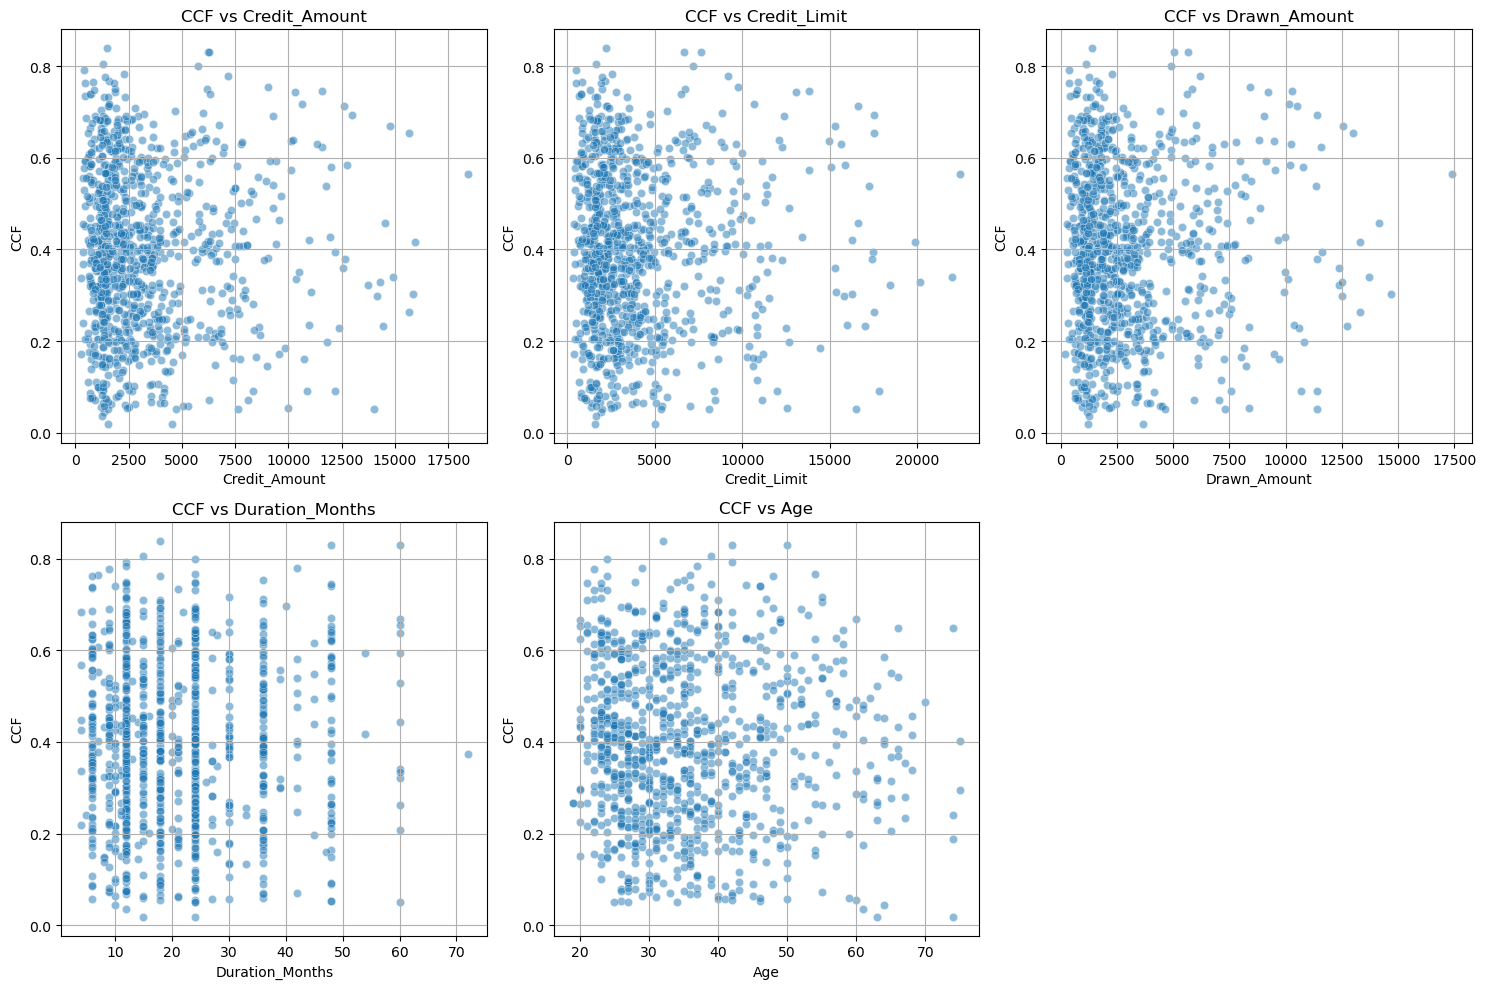

In [3049]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select numeric variables of interest
plot_vars = ["Credit_Amount", "Credit_Limit", "Drawn_Amount", "Duration_Months", "Age"]

# Filter dataset where CCF is not null
df_plot = df_ead[df_ead["CCF"].notnull()]

# Plot CCF vs each feature
plt.figure(figsize=(15, 10))
for i, var in enumerate(plot_vars, 1):
    plt.subplot(2, 3, i)
    sns.scatterplot(data=df_plot, x=var, y="CCF", alpha=0.5)
    plt.title(f"CCF vs {var}")
    plt.xlabel(var)
    plt.ylabel("CCF")
    plt.grid(True)

plt.tight_layout()
plt.show()

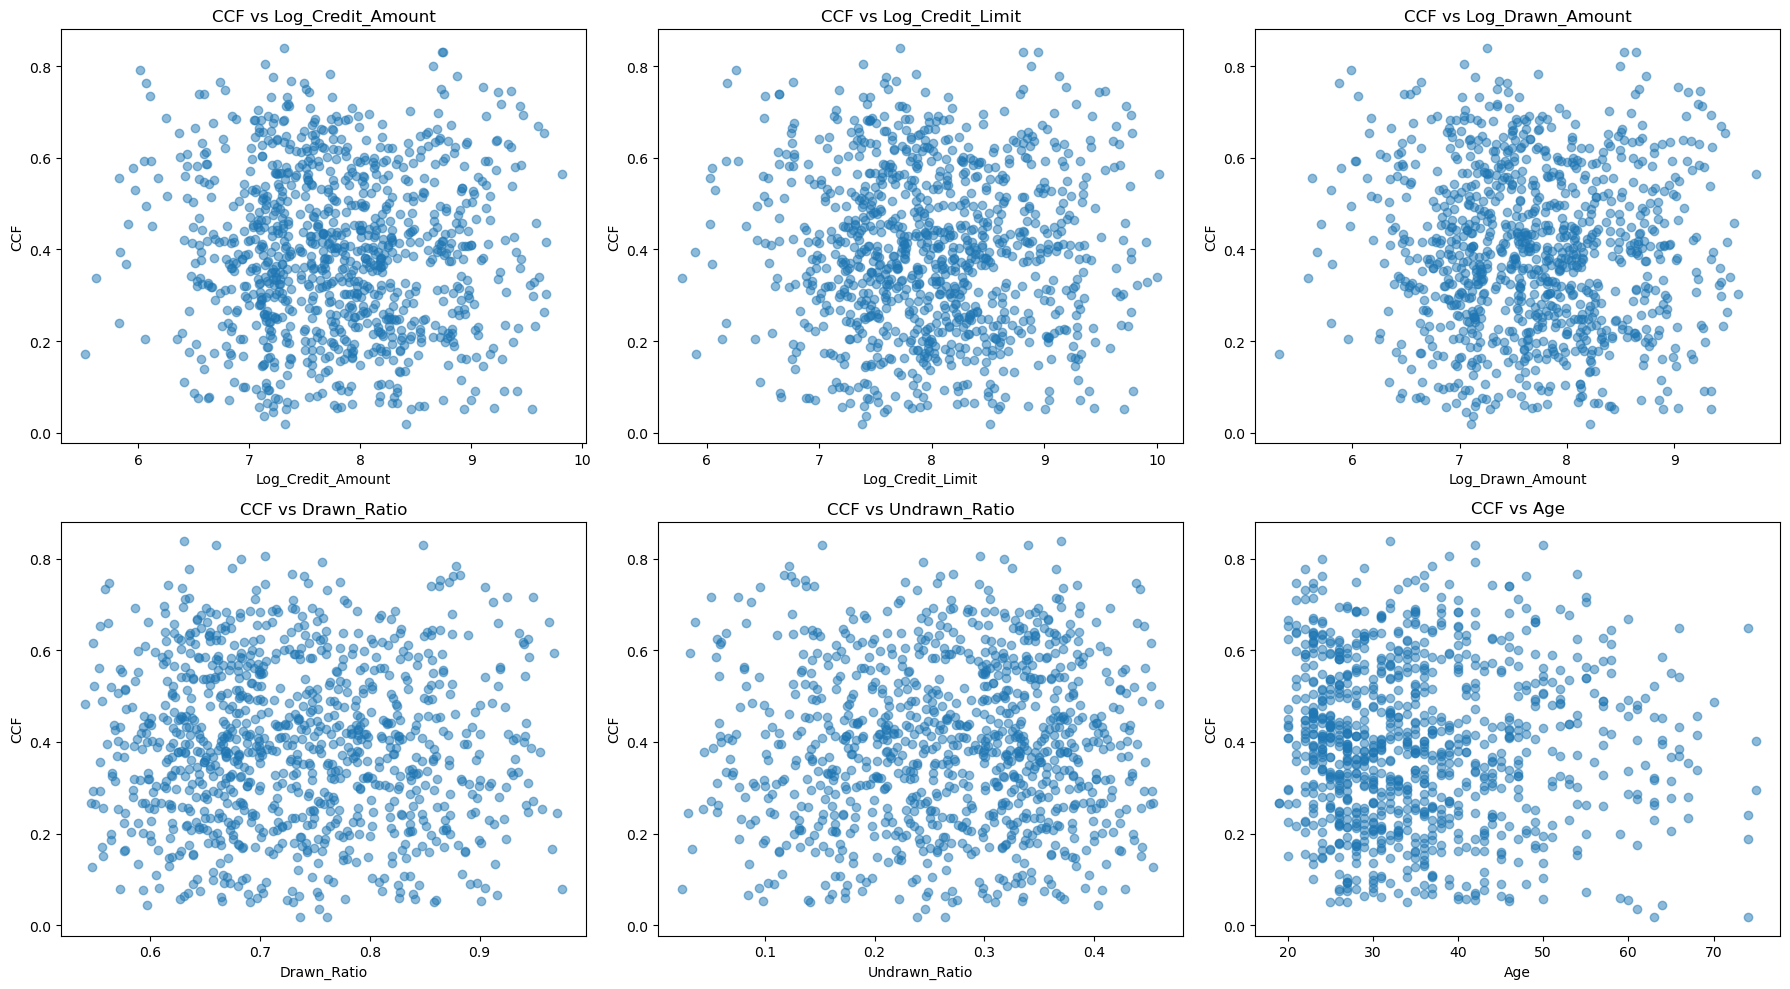

In [3050]:
import numpy as np
import matplotlib.pyplot as plt

# Create transformed features
df_ead['Log_Credit_Amount'] = np.log1p(df_ead['Credit_Amount'])
df_ead['Log_Credit_Limit'] = np.log1p(df_ead['Credit_Limit'])
df_ead['Log_Drawn_Amount'] = np.log1p(df_ead['Drawn_Amount'])

# Ratio features
df_ead['Drawn_Ratio'] = df_ead['Drawn_Amount'] / df_ead['Credit_Limit']
df_ead['Undrawn_Ratio'] = (df_ead['Credit_Limit'] - df_ead['Drawn_Amount']) / df_ead['Credit_Limit']

# Plot transformed variables against CCF
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()
features_to_plot = ['Log_Credit_Amount', 'Log_Credit_Limit', 'Log_Drawn_Amount', 'Drawn_Ratio', 'Undrawn_Ratio', 'Age']

for i, feature in enumerate(features_to_plot):
    axes[i].scatter(df_ead[feature], df_ead['CCF'], alpha=0.5)
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel("CCF")
    axes[i].set_title(f"CCF vs {feature}")

plt.tight_layout()
plt.show()

### 9.3 Model Training – Predicting CCF

We built several models to estimate `CCF` using training data only. All models were trained on the same features after preprocessing and variable selection.

#### ✅ Model 1: HistGradientBoostingRegressor

- Variable selection via `SelectFromModel(RandomForest)`
- Preprocessing with `StandardScaler` + `OrdinalEncoder`
- No test split (model trained on train set only)

**Train performance:**

- $R^2$: 0.9192  
- RMSE: 0.0492

**Test performance:**

- $R^2$: 0.4822  
- RMSE: 0.1333

In [3052]:
# Étape 1 : On travaille sur df_ccf_train = données d'entraînement uniquement
df_ccf_train = df_ead.loc[X_train.index].copy()

# Étape 2 : Variables transformées
df_ccf_train["Log_Credit_Amount"] = np.log(df_ccf_train["Credit_Amount"] + 1)
df_ccf_train["Log_Credit_Limit"] = np.log(df_ccf_train["Credit_Limit"] + 1)
df_ccf_train["Log_Drawn_Amount"] = np.log(df_ccf_train["Drawn_Amount"] + 1)
df_ccf_train["Drawn_Ratio"] = df_ccf_train["Drawn_Amount"] / df_ccf_train["Credit_Limit"]
df_ccf_train["Undrawn_Ratio"] = df_ccf_train["Undrawn"] / df_ccf_train["Credit_Limit"]

# Étape 3 : X et y
X = df_ccf_train.drop(columns=[
    "CCF", "EAD", "Recovered_Amount", "LGD", "LGD_hat", "EAD_hat", "Risk"
], errors='ignore')
y = df_ccf_train["CCF"]

# Étape 4 : Typage
num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()

# Étape 5 : Préprocessing
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), cat_cols)
])
X_proc = preprocessor.fit_transform(X)

# Étape 6 : Sélection de variables
selector = SelectFromModel(RandomForestRegressor(random_state=42), threshold="median")
selector.fit(X_proc, y)
X_sel = selector.transform(X_proc)

# Étape 7 : Modélisation directe (pas de split ici)
model = HistGradientBoostingRegressor(random_state=42)
model.fit(X_sel, y)

# Étape 8 : Évaluation apparente
y_pred = model.predict(X_sel)
print("✅ Nouveau modèle CCF – Résultats (entraînement uniquement)")
print(f"R²:   {r2_score(y, y_pred):.4f}")
print(f"RMSE: {mean_squared_error(y, y_pred, squared=False):.4f}")

✅ Nouveau modèle CCF – Résultats (entraînement uniquement)
R²:   0.9192
RMSE: 0.0492


In [3053]:
# Étape 1 : récupérer les noms d'origine des features
feature_names_num = preprocessor.transformers_[0][2]  # colonnes numériques
feature_names_cat = preprocessor.transformers_[1][2]  # colonnes catégorielles

all_feature_names = feature_names_num + feature_names_cat

# Étape 2 : appliquer le masque de sélection
selected_mask = selector.get_support()
selected_features = [name for name, keep in zip(all_feature_names, selected_mask) if keep]

# Étape 3 : affichage
#print("✅ Variables sélectionnées pour le modèle CCF :")
#for feat in selected_features:
#    print("-", feat)

### 9.4 XGBoost Model and Hyperparameter Tuning

We tuned an `XGBRegressor` via `GridSearchCV` over 144 combinations with 5-fold CV.

**Best parameters:**

```python
{
  'learning_rate': 0.05,
  'max_depth': 2,
  'n_estimators': 200,
  'reg_alpha': 0.1,
  'reg_lambda': 1.0,
  'subsample': 1.0
}

In [3055]:
# Étape 1 : reconstruire df_ccf_test depuis df_ead
df_ccf_test = df_ead.loc[X_test.index].copy()

# Étape 2 : recréer les variables transformées
df_ccf_test["Log_Credit_Amount"] = np.log(df_ccf_test["Credit_Amount"] + 1)
df_ccf_test["Log_Credit_Limit"] = np.log(df_ccf_test["Credit_Limit"] + 1)
df_ccf_test["Log_Drawn_Amount"] = np.log(df_ccf_test["Drawn_Amount"] + 1)
df_ccf_test["Drawn_Ratio"] = df_ccf_test["Drawn_Amount"] / df_ccf_test["Credit_Limit"]
df_ccf_test["Undrawn_Ratio"] = df_ccf_test["Undrawn"] / df_ccf_test["Credit_Limit"]

# Étape 3 : features
X_test_ccf = df_ccf_test.drop(columns=[
    "CCF", "EAD", "Recovered_Amount", "LGD", "LGD_hat", "EAD_hat", "Risk"
], errors='ignore')

# Étape 4 : preprocessing + sélection
X_test_proc = preprocessor.transform(X_test_ccf)
X_test_sel = selector.transform(X_test_proc)

# Étape 5 : prédiction
y_test_true = df_ccf_test["CCF"]
y_test_pred = model.predict(X_test_sel)

# Étape 6 : évaluation
from sklearn.metrics import r2_score, mean_squared_error
r2 = r2_score(y_test_true, y_test_pred)
rmse = mean_squared_error(y_test_true, y_test_pred, squared=False)

print("✅ CCF Model Evaluation on Test Set")
print(f"R²:   {r2:.4f}")
print(f"RMSE: {rmse:.4f}")

✅ CCF Model Evaluation on Test Set
R²:   0.4822
RMSE: 0.1333


In [3056]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

# Step 1: define base model
xgb = XGBRegressor(objective="reg:squarederror", random_state=42)

# Step 2: define grid
param_grid = {
    "max_depth": [2, 3, 4],
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators": [200, 300],
    "subsample": [0.8, 1.0],
    "reg_lambda": [0.1, 1.0],
    "reg_alpha": [0, 0.1]
}

# Step 3: GridSearchCV
grid = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring="r2",
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Step 4: Fit on train data
grid.fit(X_sel, y)

# Step 5: Retrieve best model
best_model = grid.best_estimator_
print("✅ Best Parameters:", grid.best_params_)

# Step 6: Evaluate on train set
y_pred_train = best_model.predict(X_sel)
r2_train = r2_score(y, y_pred_train)
rmse_train = mean_squared_error(y, y_pred_train, squared=False)

# Step 7: Evaluate on test set
y_pred_test = best_model.predict(X_test_sel)
y_true_test = df_ccf_test["CCF"]
r2_test = r2_score(y_true_test, y_pred_test)
rmse_test = mean_squared_error(y_true_test, y_pred_test, squared=False)

# Step 8: Display results
print("✅ XGBoost Model – Performance After Tuning")
print(f"Train R²:   {r2_train:.4f}")
print(f"Train RMSE: {rmse_train:.4f}")
print(f"Test R²:    {r2_test:.4f}")
print(f"Test RMSE:  {rmse_test:.4f}")

Fitting 5 folds for each of 144 candidates, totalling 720 fits
✅ Best Parameters: {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 200, 'reg_alpha': 0.1, 'reg_lambda': 1.0, 'subsample': 1.0}
✅ XGBoost Model – Performance After Tuning
Train R²:   0.5887
Train RMSE: 0.1109
Test R²:    0.5361
Test RMSE:  0.1262


### 9.5 Benchmark Models

#### 🔹 Ridge Regression on Polynomial Features
- L2 regularization helped stabilize the model  
- Still underperformed compared to XGBoost

**Train $R^2$**: 0.3609  
**Test $R^2$**: 0.0922


❌ Due to its low explanatory power and inability to model non-linear relationships, the linear regression was **not retained**.

In [3058]:
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error

# Step 1: Générer les données polynomiales (déjà fait plus haut si tu les as toujours)
X_train_poly = poly.fit_transform(X_sel)
X_test_poly = poly.transform(X_test_sel)

# Step 2: Entraîner la Ridge Regression avec pénalisation L2
ridge_model = Ridge(alpha=1.0)  # alpha = force de régularisation (à ajuster si besoin)
ridge_model.fit(X_train_poly, y)

# Step 3: Prédictions
y_pred_train_ridge = ridge_model.predict(X_train_poly)
y_pred_test_ridge = ridge_model.predict(X_test_poly)

# Step 4: Évaluation
r2_train = r2_score(y, y_pred_train_ridge)
rmse_train = mean_squared_error(y, y_pred_train_ridge, squared=False)

r2_test = r2_score(df_ccf_test["CCF"], y_pred_test_ridge)
rmse_test = mean_squared_error(df_ccf_test["CCF"], y_pred_test_ridge, squared=False)

# Step 5: Résultats
print("✅ Ridge Regression on Polynomial Features – Performance")
print(f"Train R²:   {r2_train:.4f}")
print(f"Train RMSE: {rmse_train:.4f}")
print(f"Test R²:    {r2_test:.4f}")
print(f"Test RMSE:  {rmse_test:.4f}")

✅ Ridge Regression on Polynomial Features – Performance
Train R²:   0.3609
Train RMSE: 0.1383
Test R²:    0.0922
Test RMSE:  0.1766


## 10. Expected Credit Loss (ECL)

### 10.1 Computing Expected Credit Loss (ECL) under normal conditions for 1 year horizon

### 🎯 Objective

Compute the Expected Credit Loss (ECL) using the standard IFRS 9 formula:

$$
\text{ECL} = \text{PD}_{\text{hat}} \times \text{LGD}_{\text{hat}} \times \text{EAD}_{\text{hat}}
$$

Where:
- $\text{PD}_{\text{hat}}$: Predicted probability of default (logistic regression with SMOTE resampling)
- $\text{LGD}_{\text{hat}}$: Predicted loss given default (Gradient Boosting model)
- $\text{EAD}_{\text{hat}}$: Predicted exposure at default (CCF model applied to the undrawn amount)

---

### 🏗️ Construction of `df_ecl`

The final `df_ecl` DataFrame is built from the base dataset and enriched with:
- Credit risk indicators: `Risk`, `Recovered_Amount`, `LGD`
- Simulated credit data: `Credit_Limit`, `Drawn_Amount`, `Undrawn`, `CCF`, `EAD`
- Model predictions: `PD_hat`, `LGD_hat`, `CCF_hat`, `EAD_hat`
- Final expected loss:

$$
\text{ECL} = \text{PD}_{\text{hat}} \cdot \text{LGD}_{\text{hat}} \cdot \text{EAD}_{\text{hat}}
$$


In [3062]:
#Definition of final ecl dataframe from preprocessed data
df_ecl = df_raw_prep_with_ref.copy()
df_ecl = df_ecl.drop(list_of_cat_to_del, axis = 1)
df_ecl = df_ecl[sorted(df_ecl.columns)]
df_ecl['Risk'] = df_raw['Risk']
df_ecl['Recovered_Amount'] = df_lgd['Recovered_Amount'] 
df_ecl['LGD'] = df_lgd['LGD']
df_ecl["Credit_Limit"] = df_ead["Credit_Limit"] 
df_ecl["Drawn_Amount"] = df_ead["Drawn_Amount"] 
df_ecl["Credit_Limit"] = df_ead["Credit_Limit"] 
df_ecl["Undrawn"] = df_ead["Undrawn"] 
df_ecl["CCF"] = df_ead["CCF"] 
df_ecl["EAD"] = df_ead["EAD"]

# Predicting PD for all the individuals
X_ecl_pd = df_ecl.copy()
num_cols_pd = ["Credit_Amount", "Duration_Months", "Age"]
X_ecl_pd[num_cols_pd] = scaler_pd.transform(X_ecl_pd[num_cols_pd])
X_ecl_pd = X_ecl_pd[included_modalities]
X_ecl_pd = sm.add_constant(X_ecl_pd)
df_ecl['PD_hat'] = model_resampled.predict(X_ecl_pd) # Best PD model

# Predicting LGD for all the individuals
X_ecl_lgd = df_lgd[X_train_lgd.columns].copy()
requested_num_cols_ecl = ["Credit_Amount", "Duration_Months", "Age"]
num_cols_ecl = [col for col in requested_num_cols_ecl if col in X_ecl_lgd.columns]
cat_cols_ecl = [col for col in X_ecl_lgd.columns if col not in num_cols_ecl]
df_ecl['LGD_hat'] = pipeline.predict(X_ecl_lgd)

# Predicting EAD for all the individuals
X_ecl_ead = df_ead.copy()
X_ecl_ead["Log_Credit_Amount"] = np.log(X_ecl_ead["Credit_Amount"] + 1)
X_ecl_ead["Log_Credit_Limit"] = np.log(X_ecl_ead["Credit_Limit"] + 1)
X_ecl_ead["Log_Drawn_Amount"] = np.log(X_ecl_ead["Drawn_Amount"] + 1)
X_ecl_ead["Drawn_Ratio"] = X_ecl_ead["Drawn_Amount"] / X_ecl_ead["Credit_Limit"]
X_ecl_ead["Undrawn_Ratio"] = X_ecl_ead["Undrawn"] / X_ecl_ead["Credit_Limit"]
X_ecl_ead = X_ecl_ead[df_ccf_train.columns]  
X_all_proc = preprocessor.transform(X_ecl_ead)        
X_all_sel = selector.transform(X_all_proc)        

df_ecl["CCF_hat"] = best_model.predict(X_all_sel)
df_ecl["EAD_hat"] = df_ecl["Drawn_Amount"] + df_ecl["CCF_hat"] * df_ecl["Undrawn"]

df_ecl["ECL"] = df_ecl['PD_hat'] * df_ecl['LGD_hat'] * df_ecl["EAD_hat"]

In [3063]:
df_ecl.iloc[:,-13:]

,Risk,Recovered_Amount,LGD,Credit_Limit,Drawn_Amount,Undrawn,CCF,EAD,PD_hat,LGD_hat,CCF_hat,EAD_hat,ECL
0,0,NaN,NaN,1397.918699,978.484079,419.434621,0.354682,1127.250104,0.092192,0.467960,0.473960,1177.279454,50.790319
1,1,2688.726656,0.548189,8789.850419,5405.770508,3384.079911,0.448792,6924.516873,0.749118,0.616088,0.513727,7144.265171,3297.240199
2,0,NaN,NaN,2873.129651,2042.738894,830.390757,0.662502,2592.874292,0.788485,0.567230,0.408533,2381.980754,1065.347504
3,0,NaN,NaN,10251.313086,7459.879311,2791.433775,0.299818,8296.802742,0.684963,0.368474,0.349525,8435.555381,2129.056222
4,1,3355.451521,0.310996,5259.905389,4681.590558,578.314831,0.308780,4860.162548,0.643255,0.395158,0.377654,4899.993563,1245.515686
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,NaN,NaN,1825.493240,1616.894830,208.598409,0.396118,1699.524478,0.386294,0.347640,0.249266,1668.891306,224.117635
996,0,NaN,NaN,5636.039230,3823.532519,1812.506712,0.262909,4300.057359,0.427773,0.543928,0.434658,4611.352288,1072.958906
997,0,NaN,NaN,869.001090,654.288449,214.712641,0.423915,745.308389,0.143252,0.552403,0.504890,762.694719,60.354130
998,1,629.411351,0.658856,2731.593959,1497.053192,1234.540767,0.616018,2257.552789,0.775595,0.718076,0.618209,2260.257999,1258.819310


### 📌 Summary Statistics

- **Total ECL**: \$759,624  
- **Mean ECL**: \$759.96

---

### 📉 Ratios

- **ECL / Total Credit Amount**:

$$
\frac{\sum \text{ECL}}{\sum \text{Credit Amount}} \approx 23.22\%
$$

- **ECL / Total Credit Limit**:

$$
\frac{\sum \text{ECL}}{\sum \text{Credit Limit}} \approx 18.70\%
$$

These figures suggest that expected losses represent between **18% and 23%** of the total credit exposure, depending on whether we consider the disbursed or authorized amounts.

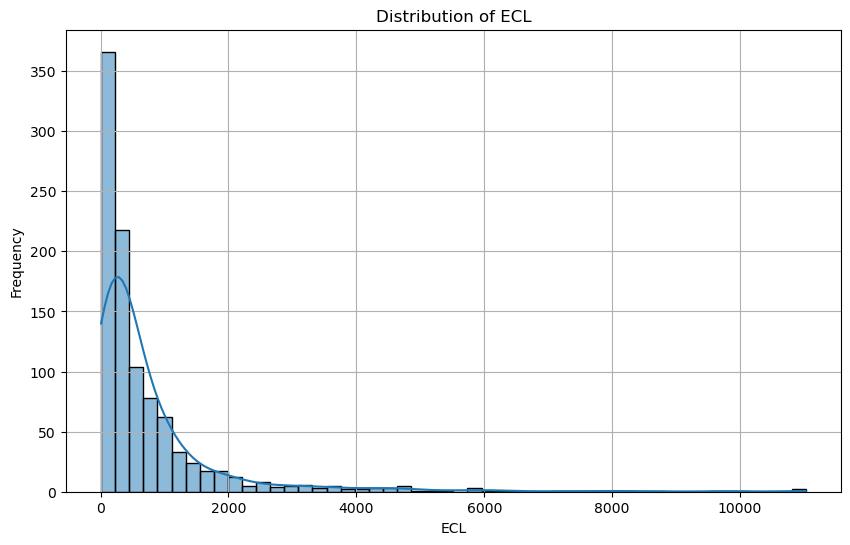

✅ ECL Descriptive Statistics:
count     1000.000000
mean       759.623788
std       1227.458514
min          8.076094
25%        155.302929
50%        351.773628
75%        832.583724
max      11026.866536
Name: ECL, dtype: float64


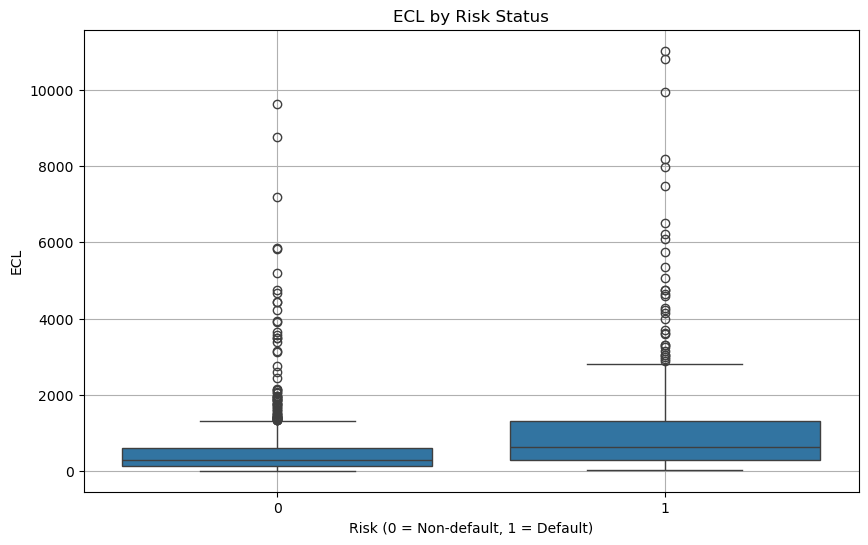

In [3065]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of ECL values
plt.figure(figsize=(10, 6))
sns.histplot(df_ecl["ECL"], bins=50, kde=True)
plt.title("Distribution of ECL")
plt.xlabel("ECL")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Display aggregated statistics
print("✅ ECL Descriptive Statistics:")
print(df_ecl["ECL"].describe())

# Optional: visualize ECL by default status
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_ecl, x="Risk", y="ECL")
plt.title("ECL by Risk Status")
plt.xlabel("Risk (0 = Non-default, 1 = Default)")
plt.ylabel("ECL")
plt.grid(True)
plt.show()

In [3066]:
df_ecl["ECL"].sum()

759623.7879134107

In [3067]:
(df_ecl["ECL"].sum() / df_ecl["Credit_Amount"].sum()) * 100

23.221151860030933

In [3068]:
(df_ecl["ECL"].sum() / df_ecl["Credit_Limit"].sum()) * 100

18.704595487347103

In [3069]:
df_ecl["ECL"].describe()

count     1000.000000
mean       759.623788
std       1227.458514
min          8.076094
25%        155.302929
50%        351.773628
75%        832.583724
max      11026.866536
Name: ECL, dtype: float64

In [3265]:
df_ecl['EAD_hat'].mean()

3392.7227508274195

### 10.2 Scenario Analysis – Probabilistic and Discounted ECL

### Objective

To align with IFRS 9, we evaluate Expected Credit Loss (ECL) under:
- multiple macroeconomic scenarios,
- probability-weighted outcomes,
- time value of money (discounting over time horizon).

The base formula used:

$$
\text{ECL} = \text{PD}_{\text{hat}} \times \text{LGD}_{\text{hat}} \times \text{EAD}_{\text{hat}}
$$

---

### IFRS 9 Compliance

This modeling approach addresses:

- ✅ *Unbiased and probability-weighted outcomes*  
- ✅ *Time value of money*  
- ✅ *Forward-looking and reasonable macroeconomic assumptions*

Such analysis supports regulatory requirements for provisioning and capital planning under IFRS 9.

### Scenario-Based ECL with Probability Weighting (IFRS 9 Compliance)

We define 4 scenarios with stress multipliers applied to PD, LGD, and EAD:

| Scenario    | PD × | LGD × | EAD × | Description                             |
|-------------|------|--------|--------|-----------------------------------------|
| Baseline    | 1.00 | 1.00   | 1.00   | No macroeconomic stress (reference)     |
| Adverse 1   | 1.20 | 1.10   | 1.00   | Mild deterioration                      |
| Adverse 2   | 1.30 | 1.15   | 1.05   | Rising unemployment and credit strain   |
| Severe      | 1.50 | 1.25   | 1.10   | Systemic shock or deep recession        |

After applying each scenario:

- **Probability-weighted ECL**:  
  ✅ `939,484 DM`


In [3072]:
# Step 1: Copy the base ECL dataset
df_ecl_scenario = df_ecl.copy()

# Step 2: Define macroeconomic shock scenarios
scenarios = {
    "baseline": {"PD": 1.00, "LGD": 1.00, "EAD": 1.00},
    "adverse_1": {"PD": 1.20, "LGD": 1.10, "EAD": 1.00},
    "adverse_2": {"PD": 1.30, "LGD": 1.15, "EAD": 1.05},
    "severe":    {"PD": 1.50, "LGD": 1.25, "EAD": 1.10}
}

# Step 3: Apply each scenario and calculate adjusted ECL
ecl_summary = []

for name, factors in scenarios.items():
    pd_adj = df_ecl_scenario["PD_hat"] * factors["PD"]
    lgd_adj = df_ecl_scenario["LGD_hat"] * factors["LGD"]
    ead_adj = df_ecl_scenario["EAD_hat"] * factors["EAD"]
    
    # Clip PD and LGD to [0, 1] range
    pd_adj = pd_adj.clip(0, 1)
    lgd_adj = lgd_adj.clip(0, 1)
    
    ecl_adj = pd_adj * lgd_adj * ead_adj
    total_ecl = ecl_adj.sum()
    ratio_amount = total_ecl / df_ecl_scenario["Credit_Amount"].sum()
    ratio_limit = total_ecl / df_ecl_scenario["Credit_Limit"].sum()
    
    ecl_summary.append({
        "Scenario": name,
        "Total ECL (DM)": f"{round(total_ecl):,}",
        "ECL / Credit Amount (%)": round(ratio_amount * 100, 2),
        "ECL / Credit Limit (%)": round(ratio_limit * 100, 2)
    })

# Step 4: Display results
import pandas as pd
from IPython.display import display

df_scenarios = pd.DataFrame(ecl_summary)


# Step 5: Define scenario probabilities (must sum to 1.0)
scenario_probs = {
    "baseline": 0.5,
    "adverse_1": 0.2,
    "adverse_2": 0.2,
    "severe": 0.1
}

# Step 6: Convert ECL column to numeric for computation (remove thousands separator)
df_scenarios["Total ECL (DM)"] = df_scenarios["Total ECL (DM)"].replace(",", "", regex=True).astype(float)

# Step 7: Add scenario probabilities
df_scenarios["Probability"] = df_scenarios["Scenario"].map(scenario_probs)

# Step 8: Compute weighted ECL
df_scenarios["Weighted ECL"] = df_scenarios["Total ECL (DM)"] * df_scenarios["Probability"]

# Step 9: Aggregate result
weighted_ecl = df_scenarios["Weighted ECL"].sum()

# Step 10: Format result
import locale
locale.setlocale(locale.LC_ALL, '')
formatted_weighted_ecl = locale.format_string("%.0f", weighted_ecl, grouping=True)

display(df_scenarios)
print(f"✅ Probability-weighted ECL (IFRS 9): {formatted_weighted_ecl} DM")

,Scenario,Total ECL (DM),ECL / Credit Amount (%),ECL / Credit Limit (%),Probability,Weighted ECL
0,baseline,759624.0,23.22,18.70,0.5,379812.0
1,adverse_1,971126.0,29.69,23.91,0.2,194225.2
2,adverse_2,1127719.0,34.47,27.77,0.2,225543.8
3,severe,1399035.0,42.77,34.45,0.1,139903.5


✅ Probability-weighted ECL (IFRS 9): 939 484 DM


In [3073]:
discount_rate = 0.05  # exemple : 5% taux annuel
df_ecl["Discounted_ECL"] = df_ecl["ECL"] / (1 + discount_rate)

ecl_adj_discounted = ecl_adj / (1 + discount_rate)

### Discounted Lifetime ECL under Uniform Loss Allocation (No Scenario Weighting) 

Assuming constant annual losses over 5 years and a 5% discount rate:

- Each year receives 1/5 of the total ECL
- Cash flows are discounted year by year

Result:

- ✅ `657,755 DM` (Discounted over 5 years at 5%)


In [3075]:
# Step 1: Set discount parameters
n_years = 5
discount_rate = 0.05  # 5% annual discount rate

# Step 2: Assume constant yearly loss = 1/5 of full ECL (simplification)
df_discounted = df_ecl.copy()
for t in range(1, n_years + 1):
    discount_factor = 1 / ((1 + discount_rate) ** t)
    df_discounted[f"ECL_year_{t}"] = (df_discounted["ECL"] / n_years) * discount_factor

# Step 3: Sum discounted values across years
df_discounted["ECL_discounted_total"] = df_discounted[[f"ECL_year_{t}" for t in range(1, n_years + 1)]].sum(axis=1)

# Step 4: Display results
import locale
locale.setlocale(locale.LC_ALL, '')
total_discounted_ecl = df_discounted["ECL_discounted_total"].sum()
formatted_total = locale.format_string("%.0f", total_discounted_ecl, grouping=True)

print(f"✅ Discounted Lifetime ECL (5 years, 5% rate): {formatted_total} DM")

✅ Discounted Lifetime ECL (5 years, 5% rate): 657 755 DM


In [3076]:
df_discounted

,Account_status:0 <= ... < 200 DM,Account_status:0 DM,Account_status:>= 200 DM or salary assignment,Account_status:no checking account,Age,Credit_Amount,Duration_Months,Employment_Since:1 <= ... < 4 years,Employment_Since:4 <= ... < 7 years,Employment_Since:< 1 year,Employment_Since:>= 7 years,Employment_Since:unemployed,History:critical / other banks,History:current credits paid,History:delayed previously,History:no credits_all paid_all paid at this bank,Housing:for free,Housing:own,Housing:rent,Other_Debtors:co-applicant,Other_Debtors:guarantor,Other_Debtors:none,Other_Installment:bank,Other_Installment:none,Other_Installment:stores,Personal_Status_Sex:female div/sep/married,Personal_Status_Sex:male divorced/separated,Personal_Status_Sex:male married/widowed,Personal_Status_Sex:male single,Property:building society savings / life insurance,Property:car or other (not in savings),Property:real estate,Property:unknown / no property,Purpose:education_others,Purpose:furniture/equipment,Purpose:new car,Purpose:radio/TV,Purpose:repairs_business_appliances,Purpose:used car_retraining,Savings_Account:100 <= ... < 500 DM,Savings_Account:< 100 DM,Savings_Account:>=1000 DM_500<...<1000 DM,Savings_Account:unknown / no savings,Risk,Recovered_Amount,LGD,Credit_Limit,Drawn_Amount,Undrawn,CCF,EAD,PD_hat,LGD_hat,CCF_hat,EAD_hat,ECL,Discounted_ECL,ECL_year_1,ECL_year_2,ECL_year_3,ECL_year_4,ECL_year_5,ECL_discounted_total
0,0,1,0,0,67,1169,6,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,NaN,NaN,1397.918699,978.484079,419.434621,0.354682,1127.250104,0.092192,0.467960,0.473960,1177.279454,50.790319,48.371732,9.674346,9.213663,8.774917,8.357064,7.959109,43.979100
1,1,0,0,0,22,5951,48,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,2688.726656,0.548189,8789.850419,5405.770508,3384.079911,0.448792,6924.516873,0.749118,0.616088,0.513727,7144.265171,3297.240199,3140.228761,628.045752,598.138812,569.656011,542.529534,516.694795,2855.064904
2,0,0,0,1,49,2096,12,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,NaN,NaN,2873.129651,2042.738894,830.390757,0.662502,2592.874292,0.788485,0.567230,0.408533,2381.980754,1065.347504,1014.616670,202.923334,193.260318,184.057446,175.292806,166.945529,922.479433
3,0,1,0,0,45,7882,42,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,NaN,NaN,10251.313086,7459.879311,2791.433775,0.299818,8296.802742,0.684963,0.368474,0.349525,8435.555381,2129.056222,2027.672593,405.534519,386.223351,367.831763,350.315965,333.634252,1843.539849
4,0,1,0,0,53,4870,24,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,3355.451521,0.310996,5259.905389,4681.590558,578.314831,0.308780,4860.162548,0.643255,0.395158,0.377654,4899.993563,1245.515686,1186.205415,237.241083,225.943889,215.184656,204.937767,195.178826,1078.486221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,0,1,31,1736,12,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,NaN,NaN,1825.493240,1616.894830,208.598409,0.396118,1699.524478,0.386294,0.347640,0.249266,1668.891306,224.117635,213.445367,42.689073,40.656260,38.720248,36.876427,35.120406,194.062415
996,0,1,0,0,40,3857,30,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,NaN,NaN,5636.039230,3823.532519,1812.506712,0.262909,4300.057359,0.427773,0.543928,0.434658,4611.352288,1072.958906,1021.865625,204.373125,194.641071,185.372449,176.545189,168.138276,929.070111
997,0,0,0,1,38,804,12,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,NaN,NaN,869.001090,654.288449,214.712641,0.423915,745.308389,0.143252,0.552403,0.504890,762.694719,60.354130,57.480124,11.496025,10.948595,10.427233,9.930698,9.457808,52.260360
998,0,1,0,0,2

### Probability-Weighted and Discounted ECL under Static Scenario Assumptions

We compute a lifetime ECL using both:

1. **Stress on risk parameters (PD, LGD, EAD)** per scenario
2. **Probability of each scenario**
3. **5-year discounting** for time value of money

Each year is discounted separately, and ECLs are weighted by scenario probability:

- ✅ `844,689 DM` (Probability-weighted & discounted)


In [3078]:
import numpy as np
import pandas as pd
import locale

# Step 1: Copy the base dataset
df_discounted = df_ecl.copy()

# Step 2: Define macroeconomic scenarios with probabilities
scenarios = {
    "baseline":  {"PD": 1.00, "LGD": 1.00, "EAD": 1.00, "prob": 0.5},
    "adverse_1": {"PD": 1.20, "LGD": 1.10, "EAD": 1.00, "prob": 0.2},
    "adverse_2": {"PD": 1.30, "LGD": 1.15, "EAD": 1.05, "prob": 0.2},
    "severe":    {"PD": 1.50, "LGD": 1.25, "EAD": 1.10, "prob": 0.1}
}

# Step 3: Define discount rate and horizon
discount_rate = 0.05
n_years = 5

# Step 4: Initialize total discounted ECL
df_discounted["Discounted_ECL"] = 0.0

# Step 5: Loop through scenarios
for name, factors in scenarios.items():
    prob = factors["prob"]

    pd_s = df_discounted["PD_hat"].clip(0, 1) * factors["PD"]
    lgd_s = df_discounted["LGD_hat"].clip(0, 1) * factors["LGD"]
    ead_s = df_discounted["EAD_hat"] * factors["EAD"]

    # Annual loss assumed evenly distributed
    ecl_annual = (pd_s * lgd_s * ead_s) / n_years

    # Discount each year's loss and sum
    discounted = sum([
        ecl_annual / ((1 + discount_rate) ** year)
        for year in range(1, n_years + 1)
    ])

    # Weight by scenario probability and accumulate
    df_discounted["Discounted_ECL"] += prob * discounted

# Step 6: Output final value
locale.setlocale(locale.LC_ALL, '')
total_discounted_ecl = df_discounted["Discounted_ECL"].sum()
formatted_result = locale.format_string("%.0f", total_discounted_ecl, grouping=True)

print(f"✅ Total Discounted Probability-Weighted ECL: {formatted_result} DM")

✅ Total Discounted Probability-Weighted ECL: 844 689 DM


In [3079]:
df_discounted

,Account_status:0 <= ... < 200 DM,Account_status:0 DM,Account_status:>= 200 DM or salary assignment,Account_status:no checking account,Age,Credit_Amount,Duration_Months,Employment_Since:1 <= ... < 4 years,Employment_Since:4 <= ... < 7 years,Employment_Since:< 1 year,Employment_Since:>= 7 years,Employment_Since:unemployed,History:critical / other banks,History:current credits paid,History:delayed previously,History:no credits_all paid_all paid at this bank,Housing:for free,Housing:own,Housing:rent,Other_Debtors:co-applicant,Other_Debtors:guarantor,Other_Debtors:none,Other_Installment:bank,Other_Installment:none,Other_Installment:stores,Personal_Status_Sex:female div/sep/married,Personal_Status_Sex:male divorced/separated,Personal_Status_Sex:male married/widowed,Personal_Status_Sex:male single,Property:building society savings / life insurance,Property:car or other (not in savings),Property:real estate,Property:unknown / no property,Purpose:education_others,Purpose:furniture/equipment,Purpose:new car,Purpose:radio/TV,Purpose:repairs_business_appliances,Purpose:used car_retraining,Savings_Account:100 <= ... < 500 DM,Savings_Account:< 100 DM,Savings_Account:>=1000 DM_500<...<1000 DM,Savings_Account:unknown / no savings,Risk,Recovered_Amount,LGD,Credit_Limit,Drawn_Amount,Undrawn,CCF,EAD,PD_hat,LGD_hat,CCF_hat,EAD_hat,ECL,Discounted_ECL
0,0,1,0,0,67,1169,6,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,NaN,NaN,1397.918699,978.484079,419.434621,0.354682,1127.250104,0.092192,0.467960,0.473960,1177.279454,50.790319,56.477960
1,1,0,0,0,22,5951,48,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,2688.726656,0.548189,8789.850419,5405.770508,3384.079911,0.448792,6924.516873,0.749118,0.616088,0.513727,7144.265171,3297.240199,3666.474350
2,0,0,0,1,49,2096,12,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,NaN,NaN,2873.129651,2042.738894,830.390757,0.662502,2592.874292,0.788485,0.567230,0.408533,2381.980754,1065.347504,1184.648087
3,0,1,0,0,45,7882,42,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,NaN,NaN,10251.313086,7459.879311,2791.433775,0.299818,8296.802742,0.684963,0.368474,0.349525,8435.555381,2129.056222,2367.473874
4,0,1,0,0,53,4870,24,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,3355.451521,0.310996,5259.905389,4681.590558,578.314831,0.308780,4860.162548,0.643255,0.395158,0.377654,4899.993563,1245.515686,1384.992005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,0,1,31,1736,12,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,NaN,NaN,1825.493240,1616.894830,208.598409,0.396118,1699.524478,0.386294,0.347640,0.249266,1668.891306,224.117635,249.214953
996,0,1,0,0,40,3857,30,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,NaN,NaN,5636.039230,3823.532519,1812.506712,0.262909,4300.057359,0.427773,0.543928,0.434658,4611.352288,1072.958906,1193.111836
997,0,0,0,1,38,804,12,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,NaN,NaN,869.001090,654.288449,214.712641,0.423915,745.308389,0.143252,0.552403,0.504890,762.694719,60.354130,67.112754
998,0,1,0,0,23,1845,45,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,629.411351,0.658856,2731.593959,1497.053192,1234.540767,0.616018,2257.552789,0.775595,0.718076,0.618209,2260.257999,1258.819310,1399.785406


### Lifetime ECL with Discounting and Dynamic Yearly Scenarios

Each year has its own macroeconomic multipliers and weight:

| Year | PD × | LGD × | EAD × | Probability |
|------|------|--------|--------|-------------|
| 1    | 1.00 | 1.00   | 1.00   | 0.50        |
| 2    | 1.20 | 1.05   | 1.00   | 0.20        |
| 3    | 1.30 | 1.10   | 1.05   | 0.15        |
| 4    | 1.50 | 1.20   | 1.10   | 0.10        |
| 5    | 1.40 | 1.25   | 1.15   | 0.05        |

- Lifetime ECL with per-year economic stress and discounting:
  ✅ `835,284 DM`


In [3081]:
import numpy as np
import pandas as pd

# Base dataset with predicted PD, LGD, EAD
df_discounted = df_ecl.copy()

# Parameters
n_years = 5
discount_rate = 0.05  # e.g. 5% annual discount rate

# Define macroeconomic scenarios for each year with weights
yearly_scenarios = {
    1: {"PD": 1.0, "LGD": 1.0, "EAD": 1.0, "prob": 0.5},
    2: {"PD": 1.2, "LGD": 1.05, "EAD": 1.0, "prob": 0.2},
    3: {"PD": 1.3, "LGD": 1.1, "EAD": 1.05, "prob": 0.15},
    4: {"PD": 1.5, "LGD": 1.2, "EAD": 1.1, "prob": 0.1},
    5: {"PD": 1.4, "LGD": 1.25, "EAD": 1.15, "prob": 0.05}
}

# Initialize array to store discounted ECL per year
discounted_ecl_by_year = np.zeros((len(df_discounted), n_years))

# Compute discounted ECL for each year
for year in range(1, n_years + 1):
    factors = yearly_scenarios[year]
    prob = factors["prob"]
    
    # Apply stress first, then clip to [0, 1]
    pd_year = (df_discounted["PD_hat"] * factors["PD"]).clip(0, 1)
    lgd_year = (df_discounted["LGD_hat"] * factors["LGD"]).clip(0, 1)
    ead_year = df_discounted["EAD_hat"] * factors["EAD"]
    
    undiscounted_ecl = pd_year * lgd_year * ead_year * prob
    discounted_ecl = undiscounted_ecl / ((1 + discount_rate) ** year)
    
    discounted_ecl_by_year[:, year - 1] = discounted_ecl

# Sum across years to get total discounted ECL
df_discounted["ECL_lifetime_discounted"] = discounted_ecl_by_year.sum(axis=1)

# Display global result
total_discounted_ecl = df_discounted["ECL_lifetime_discounted"].sum()
print(f"✅ Total Lifetime Discounted ECL: {total_discounted_ecl:,.0f} DM")

✅ Total Lifetime Discounted ECL: 835,284 DM


### 10.3 Staging and Final ECL under IFRS 9

### Objective

To comply with IFRS 9, credit exposures must be classified into three stages based on their credit risk evolution. The stage determines how the Expected Credit Loss (ECL) is calculated:

- **Stage 1**: Performing exposures → 12-month ECL (no discounting).
- **Stage 2**: Significant credit risk deterioration → Lifetime ECL (discounted).
- **Stage 3**: Credit-impaired exposures (default observed) → Lifetime ECL (discounted).

---

### Staging Rules

- **Stage 1**: Default initial stage for all exposures.
- **Stage 2**: Non-defaulted but with a predicted PD ≥ 20%.
- **Stage 3**: Defaulted exposures (Risk = 1).


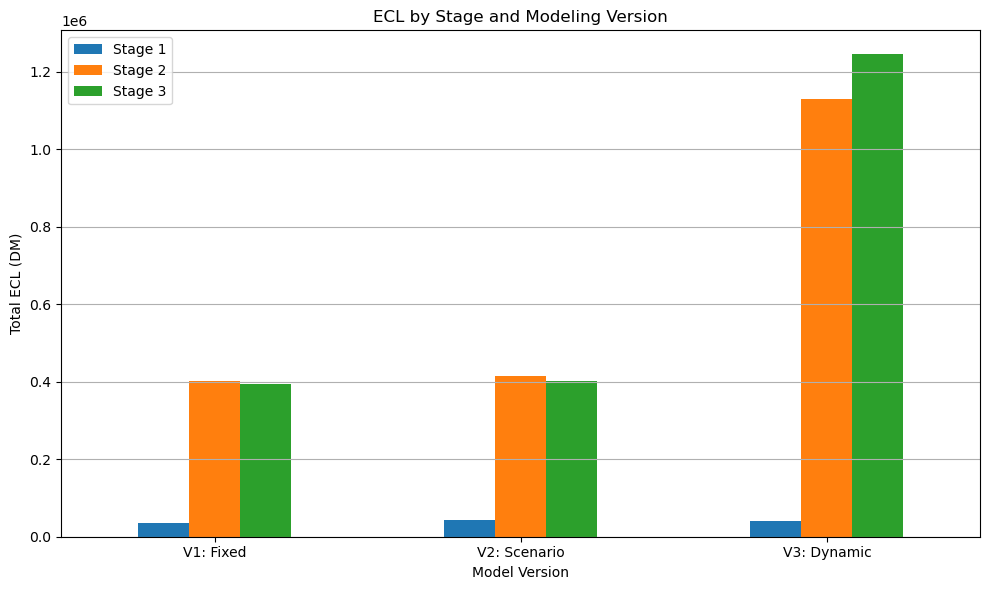

In [3083]:
# ECL results by stage and version
ecl_data = {
    "Stage 1": [34194, 43912, 41547],
    "Stage 2": [402285, 413789, 1129454],
    "Stage 3": [393982, 401461, 1244660]
}

df_ecl_versions = pd.DataFrame(ecl_data, index=["V1: Fixed", "V2: Scenario", "V3: Dynamic"])

# Plot
df_ecl_versions.plot(kind="bar", figsize=(10, 6))
plt.title("ECL by Stage and Modeling Version")
plt.xlabel("Model Version")
plt.ylabel("Total ECL (DM)")
plt.xticks(rotation=0)
plt.grid(axis="y")
plt.tight_layout()
plt.show()

### Version 1 – Simple Lifetime Discounting (Fixed Rate)

- Stage 1: Uses undiscounted 12-month ECL from original model.
- Stage 2 & 3: Lifetime ECL discounted over 5 years at a constant 5% rate.
- Assumes equal annual losses throughout the life of the exposure.

**Results:**

| Stage   | Total ECL (DM) | Credit Limit (DM) | % ECL / Credit Limit |
|---------|----------------|-------------------|----------------------|
| Stage 1 | 34,194         | 698,242           | 4.9%               |
| Stage 2 | 402,285        | 1,892,778         | 21.25%               |
| Stage 3 | 393,982        | 1,470,142         | 26.80%               |



In [3085]:
# Create a new column for staging
df_ecl["Stage"] = "Stage 1"

# Stage 3: observed default
df_ecl.loc[df_ecl["Risk"] == 1, "Stage"] = "Stage 3"

# Stage 2: significant increase in credit risk (PD_hat ≥ 0.2)
df_ecl.loc[(df_ecl["Risk"] == 0) & (df_ecl["PD_hat"] >= 0.2), "Stage"] = "Stage 2"

In [3086]:
# Assume df_discounted["ECL_lifetime_discounted"] was computed earlier
# Create new columns for stage-adjusted ECL
df_ecl["ECL_12m"] = df_ecl["ECL"]  # ECL non actualisé pour Stage 1
df_ecl["ECL_lifetime"] = df_discounted["ECL_lifetime_discounted"]

# Compute final stage-adjusted ECL
df_ecl["ECL_final"] = 0.0
df_ecl.loc[df_ecl["Stage"] == "Stage 1", "ECL_final"] = df_ecl["ECL_12m"]
df_ecl.loc[df_ecl["Stage"].isin(["Stage 2", "Stage 3"]), "ECL_final"] = df_ecl["ECL_lifetime"]

In [3087]:
# Step 6: Summary by stage
locale.setlocale(locale.LC_ALL, '')
summary = df_ecl.groupby("Stage").agg(
    Total_ECL=("ECL_final", "sum"),
    Total_Limit=("Credit_Limit", "sum"),
    Total_Amount=("Credit_Amount", "sum")
)
summary["ECL / Credit Limit (%)"] = (summary["Total_ECL"] / summary["Total_Limit"]) * 100
summary["ECL / Credit Amount (%)"] = (summary["Total_ECL"] / summary["Total_Amount"]) * 100

# Format and print
summary_formatted = summary[["Total_ECL", "Total_Limit", "ECL / Credit Limit (%)"]].copy()
summary_formatted["Total_ECL"] = summary_formatted["Total_ECL"].map("{:,.0f} DM".format)
summary_formatted["Total_Limit"] = summary_formatted["Total_Limit"].map("{:,.0f} DM".format)
summary_formatted["ECL / Credit Limit (%)"] = summary["ECL / Credit Limit (%)"].map("{:.2f} %".format)

print("✅ Final ECL by Stage with Relative Ratios:")
print(summary_formatted)

✅ Final ECL by Stage with Relative Ratios:
          Total_ECL   Total_Limit ECL / Credit Limit (%)
Stage                                                   
Stage 1   34,194 DM    698,242 DM                 4.90 %
Stage 2  402,285 DM  1,892,778 DM                21.25 %
Stage 3  393,982 DM  1,470,142 DM                26.80 %


In [3088]:
df_ecl

,Account_status:0 <= ... < 200 DM,Account_status:0 DM,Account_status:>= 200 DM or salary assignment,Account_status:no checking account,Age,Credit_Amount,Duration_Months,Employment_Since:1 <= ... < 4 years,Employment_Since:4 <= ... < 7 years,Employment_Since:< 1 year,Employment_Since:>= 7 years,Employment_Since:unemployed,History:critical / other banks,History:current credits paid,History:delayed previously,History:no credits_all paid_all paid at this bank,Housing:for free,Housing:own,Housing:rent,Other_Debtors:co-applicant,Other_Debtors:guarantor,Other_Debtors:none,Other_Installment:bank,Other_Installment:none,Other_Installment:stores,Personal_Status_Sex:female div/sep/married,Personal_Status_Sex:male divorced/separated,Personal_Status_Sex:male married/widowed,Personal_Status_Sex:male single,Property:building society savings / life insurance,Property:car or other (not in savings),Property:real estate,Property:unknown / no property,Purpose:education_others,Purpose:furniture/equipment,Purpose:new car,Purpose:radio/TV,Purpose:repairs_business_appliances,Purpose:used car_retraining,Savings_Account:100 <= ... < 500 DM,Savings_Account:< 100 DM,Savings_Account:>=1000 DM_500<...<1000 DM,Savings_Account:unknown / no savings,Risk,Recovered_Amount,LGD,Credit_Limit,Drawn_Amount,Undrawn,CCF,EAD,PD_hat,LGD_hat,CCF_hat,EAD_hat,ECL,Discounted_ECL,Stage,ECL_12m,ECL_lifetime,ECL_final
0,0,1,0,0,67,1169,6,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,NaN,NaN,1397.918699,978.484079,419.434621,0.354682,1127.250104,0.092192,0.467960,0.473960,1177.279454,50.790319,48.371732,Stage 1,50.790319,57.954656,50.790319
1,1,0,0,0,22,5951,48,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,2688.726656,0.548189,8789.850419,5405.770508,3384.079911,0.448792,6924.516873,0.749118,0.616088,0.513727,7144.265171,3297.240199,3140.228761,Stage 3,3297.240199,3691.136137,3691.136137
2,0,0,0,1,49,2096,12,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,NaN,NaN,2873.129651,2042.738894,830.390757,0.662502,2592.874292,0.788485,0.567230,0.408533,2381.980754,1065.347504,1014.616670,Stage 2,1065.347504,1175.845228,1175.845228
3,0,1,0,0,45,7882,42,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,NaN,NaN,10251.313086,7459.879311,2791.433775,0.299818,8296.802742,0.684963,0.368474,0.349525,8435.555381,2129.056222,2027.672593,Stage 2,2129.056222,2420.111152,2420.111152
4,0,1,0,0,53,4870,24,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,3355.451521,0.310996,5259.905389,4681.590558,578.314831,0.308780,4860.162548,0.643255,0.395158,0.377654,4899.993563,1245.515686,1186.205415,Stage 3,1245.515686,1421.204564,1421.204564
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,0,1,31,1736,12,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,NaN,NaN,1825.493240,1616.894830,208.598409,0.396118,1699.524478,0.386294,0.347640,0.249266,1668.891306,224.117635,213.445367,Stage 2,224.117635,255.731028,255.731028
996,0,1,0,0,40,3857,30,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,NaN,NaN,5636.039230,3823.532519,1812.506712,0.262909,4300.057359,0.427773,0.543928,0.434658,4611.352288,1072.958906,1021.865625,Stage 2,1072.958906,1224.307419,1224.307419
997,0,0,0,1,38,804,12,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,NaN,NaN,869.001090,654.288449,214.712641,0.423915,745.308389,0.143252,0.552403,0.504890,762.694719,60.354130,57.480124,Stage 1,60.354130,68.867511,60.354130
998,0,1,0,0,23,1845,45,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,629.411351,0.658856,2731.593959,1497.053192,1234.540767,0.616018,2257.552789,0.775595,0.718076,0.618209,2260.257999,1258.819310,1198.

### Version 2 – Lifetime Discounting + Scenario Weighting

- Applies macroeconomic stress scenarios with weighted probabilities.
- Stress factors adjust PD, LGD, and EAD before discounting.
- Each year's discounted loss is weighted by the scenario's likelihood.
- Still assumes constant annual loss across duration.

**Results:**

| Stage   | Total ECL (DM) | Credit Limit (DM) | % ECL / Credit Limit |
|---------|----------------|-------------------|----------------------|
| Stage 1 | 43,912         | 698,242           | 6.29%                |
| Stage 2 | 413,789        | 1,892,778         | 21.86%               |
| Stage 3 | 401,461        | 1,470,142         | 27.31%               |



In [3090]:
import numpy as np
import pandas as pd
import locale

# Step 1: Base data with duration in years
df_staged = df_ecl.copy()
df_staged["Years"] = (df_raw["Duration_Months"] / 12).clip(lower=1)

# Step 2: Assign IFRS 9 stage
df_staged["Stage"] = "Stage 1"
df_staged.loc[df_staged["Risk"] == 1, "Stage"] = "Stage 3"
df_staged.loc[(df_staged["Risk"] == 0) & (df_staged["PD_hat"] >= 0.2), "Stage"] = "Stage 2"

# Step 3: Define macroeconomic scenarios with weights
scenarios = {
    "baseline":  {"PD": 1.00, "LGD": 1.00, "EAD": 1.00, "prob": 0.5},
    "adverse_1": {"PD": 1.20, "LGD": 1.10, "EAD": 1.00, "prob": 0.2},
    "adverse_2": {"PD": 1.30, "LGD": 1.15, "EAD": 1.05, "prob": 0.2},
    "severe":    {"PD": 1.50, "LGD": 1.25, "EAD": 1.10, "prob": 0.1}
}

discount_rate = 0.05
df_staged["ECL_lifetime_scenario"] = 0.0
df_staged["ECL_12m_scenario"] = 0.0

# Step 4: Apply scenario-adjusted ECL
for name, factors in scenarios.items():
    prob = factors["prob"]
    
    pd_s = (df_staged["PD_hat"] * factors["PD"]).clip(0, 1)
    lgd_s = (df_staged["LGD_hat"] * factors["LGD"]).clip(0, 1)
    ead_s = df_staged["EAD_hat"] * factors["EAD"]
    
    # For lifetime ECL: discounted losses over estimated duration
    def discounted_loss(row):
        duration = max(1, int(np.ceil(row["Years"])))
        annual_loss = (pd_s[row.name] * lgd_s[row.name] * ead_s[row.name]) / duration
        return sum(annual_loss / ((1 + discount_rate) ** t) for t in range(1, duration + 1))
    
    # For 12-month ECL (Stage 1): non-discounted 1-year ECL under stress
    ecl_12m = pd_s * lgd_s * ead_s
    
    df_staged["ECL_lifetime_scenario"] += prob * df_staged.apply(discounted_loss, axis=1)
    df_staged["ECL_12m_scenario"] += prob * ecl_12m

# Step 5: Assign final ECL based on stage
df_staged["ECL_final"] = 0.0
df_staged.loc[df_staged["Stage"] == "Stage 1", "ECL_final"] = df_staged["ECL_12m_scenario"]
df_staged.loc[df_staged["Stage"].isin(["Stage 2", "Stage 3"]), "ECL_final"] = df_staged["ECL_lifetime_scenario"]
df_staged = df_staged.drop(["ECL_lifetime", "ECL_lifetime_scenario","ECL_12m_scenario"], axis = 1)

# Step 6: Summary by stage
locale.setlocale(locale.LC_ALL, '')
summary = df_staged.groupby("Stage").agg(
    Total_ECL=("ECL_final", "sum"),
    Total_Limit=("Credit_Limit", "sum"),
    Total_Amount=("Credit_Amount", "sum")
)
summary["ECL / Credit Limit (%)"] = (summary["Total_ECL"] / summary["Total_Limit"]) * 100
summary["ECL / Credit Amount (%)"] = (summary["Total_ECL"] / summary["Total_Amount"]) * 100

# Format and print
summary_formatted = summary[["Total_ECL", "Total_Limit", "ECL / Credit Limit (%)"]].copy()
summary_formatted["Total_ECL"] = summary_formatted["Total_ECL"].map("{:,.0f} DM".format)
summary_formatted["Total_Limit"] = summary_formatted["Total_Limit"].map("{:,.0f} DM".format)
summary_formatted["ECL / Credit Limit (%)"] = summary["ECL / Credit Limit (%)"].map("{:.2f} %".format)

print("✅ Final ECL by Stage with Relative Ratios:")
print(summary_formatted)

✅ Final ECL by Stage with Relative Ratios:
          Total_ECL   Total_Limit ECL / Credit Limit (%)
Stage                                                   
Stage 1   43,912 DM    698,242 DM                 6.29 %
Stage 2  413,789 DM  1,892,778 DM                21.86 %
Stage 3  401,461 DM  1,470,142 DM                27.31 %


### Version 3 – Dynamic Lifetime ECL (Scenarios + Evolving Risk)

- Duration is estimated for each contract in years.
- Stress factors (PD, LGD, EAD) evolve year-by-year (e.g., PD increases by +5%/year).
- Discounting is applied using a dynamic effective interest rate (e.g., EIR = 5% + 0.5% * t).
- Scenario-weighted outcome is applied for final ECL.

**Results:**

| Stage   | Total ECL (DM) | Credit Limit (DM) | % ECL / Credit Limit |
|---------|----------------|-------------------|----------------------|
| Stage 1 | 41,547         | 698,242           | 5.95%               |
| Stage 2 | 1,129,454      | 1,892,778         | 59.67%               |
| Stage 3 | 1,244,660      | 1,470,142         | 84.66%              |

⚠️ **Caution**: This version is the most sophisticated but also the most sensitive to modeling assumptions.  
The compounding increases in PD, LGD, and EAD over multiple years can lead to **overstated ECL** values.  
In practice, a more nuanced calibration or cap would be needed to reflect realistic deterioration.



In [3092]:
import numpy as np
import pandas as pd
import locale

# Step 1: Copy the base dataset and calculate duration
df_staged2 = df_ecl.copy()
df_staged2["Years"] = (df_raw["Duration_Months"] / 12).clip(lower=1)

# Step 2: Assign IFRS 9 stage
df_staged2["Stage"] = "Stage 1"
df_staged2.loc[df_staged2["Risk"] == 1, "Stage"] = "Stage 3"
df_staged2.loc[(df_staged2["Risk"] == 0) & (df_staged2["PD_hat"] >= 0.2), "Stage"] = "Stage 2"

# Step 3: Define economic scenarios with probability weights
scenarios = {
    "baseline":  {"PD": 1.00, "LGD": 1.00, "EAD": 1.00, "prob": 0.5},
    "adverse_1": {"PD": 1.15, "LGD": 1.05, "EAD": 1.00, "prob": 0.2},
    "adverse_2": {"PD": 1.25, "LGD": 1.10, "EAD": 1.05, "prob": 0.2},
    "severe":    {"PD": 1.40, "LGD": 1.20, "EAD": 1.10, "prob": 0.1}
}

discount_rate = 0.05
df_staged2["ECL_lifetime_scenario"] = 0.0
df_staged2["ECL_12m"] = 0.0  # initialize scenario-weighted 12-month ECL

# Step 4: Compute ECL under each scenario
for name, factors in scenarios.items():
    prob = factors["prob"]

    pd_s = (df_staged2["PD_hat"] * factors["PD"]).clip(0, 1)
    lgd_s = (df_staged2["LGD_hat"] * factors["LGD"]).clip(0, 1)
    ead_s = df_staged2["EAD_hat"] * factors["EAD"]

    # Step 4a: ECL for Stage 1 (12-month, undiscounted, scenario-weighted)
    ecl_12m_scenario = pd_s * lgd_s * ead_s
    df_staged2["ECL_12m"] += prob * ecl_12m_scenario

    # Step 4b: Lifetime ECL with dynamic discounting
    def dynamic_discounted_loss(row):
        duration = max(1, int(np.ceil(row["Years"])))
        losses = []

        for t in range(1, duration + 1):
            pd_t = min(1, pd_s[row.name] * (1 + 0.03 * t))
            lgd_t = min(1, lgd_s[row.name] * (1 + 0.01 * t))
            ead_t = ead_s[row.name] * (1 + 0.01 * t)
            eir_t = discount_rate + 0.005 * t

            loss_t = pd_t * lgd_t * ead_t
            discounted = loss_t / ((1 + eir_t) ** t)
            losses.append(discounted)

        return sum(losses)

    df_staged2["ECL_lifetime_scenario"] += prob * df_staged2.apply(dynamic_discounted_loss, axis=1)

# Step 5: Assign final ECL based on staging
df_staged2["ECL_final"] = 0.0
df_staged2.loc[df_staged2["Stage"] == "Stage 1", "ECL_final"] = df_staged2["ECL_12m"]
df_staged2.loc[df_staged2["Stage"].isin(["Stage 2", "Stage 3"]), "ECL_final"] = df_staged2["ECL_lifetime_scenario"]
df_staged2 = df_staged2.drop(["ECL_lifetime", "ECL_lifetime_scenario"], axis = 1)

# Step 6: Summary by stage
locale.setlocale(locale.LC_ALL, '')
summary = df_staged2.groupby("Stage").agg(
    Total_ECL=("ECL_final", "sum"),
    Total_Limit=("Credit_Limit", "sum"),
    Total_Amount=("Credit_Amount", "sum")
)
summary["ECL / Credit Limit (%)"] = (summary["Total_ECL"] / summary["Total_Limit"]) * 100
summary["ECL / Credit Amount (%)"] = (summary["Total_ECL"] / summary["Total_Amount"]) * 100

# Format and print
summary_formatted = summary[["Total_ECL", "Total_Limit", "ECL / Credit Limit (%)"]].copy()
summary_formatted["Total_ECL"] = summary_formatted["Total_ECL"].map("{:,.0f} DM".format)
summary_formatted["Total_Limit"] = summary_formatted["Total_Limit"].map("{:,.0f} DM".format)
summary_formatted["ECL / Credit Limit (%)"] = summary["ECL / Credit Limit (%)"].map("{:.2f} %".format)

print("✅ Final ECL by Stage with Relative Ratios:")
print(summary_formatted)

✅ Final ECL by Stage with Relative Ratios:
            Total_ECL   Total_Limit ECL / Credit Limit (%)
Stage                                                     
Stage 1     41,547 DM    698,242 DM                 5.95 %
Stage 2  1,129,454 DM  1,892,778 DM                59.67 %
Stage 3  1,244,660 DM  1,470,142 DM                84.66 %


### Summary

- The three versions illustrate increasing levels of realism and compliance:
  - **V1**: Quick approximation with fixed rate and fixed horizon.
  - **V2**: Regulatory alignment using scenario-weighted expectations.
  - **V3**: Fully dynamic lifetime loss with evolving risk profiles and interest rates.
- All versions are compliant with IFRS 9’s requirements:
  - Probability-weighted outcomes
  - Time value of money
  - Forward-looking, reasonable information